## Multi modal 3D brain tumor segmentaion using the BRATS 2016-2017 dataset

### Install monai
MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging.

In [1]:
# !pip install monai
# !pip install 'monai[all]'
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
# !pip install nilearn
# !pip install git+https://github.com/miykael/gif_your_nifti

### Import relevant libraries and functionality

In [13]:
import os
import shutil
import glob
import monai
import matplotlib
import torch
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
import gif_your_nifti.core as gif2nif
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imshow
from skimage.color import label2rgb
from skimage.util import montage 
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
import numpy as np
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import first, set_determinism
import warnings
warnings.filterwarnings('ignore')

print_config()

MONAI version: 0.5.3
Numpy version: 1.20.1
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d78c669c67e38ddfbe572f6a0438e9df0b8c65d7

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.9.1+cu102
ITK version: 5.1.2
tqdm version: 4.61.1
lmdb version: 1.2.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# set seed
set_determinism(seed=0)

### Create helper functions to read, split and process the dataset

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 0 is no tumor
    label 1 is the edema
    label 2 is the non enhancing tumor
    label 3 is enhancing tumor core
    The final classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1)
            )
            # label 3 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [5]:
def _transforms():
    '''
    The function creates the tranformations to be applied to the training and validation sets
    
    input: 
        no arguments
    output: 
        training and validation transforms (pytorch transforms)
    '''
    train_transforms = Compose(
        [
            # load 4 Nifti images and stack them together
            LoadImaged(keys=["image", "label"]),
            AsChannelFirstd(keys="image"),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            RandSpatialCropd(
                keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
            ),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
            ToTensord(keys=["image", "label"]),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AsChannelFirstd(keys="image"),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            ToTensord(keys=["image", "label"]),
        ]
    )
    return train_transforms, val_transforms

In [6]:
def split_dataset(data_dir):
    '''
    The function reads and splits the dataset into train and validation set
    
    input: 
        data_dir: the path of the directory where data exists (type: str)
    output: 
        list of {image name : label name} pairs for train and validation sets (type: list of dictionaries)
    '''
    # get list of image and labels list
    train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
    train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
    # create a dictionary of the images and labels pairs
    data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
    # split the training set into train and set sets
    train_idx, val_idx = train_test_split(np.arange(len(train_images)), test_size=0.2)
    train_files, val_files = list(np.array(data_dicts)[train_idx]) , list(np.array(data_dicts)[val_idx])
    return train_files, val_files

### Create the dataset and dataloaders using the helper functions

In [7]:
data_dir = 'data/'
train_files, val_files = split_dataset(data_dir)
train_transforms , val_transforms = _transforms()
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)

### Visualizing the dataset

In [63]:
def visualise_images_and_labels(dataset,image_id,image_slice):
    '''
    The function visualises the 4 modalities (T2 FAIR, T1, T1Gd and T2)
    along with the three output segmentaion ground truths (Whole tumor, Tumor core and Enhancing tumor)
    input:
        
    '''
    plt.figure("image", (24, 6))
    print(f"image shape: {dataset[image_id]['image'].shape}")
    modes = ['T2 FLAIR','T1','T1Gd','T2']
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"{modes[i]}")
        plt.imshow(dataset[image_id]["image"][i, :, :, image_slice].detach().cpu(), cmap="gray")
    plt.show()
    # also visualize the 3 channels label corresponding to this image
    print(f"label shape: {dataset[image_id]['label'].shape}")
    plt.figure("label", (18, 6))
    labels = ['Tumor core', 'Whole tumor' , 'Enhancing tumor']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"{labels[i]}")
        plt.imshow(dataset[image_id]["label"][i, :, :, image_slice].detach().cpu(), cmap ="gray")
    plt.show()

image shape: torch.Size([4, 128, 128, 64])


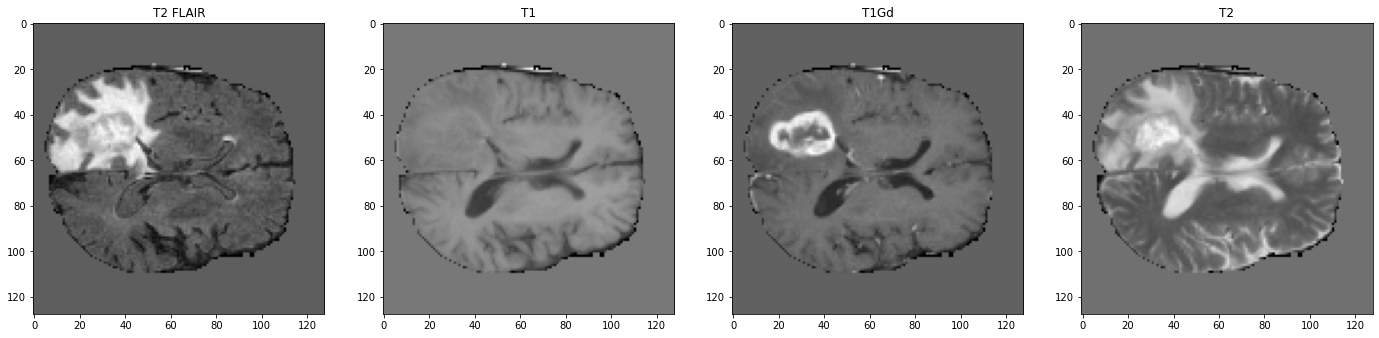

label shape: torch.Size([3, 128, 128, 64])


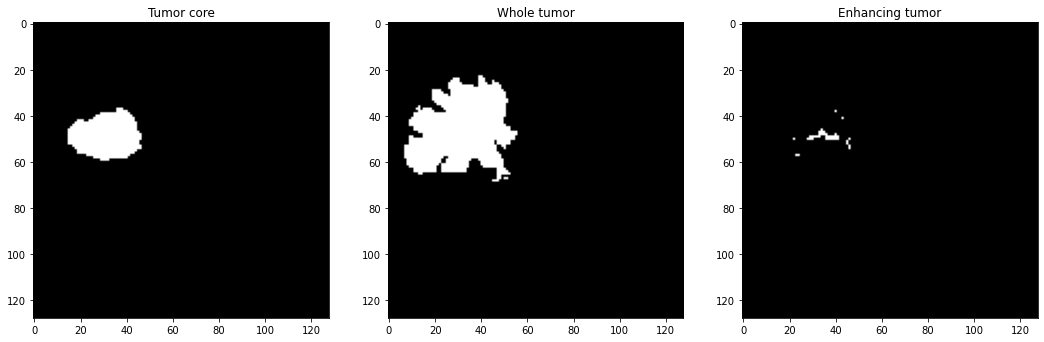

In [69]:
visualise_images_and_labels(val_ds,7,30)

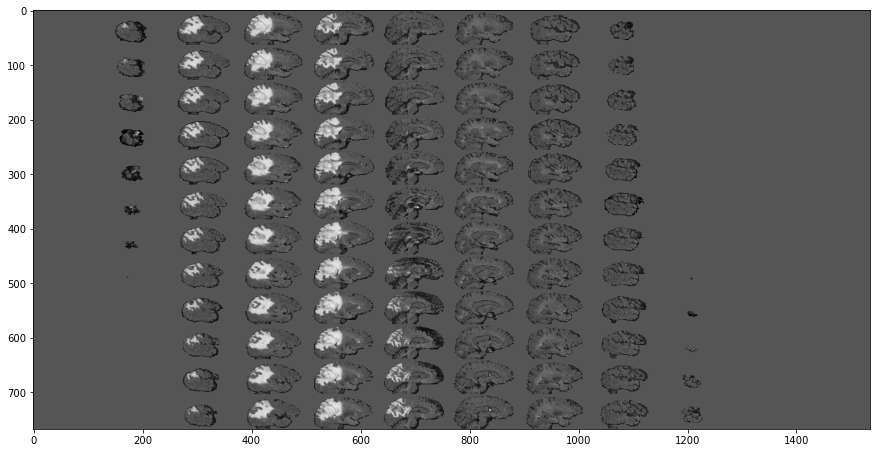

In [124]:
# Visualise all slices of T2 FLAIR 
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(val_ds[7]["image"][0,:,:,].detach().cpu()), 90, resize=True), cmap ='gray')

In [17]:
def save_gif(dataset,image_id,out_location, modality = 0):
    '''
    saves the gif depicting all the slices of a specified madality
    input:
        dataset: the pytorch dataset object
        image_id: the index of the image in the dataset
        out_location: the location and name of the output file
        modality: the index of the particular modality in the dataset
        
    output: 
        an nii image of the modality selected
        a gif image of the  modality selected
    '''
    img = dataset[image_id]["image"][0,:,:,:].detach().cpu().numpy()
    lab = dataset[image_id]["label"][0,:,:,:].detach().cpu().numpy()
    img = nib.Nifti1Image(img, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    nib.save(img, out_location+'/test.nii')
    nib.save(lab, out_location+'/test_lab.nii')
    gif2nif.write_gif_normal(out_location+'/test.nii')

In [ ]:
save_gif(val_ds, 7, 'data/samples/')

![flair_gif](data/samples/test.gif "hi")

### Build and train the 3D UNET model

In [29]:
# Build the multi-modal multi output 3D-unet model using monai 
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)

optimizer = torch.optim.Adam(
    model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True
)

In [35]:
max_epochs = 200
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

----------
epoch 1/200
1/237, train_loss: 0.9296
2/237, train_loss: 0.9760
3/237, train_loss: 0.9551
4/237, train_loss: 0.9429
5/237, train_loss: 0.9718
6/237, train_loss: 0.9280
7/237, train_loss: 0.9357
8/237, train_loss: 0.9049
9/237, train_loss: 0.9364
10/237, train_loss: 0.9170
11/237, train_loss: 0.9415
12/237, train_loss: 0.9459
13/237, train_loss: 0.9269
14/237, train_loss: 0.9233
15/237, train_loss: 0.9617
16/237, train_loss: 0.9174
17/237, train_loss: 0.9255
18/237, train_loss: 0.9127
19/237, train_loss: 0.9307
20/237, train_loss: 0.8950
21/237, train_loss: 0.9608
22/237, train_loss: 0.8885
23/237, train_loss: 0.9566
24/237, train_loss: 0.9737
25/237, train_loss: 0.9442
26/237, train_loss: 0.8965
27/237, train_loss: 0.9303
28/237, train_loss: 0.9270
29/237, train_loss: 0.9228
30/237, train_loss: 0.8982
31/237, train_loss: 0.9719
32/237, train_loss: 0.9773
33/237, train_loss: 0.9431
34/237, train_loss: 0.9409
35/237, train_loss: 0.8482
36/237, train_loss: 0.9247
37/237, train_

60/237, train_loss: 0.9104
61/237, train_loss: 0.8886
62/237, train_loss: 0.9276
63/237, train_loss: 0.9121
64/237, train_loss: 0.9092
65/237, train_loss: 0.9193
66/237, train_loss: 0.8931
67/237, train_loss: 0.9093
68/237, train_loss: 0.9292
69/237, train_loss: 0.9577
70/237, train_loss: 0.9528
71/237, train_loss: 0.8733
72/237, train_loss: 0.9283
73/237, train_loss: 0.9349
74/237, train_loss: 0.9251
75/237, train_loss: 0.9437
76/237, train_loss: 0.9444
77/237, train_loss: 0.8471
78/237, train_loss: 0.9601
79/237, train_loss: 0.9078
80/237, train_loss: 0.8922
81/237, train_loss: 0.8869
82/237, train_loss: 0.9023
83/237, train_loss: 0.9593
84/237, train_loss: 0.9720
85/237, train_loss: 0.9173
86/237, train_loss: 0.9689
87/237, train_loss: 0.9000
88/237, train_loss: 0.9455
89/237, train_loss: 0.9551
90/237, train_loss: 0.9219
91/237, train_loss: 0.9185
92/237, train_loss: 0.8577
93/237, train_loss: 0.9009
94/237, train_loss: 0.9209
95/237, train_loss: 0.8598
96/237, train_loss: 0.9285
9

114/237, train_loss: 0.8581
115/237, train_loss: 0.8464
116/237, train_loss: 0.8854
117/237, train_loss: 0.9451
118/237, train_loss: 0.9636
119/237, train_loss: 0.9462
120/237, train_loss: 0.9290
121/237, train_loss: 0.9466
122/237, train_loss: 0.9444
123/237, train_loss: 0.8714
124/237, train_loss: 0.9645
125/237, train_loss: 0.9044
126/237, train_loss: 0.8890
127/237, train_loss: 0.9716
128/237, train_loss: 0.9554
129/237, train_loss: 0.8586
130/237, train_loss: 0.8768
131/237, train_loss: 0.9439
132/237, train_loss: 0.9708
133/237, train_loss: 0.9495
134/237, train_loss: 0.8931
135/237, train_loss: 0.9539
136/237, train_loss: 0.8682
137/237, train_loss: 0.8986
138/237, train_loss: 0.8819
139/237, train_loss: 0.9546
140/237, train_loss: 0.9287
141/237, train_loss: 0.9186
142/237, train_loss: 0.8920
143/237, train_loss: 0.8955
144/237, train_loss: 0.8989
145/237, train_loss: 0.8256
146/237, train_loss: 0.9295
147/237, train_loss: 0.8489
148/237, train_loss: 0.8479
149/237, train_loss:

171/237, train_loss: 0.9427
172/237, train_loss: 0.7413
173/237, train_loss: 0.8678
174/237, train_loss: 0.8469
175/237, train_loss: 0.9211
176/237, train_loss: 0.7553
177/237, train_loss: 0.8260
178/237, train_loss: 0.8197
179/237, train_loss: 0.8475
180/237, train_loss: 0.8999
181/237, train_loss: 0.9093
182/237, train_loss: 0.8613
183/237, train_loss: 0.8720
184/237, train_loss: 0.9593
185/237, train_loss: 0.8412
186/237, train_loss: 0.9031
187/237, train_loss: 0.8263
188/237, train_loss: 0.9420
189/237, train_loss: 0.8963
190/237, train_loss: 0.8708
191/237, train_loss: 0.9296
192/237, train_loss: 0.8267
193/237, train_loss: 0.8246
194/237, train_loss: 0.8236
195/237, train_loss: 0.9027
196/237, train_loss: 0.9385
197/237, train_loss: 0.7867
198/237, train_loss: 0.9340
199/237, train_loss: 0.8592
200/237, train_loss: 0.9183
201/237, train_loss: 0.8514
202/237, train_loss: 0.8737
203/237, train_loss: 0.8028
204/237, train_loss: 0.9069
205/237, train_loss: 0.8771
206/237, train_loss:

223/237, train_loss: 0.8109
224/237, train_loss: 0.8848
225/237, train_loss: 0.8689
226/237, train_loss: 0.7840
227/237, train_loss: 0.9181
228/237, train_loss: 0.8723
229/237, train_loss: 0.8771
230/237, train_loss: 0.8738
231/237, train_loss: 0.9012
232/237, train_loss: 0.8081
233/237, train_loss: 0.7793
234/237, train_loss: 0.8290
235/237, train_loss: 0.8590
236/237, train_loss: 0.8977
237/237, train_loss: 0.8623
238/237, train_loss: 0.8404
epoch 5 average loss: 0.8387
----------
epoch 6/200
1/237, train_loss: 0.7732
2/237, train_loss: 0.5828
3/237, train_loss: 0.8332
4/237, train_loss: 0.8583
5/237, train_loss: 0.7515
6/237, train_loss: 0.8143
7/237, train_loss: 0.8729
8/237, train_loss: 0.7760
9/237, train_loss: 0.8597
10/237, train_loss: 0.9478
11/237, train_loss: 0.8300
12/237, train_loss: 0.9047
13/237, train_loss: 0.8359
14/237, train_loss: 0.8560
15/237, train_loss: 0.8406
16/237, train_loss: 0.7560
17/237, train_loss: 0.8286
18/237, train_loss: 0.7893
19/237, train_loss: 0.7

37/237, train_loss: 0.8812
38/237, train_loss: 0.7706
39/237, train_loss: 0.6026
40/237, train_loss: 0.6309
41/237, train_loss: 0.7751
42/237, train_loss: 0.7339
43/237, train_loss: 0.8967
44/237, train_loss: 0.7679
45/237, train_loss: 0.7313
46/237, train_loss: 0.7958
47/237, train_loss: 0.7355
48/237, train_loss: 0.7333
49/237, train_loss: 0.5957
50/237, train_loss: 0.7739
51/237, train_loss: 0.8086
52/237, train_loss: 0.8089
53/237, train_loss: 0.6947
54/237, train_loss: 0.8034
55/237, train_loss: 0.7927
56/237, train_loss: 0.7948
57/237, train_loss: 0.7896
58/237, train_loss: 0.7315
59/237, train_loss: 0.6578
60/237, train_loss: 0.8342
61/237, train_loss: 0.8098
62/237, train_loss: 0.9515
63/237, train_loss: 0.7027
64/237, train_loss: 0.7522
65/237, train_loss: 0.8438
66/237, train_loss: 0.7036
67/237, train_loss: 0.7036
68/237, train_loss: 0.8448
69/237, train_loss: 0.5563
70/237, train_loss: 0.8091
71/237, train_loss: 0.8879
72/237, train_loss: 0.9048
73/237, train_loss: 0.8017
7

96/237, train_loss: 0.9061
97/237, train_loss: 0.6629
98/237, train_loss: 0.7347
99/237, train_loss: 0.6583
100/237, train_loss: 0.6508
101/237, train_loss: 0.8841
102/237, train_loss: 0.7018
103/237, train_loss: 0.5890
104/237, train_loss: 0.6664
105/237, train_loss: 0.8625
106/237, train_loss: 0.5660
107/237, train_loss: 0.7432
108/237, train_loss: 0.5440
109/237, train_loss: 0.5827
110/237, train_loss: 0.6412
111/237, train_loss: 0.9196
112/237, train_loss: 0.6812
113/237, train_loss: 0.7452
114/237, train_loss: 0.6741
115/237, train_loss: 0.6922
116/237, train_loss: 0.5257
117/237, train_loss: 0.7067
118/237, train_loss: 0.7638
119/237, train_loss: 0.7647
120/237, train_loss: 0.6617
121/237, train_loss: 0.5865
122/237, train_loss: 0.7101
123/237, train_loss: 0.6108
124/237, train_loss: 0.6872
125/237, train_loss: 0.6376
126/237, train_loss: 0.8045
127/237, train_loss: 0.7681
128/237, train_loss: 0.6945
129/237, train_loss: 0.5570
130/237, train_loss: 0.7937
131/237, train_loss: 0.7

148/237, train_loss: 0.6014
149/237, train_loss: 0.5817
150/237, train_loss: 0.8109
151/237, train_loss: 0.7224
152/237, train_loss: 0.6820
153/237, train_loss: 0.6221
154/237, train_loss: 0.8166
155/237, train_loss: 0.8377
156/237, train_loss: 0.7039
157/237, train_loss: 0.8661
158/237, train_loss: 0.7865
159/237, train_loss: 0.8563
160/237, train_loss: 0.8810
161/237, train_loss: 0.8187
162/237, train_loss: 0.5920
163/237, train_loss: 0.8732
164/237, train_loss: 0.6576
165/237, train_loss: 0.5725
166/237, train_loss: 0.6445
167/237, train_loss: 0.5288
168/237, train_loss: 0.6147
169/237, train_loss: 0.6680
170/237, train_loss: 0.7340
171/237, train_loss: 0.5004
172/237, train_loss: 0.6174
173/237, train_loss: 0.7720
174/237, train_loss: 0.5434
175/237, train_loss: 0.6522
176/237, train_loss: 0.8883
177/237, train_loss: 0.8165
178/237, train_loss: 0.5199
179/237, train_loss: 0.7733
180/237, train_loss: 0.8580
181/237, train_loss: 0.7284
182/237, train_loss: 0.6102
183/237, train_loss:

205/237, train_loss: 0.5172
206/237, train_loss: 0.7384
207/237, train_loss: 0.4672
208/237, train_loss: 0.6799
209/237, train_loss: 0.5703
210/237, train_loss: 0.4964
211/237, train_loss: 0.7973
212/237, train_loss: 0.6477
213/237, train_loss: 0.7607
214/237, train_loss: 0.5348
215/237, train_loss: 0.5661
216/237, train_loss: 0.5794
217/237, train_loss: 0.6671
218/237, train_loss: 0.5431
219/237, train_loss: 0.5572
220/237, train_loss: 0.6327
221/237, train_loss: 0.7804
222/237, train_loss: 0.6931
223/237, train_loss: 0.5985
224/237, train_loss: 0.5468
225/237, train_loss: 0.5396
226/237, train_loss: 0.5574
227/237, train_loss: 0.5438
228/237, train_loss: 0.6084
229/237, train_loss: 0.6721
230/237, train_loss: 0.5136
231/237, train_loss: 0.7484
232/237, train_loss: 0.7447
233/237, train_loss: 0.5386
234/237, train_loss: 0.7487
235/237, train_loss: 0.5266
236/237, train_loss: 0.4259
237/237, train_loss: 0.4669
238/237, train_loss: 0.5898
epoch 10 average loss: 0.6626
saved new best met

18/237, train_loss: 0.6948
19/237, train_loss: 0.4232
20/237, train_loss: 0.7194
21/237, train_loss: 0.5492
22/237, train_loss: 0.7856
23/237, train_loss: 0.5229
24/237, train_loss: 0.5730
25/237, train_loss: 0.4805
26/237, train_loss: 0.5544
27/237, train_loss: 0.5446
28/237, train_loss: 0.7221
29/237, train_loss: 0.6366
30/237, train_loss: 0.7743
31/237, train_loss: 0.6501
32/237, train_loss: 0.6511
33/237, train_loss: 0.7178
34/237, train_loss: 0.5304
35/237, train_loss: 0.7004
36/237, train_loss: 0.7087
37/237, train_loss: 0.7245
38/237, train_loss: 0.5821
39/237, train_loss: 0.4914
40/237, train_loss: 0.5878
41/237, train_loss: 0.6719
42/237, train_loss: 0.6313
43/237, train_loss: 0.4753
44/237, train_loss: 0.7674
45/237, train_loss: 0.8825
46/237, train_loss: 0.4759
47/237, train_loss: 0.6536
48/237, train_loss: 0.6347
49/237, train_loss: 0.6916
50/237, train_loss: 0.5522
51/237, train_loss: 0.5439
52/237, train_loss: 0.6726
53/237, train_loss: 0.6671
54/237, train_loss: 0.4816
5

72/237, train_loss: 0.7850
73/237, train_loss: 0.6917
74/237, train_loss: 0.5976
75/237, train_loss: 0.8083
76/237, train_loss: 0.4962
77/237, train_loss: 0.6067
78/237, train_loss: 0.4723
79/237, train_loss: 0.6493
80/237, train_loss: 0.4628
81/237, train_loss: 0.5018
82/237, train_loss: 0.6701
83/237, train_loss: 0.3344
84/237, train_loss: 0.5342
85/237, train_loss: 0.7232
86/237, train_loss: 0.5410
87/237, train_loss: 0.5481
88/237, train_loss: 0.3774
89/237, train_loss: 0.7861
90/237, train_loss: 0.5576
91/237, train_loss: 0.6500
92/237, train_loss: 0.6677
93/237, train_loss: 0.5360
94/237, train_loss: 0.4680
95/237, train_loss: 0.7758
96/237, train_loss: 0.4282
97/237, train_loss: 0.3144
98/237, train_loss: 0.6644
99/237, train_loss: 0.4075
100/237, train_loss: 0.6290
101/237, train_loss: 0.7926
102/237, train_loss: 0.6796
103/237, train_loss: 0.6008
104/237, train_loss: 0.5951
105/237, train_loss: 0.3232
106/237, train_loss: 0.4461
107/237, train_loss: 0.7058
108/237, train_loss:

130/237, train_loss: 0.5840
131/237, train_loss: 0.6615
132/237, train_loss: 0.5059
133/237, train_loss: 0.6485
134/237, train_loss: 0.6483
135/237, train_loss: 0.6083
136/237, train_loss: 0.4682
137/237, train_loss: 0.7210
138/237, train_loss: 0.4966
139/237, train_loss: 0.6453
140/237, train_loss: 0.7869
141/237, train_loss: 0.6404
142/237, train_loss: 0.6427
143/237, train_loss: 0.4114
144/237, train_loss: 0.6335
145/237, train_loss: 0.6201
146/237, train_loss: 0.5380
147/237, train_loss: 0.3546
148/237, train_loss: 0.7142
149/237, train_loss: 0.5750
150/237, train_loss: 0.5045
151/237, train_loss: 0.6423
152/237, train_loss: 0.6473
153/237, train_loss: 0.6293
154/237, train_loss: 0.4764
155/237, train_loss: 0.5713
156/237, train_loss: 0.4467
157/237, train_loss: 0.4907
158/237, train_loss: 0.5247
159/237, train_loss: 0.6553
160/237, train_loss: 0.5846
161/237, train_loss: 0.4753
162/237, train_loss: 0.6601
163/237, train_loss: 0.3880
164/237, train_loss: 0.4507
165/237, train_loss:

182/237, train_loss: 0.7270
183/237, train_loss: 0.5980
184/237, train_loss: 0.7124
185/237, train_loss: 0.6702
186/237, train_loss: 0.5802
187/237, train_loss: 0.5918
188/237, train_loss: 0.6707
189/237, train_loss: 0.6550
190/237, train_loss: 0.5803
191/237, train_loss: 0.7088
192/237, train_loss: 0.4753
193/237, train_loss: 0.8062
194/237, train_loss: 0.5922
195/237, train_loss: 0.6000
196/237, train_loss: 0.5537
197/237, train_loss: 0.6432
198/237, train_loss: 0.4415
199/237, train_loss: 0.4244
200/237, train_loss: 0.3783
201/237, train_loss: 0.5089
202/237, train_loss: 0.5297
203/237, train_loss: 0.6139
204/237, train_loss: 0.4617
205/237, train_loss: 0.8205
206/237, train_loss: 0.5167
207/237, train_loss: 0.7173
208/237, train_loss: 0.4318
209/237, train_loss: 0.5735
210/237, train_loss: 0.4676
211/237, train_loss: 0.5791
212/237, train_loss: 0.6059
213/237, train_loss: 0.6157
214/237, train_loss: 0.5079
215/237, train_loss: 0.5632
216/237, train_loss: 0.5545
217/237, train_loss:

saved new best metric model
current epoch: 16 current mean dice: 0.5946 tc: 0.6355 wt: 0.8407 et: 0.3075
best mean dice: 0.5946 at epoch: 16
----------
epoch 17/200
1/237, train_loss: 0.7461
2/237, train_loss: 0.6651
3/237, train_loss: 0.5346
4/237, train_loss: 0.6000
5/237, train_loss: 0.3652
6/237, train_loss: 0.5283
7/237, train_loss: 0.5304
8/237, train_loss: 0.6212
9/237, train_loss: 0.7438
10/237, train_loss: 0.3756
11/237, train_loss: 0.5700
12/237, train_loss: 0.5831
13/237, train_loss: 0.6501
14/237, train_loss: 0.7775
15/237, train_loss: 0.3704
16/237, train_loss: 0.5756
17/237, train_loss: 0.4020
18/237, train_loss: 0.7385
19/237, train_loss: 0.7921
20/237, train_loss: 0.4859
21/237, train_loss: 0.5613
22/237, train_loss: 0.5315
23/237, train_loss: 0.3734
24/237, train_loss: 0.4561
25/237, train_loss: 0.6493
26/237, train_loss: 0.5947
27/237, train_loss: 0.4737
28/237, train_loss: 0.5819
29/237, train_loss: 0.5300
30/237, train_loss: 0.5760
31/237, train_loss: 0.5145
32/237,

54/237, train_loss: 0.4134
55/237, train_loss: 0.8668
56/237, train_loss: 0.3322
57/237, train_loss: 0.4314
58/237, train_loss: 0.3691
59/237, train_loss: 0.7658
60/237, train_loss: 0.7048
61/237, train_loss: 0.5317
62/237, train_loss: 0.3140
63/237, train_loss: 0.7535
64/237, train_loss: 0.4663
65/237, train_loss: 0.6302
66/237, train_loss: 0.4074
67/237, train_loss: 0.4154
68/237, train_loss: 0.5697
69/237, train_loss: 0.2780
70/237, train_loss: 0.3708
71/237, train_loss: 0.5829
72/237, train_loss: 0.5322
73/237, train_loss: 0.4371
74/237, train_loss: 0.5097
75/237, train_loss: 0.5810
76/237, train_loss: 0.4388
77/237, train_loss: 0.4035
78/237, train_loss: 0.5966
79/237, train_loss: 0.6363
80/237, train_loss: 0.6122
81/237, train_loss: 0.3051
82/237, train_loss: 0.6420
83/237, train_loss: 0.3430
84/237, train_loss: 0.4665
85/237, train_loss: 0.2973
86/237, train_loss: 0.4677
87/237, train_loss: 0.2534
88/237, train_loss: 0.4571
89/237, train_loss: 0.5236
90/237, train_loss: 0.6375
9

108/237, train_loss: 0.6649
109/237, train_loss: 0.3328
110/237, train_loss: 0.3900
111/237, train_loss: 0.5959
112/237, train_loss: 0.4162
113/237, train_loss: 0.3430
114/237, train_loss: 0.6426
115/237, train_loss: 0.2924
116/237, train_loss: 0.4317
117/237, train_loss: 0.4396
118/237, train_loss: 0.7999
119/237, train_loss: 0.6591
120/237, train_loss: 0.7366
121/237, train_loss: 0.5201
122/237, train_loss: 0.4499
123/237, train_loss: 0.4747
124/237, train_loss: 0.6657
125/237, train_loss: 0.4311
126/237, train_loss: 0.3854
127/237, train_loss: 0.2944
128/237, train_loss: 0.2974
129/237, train_loss: 0.5487
130/237, train_loss: 0.5384
131/237, train_loss: 0.4888
132/237, train_loss: 0.5178
133/237, train_loss: 0.6778
134/237, train_loss: 0.5305
135/237, train_loss: 0.6740
136/237, train_loss: 0.5210
137/237, train_loss: 0.6770
138/237, train_loss: 0.4101
139/237, train_loss: 0.2655
140/237, train_loss: 0.4569
141/237, train_loss: 0.4165
142/237, train_loss: 0.5757
143/237, train_loss:

165/237, train_loss: 0.4609
166/237, train_loss: 0.6400
167/237, train_loss: 0.3777
168/237, train_loss: 0.3053
169/237, train_loss: 0.5389
170/237, train_loss: 0.3077
171/237, train_loss: 0.5023
172/237, train_loss: 0.3283
173/237, train_loss: 0.4953
174/237, train_loss: 0.4158
175/237, train_loss: 0.4865
176/237, train_loss: 0.4295
177/237, train_loss: 0.4378
178/237, train_loss: 0.5473
179/237, train_loss: 0.4331
180/237, train_loss: 0.2639
181/237, train_loss: 0.3415
182/237, train_loss: 0.4372
183/237, train_loss: 0.2972
184/237, train_loss: 0.4677
185/237, train_loss: 0.2708
186/237, train_loss: 0.8352
187/237, train_loss: 0.4610
188/237, train_loss: 0.6769
189/237, train_loss: 0.4843
190/237, train_loss: 0.5150
191/237, train_loss: 0.4634
192/237, train_loss: 0.3801
193/237, train_loss: 0.5071
194/237, train_loss: 0.4625
195/237, train_loss: 0.3144
196/237, train_loss: 0.7083
197/237, train_loss: 0.4857
198/237, train_loss: 0.4982
199/237, train_loss: 0.3688
200/237, train_loss:

217/237, train_loss: 0.3258
218/237, train_loss: 0.3092
219/237, train_loss: 0.5921
220/237, train_loss: 0.3983
221/237, train_loss: 0.5345
222/237, train_loss: 0.3826
223/237, train_loss: 0.5726
224/237, train_loss: 0.3013
225/237, train_loss: 0.5455
226/237, train_loss: 0.4637
227/237, train_loss: 0.4406
228/237, train_loss: 0.4700
229/237, train_loss: 0.6791
230/237, train_loss: 0.5872
231/237, train_loss: 0.5008
232/237, train_loss: 0.7020
233/237, train_loss: 0.5785
234/237, train_loss: 0.5309
235/237, train_loss: 0.5295
236/237, train_loss: 0.2403
237/237, train_loss: 0.2686
238/237, train_loss: 0.6595
epoch 21 average loss: 0.4672
----------
epoch 22/200
1/237, train_loss: 0.4074
2/237, train_loss: 0.4642
3/237, train_loss: 0.5803
4/237, train_loss: 0.2332
5/237, train_loss: 0.6351
6/237, train_loss: 0.4825
7/237, train_loss: 0.2728
8/237, train_loss: 0.3745
9/237, train_loss: 0.3277
10/237, train_loss: 0.4364
11/237, train_loss: 0.4455
12/237, train_loss: 0.5828
13/237, train_l

30/237, train_loss: 0.2968
31/237, train_loss: 0.5917
32/237, train_loss: 0.4135
33/237, train_loss: 0.3585
34/237, train_loss: 0.2394
35/237, train_loss: 0.3177
36/237, train_loss: 0.7277
37/237, train_loss: 0.5635
38/237, train_loss: 0.3329
39/237, train_loss: 0.5575
40/237, train_loss: 0.4779
41/237, train_loss: 0.4168
42/237, train_loss: 0.4214
43/237, train_loss: 0.3428
44/237, train_loss: 0.5364
45/237, train_loss: 0.6002
46/237, train_loss: 0.5236
47/237, train_loss: 0.6484
48/237, train_loss: 0.7136
49/237, train_loss: 0.5473
50/237, train_loss: 0.5829
51/237, train_loss: 0.2495
52/237, train_loss: 0.4477
53/237, train_loss: 0.2317
54/237, train_loss: 0.3775
55/237, train_loss: 0.4748
56/237, train_loss: 0.5400
57/237, train_loss: 0.4810
58/237, train_loss: 0.6794
59/237, train_loss: 0.4108
60/237, train_loss: 0.5480
61/237, train_loss: 0.4992
62/237, train_loss: 0.4383
63/237, train_loss: 0.3475
64/237, train_loss: 0.4760
65/237, train_loss: 0.6449
66/237, train_loss: 0.2605
6

89/237, train_loss: 0.6222
90/237, train_loss: 0.4499
91/237, train_loss: 0.3189
92/237, train_loss: 0.7046
93/237, train_loss: 0.2224
94/237, train_loss: 0.5676
95/237, train_loss: 0.7402
96/237, train_loss: 0.2972
97/237, train_loss: 0.5316
98/237, train_loss: 0.4770
99/237, train_loss: 0.2646
100/237, train_loss: 0.4568
101/237, train_loss: 0.6691
102/237, train_loss: 0.2736
103/237, train_loss: 0.3868
104/237, train_loss: 0.5786
105/237, train_loss: 0.6088
106/237, train_loss: 0.3523
107/237, train_loss: 0.5472
108/237, train_loss: 0.4822
109/237, train_loss: 0.2289
110/237, train_loss: 0.2543
111/237, train_loss: 0.2920
112/237, train_loss: 0.5101
113/237, train_loss: 0.4699
114/237, train_loss: 0.3444
115/237, train_loss: 0.4056
116/237, train_loss: 0.3958
117/237, train_loss: 0.3243
118/237, train_loss: 0.3649
119/237, train_loss: 0.6371
120/237, train_loss: 0.4455
121/237, train_loss: 0.2832
122/237, train_loss: 0.3471
123/237, train_loss: 0.3891
124/237, train_loss: 0.3543
125

141/237, train_loss: 0.4142
142/237, train_loss: 0.5261
143/237, train_loss: 0.3808
144/237, train_loss: 0.5242
145/237, train_loss: 0.4806
146/237, train_loss: 0.3095
147/237, train_loss: 0.2885
148/237, train_loss: 0.2628
149/237, train_loss: 0.2482
150/237, train_loss: 0.5167
151/237, train_loss: 0.5755
152/237, train_loss: 0.2823
153/237, train_loss: 0.3320
154/237, train_loss: 0.3307
155/237, train_loss: 0.5224
156/237, train_loss: 0.4995
157/237, train_loss: 0.4868
158/237, train_loss: 0.3788
159/237, train_loss: 0.3727
160/237, train_loss: 0.3093
161/237, train_loss: 0.3441
162/237, train_loss: 0.4320
163/237, train_loss: 0.4804
164/237, train_loss: 0.5302
165/237, train_loss: 0.4388
166/237, train_loss: 0.4797
167/237, train_loss: 0.5596
168/237, train_loss: 0.3280
169/237, train_loss: 0.3183
170/237, train_loss: 0.2941
171/237, train_loss: 0.2385
172/237, train_loss: 0.5203
173/237, train_loss: 0.5460
174/237, train_loss: 0.3847
175/237, train_loss: 0.4340
176/237, train_loss:

198/237, train_loss: 0.3375
199/237, train_loss: 0.7788
200/237, train_loss: 0.2725
201/237, train_loss: 0.5046
202/237, train_loss: 0.4687
203/237, train_loss: 0.3419
204/237, train_loss: 0.5873
205/237, train_loss: 0.5261
206/237, train_loss: 0.3482
207/237, train_loss: 0.2616
208/237, train_loss: 0.4467
209/237, train_loss: 0.3521
210/237, train_loss: 0.3788
211/237, train_loss: 0.3301
212/237, train_loss: 0.4817
213/237, train_loss: 0.5507
214/237, train_loss: 0.4371
215/237, train_loss: 0.4524
216/237, train_loss: 0.5332
217/237, train_loss: 0.2729
218/237, train_loss: 0.3870
219/237, train_loss: 0.7008
220/237, train_loss: 0.3309
221/237, train_loss: 0.4646
222/237, train_loss: 0.5405
223/237, train_loss: 0.3601
224/237, train_loss: 0.5263
225/237, train_loss: 0.3358
226/237, train_loss: 0.2760
227/237, train_loss: 0.5377
228/237, train_loss: 0.4679
229/237, train_loss: 0.3272
230/237, train_loss: 0.3693
231/237, train_loss: 0.6725
232/237, train_loss: 0.4417
233/237, train_loss:

11/237, train_loss: 0.1933
12/237, train_loss: 0.2699
13/237, train_loss: 0.4204
14/237, train_loss: 0.3127
15/237, train_loss: 0.4234
16/237, train_loss: 0.3246
17/237, train_loss: 0.5518
18/237, train_loss: 0.3135
19/237, train_loss: 0.3163
20/237, train_loss: 0.4068
21/237, train_loss: 0.2380
22/237, train_loss: 0.4543
23/237, train_loss: 0.4059
24/237, train_loss: 0.5529
25/237, train_loss: 0.1769
26/237, train_loss: 0.5655
27/237, train_loss: 0.1802
28/237, train_loss: 0.3258
29/237, train_loss: 0.5974
30/237, train_loss: 0.2679
31/237, train_loss: 0.3132
32/237, train_loss: 0.4145
33/237, train_loss: 0.4311
34/237, train_loss: 0.2425
35/237, train_loss: 0.3031
36/237, train_loss: 0.5327
37/237, train_loss: 0.6223
38/237, train_loss: 0.3249
39/237, train_loss: 0.6121
40/237, train_loss: 0.2166
41/237, train_loss: 0.4774
42/237, train_loss: 0.6501
43/237, train_loss: 0.4039
44/237, train_loss: 0.6119
45/237, train_loss: 0.4718
46/237, train_loss: 0.5541
47/237, train_loss: 0.4058
4

65/237, train_loss: 0.3904
66/237, train_loss: 0.4078
67/237, train_loss: 0.3542
68/237, train_loss: 0.3353
69/237, train_loss: 0.5859
70/237, train_loss: 0.4073
71/237, train_loss: 0.3583
72/237, train_loss: 0.5479
73/237, train_loss: 0.5005
74/237, train_loss: 0.4058
75/237, train_loss: 0.3138
76/237, train_loss: 0.4248
77/237, train_loss: 0.3715
78/237, train_loss: 0.3839
79/237, train_loss: 0.5863
80/237, train_loss: 0.2408
81/237, train_loss: 0.1898
82/237, train_loss: 0.6216
83/237, train_loss: 0.6014
84/237, train_loss: 0.3756
85/237, train_loss: 0.3054
86/237, train_loss: 0.3993
87/237, train_loss: 0.4716
88/237, train_loss: 0.7062
89/237, train_loss: 0.3724
90/237, train_loss: 0.3928
91/237, train_loss: 0.2747
92/237, train_loss: 0.3297
93/237, train_loss: 0.3708
94/237, train_loss: 0.2236
95/237, train_loss: 0.2745
96/237, train_loss: 0.5000
97/237, train_loss: 0.4922
98/237, train_loss: 0.7665
99/237, train_loss: 0.2891
100/237, train_loss: 0.5309
101/237, train_loss: 0.4260

123/237, train_loss: 0.3676
124/237, train_loss: 0.5869
125/237, train_loss: 0.4350
126/237, train_loss: 0.2792
127/237, train_loss: 0.2638
128/237, train_loss: 0.4697
129/237, train_loss: 0.3639
130/237, train_loss: 0.5396
131/237, train_loss: 0.2627
132/237, train_loss: 0.3718
133/237, train_loss: 0.2841
134/237, train_loss: 0.4414
135/237, train_loss: 0.2919
136/237, train_loss: 0.3702
137/237, train_loss: 0.3051
138/237, train_loss: 0.3471
139/237, train_loss: 0.6147
140/237, train_loss: 0.2376
141/237, train_loss: 0.3528
142/237, train_loss: 0.5011
143/237, train_loss: 0.1909
144/237, train_loss: 0.5547
145/237, train_loss: 0.2417
146/237, train_loss: 0.4300
147/237, train_loss: 0.4858
148/237, train_loss: 0.3921
149/237, train_loss: 0.2774
150/237, train_loss: 0.2991
151/237, train_loss: 0.4194
152/237, train_loss: 0.2525
153/237, train_loss: 0.4980
154/237, train_loss: 0.5180
155/237, train_loss: 0.2584
156/237, train_loss: 0.3296
157/237, train_loss: 0.3943
158/237, train_loss:

175/237, train_loss: 0.5981
176/237, train_loss: 0.3627
177/237, train_loss: 0.3316
178/237, train_loss: 0.5077
179/237, train_loss: 0.5119
180/237, train_loss: 0.4560
181/237, train_loss: 0.4417
182/237, train_loss: 0.3664
183/237, train_loss: 0.5489
184/237, train_loss: 0.3293
185/237, train_loss: 0.4112
186/237, train_loss: 0.2528
187/237, train_loss: 0.3167
188/237, train_loss: 0.2855
189/237, train_loss: 0.2499
190/237, train_loss: 0.3454
191/237, train_loss: 0.4428
192/237, train_loss: 0.4393
193/237, train_loss: 0.2693
194/237, train_loss: 0.3807
195/237, train_loss: 0.4193
196/237, train_loss: 0.4436
197/237, train_loss: 0.5678
198/237, train_loss: 0.3173
199/237, train_loss: 0.4662
200/237, train_loss: 0.3354
201/237, train_loss: 0.3227
202/237, train_loss: 0.4366
203/237, train_loss: 0.3020
204/237, train_loss: 0.3445
205/237, train_loss: 0.5142
206/237, train_loss: 0.5423
207/237, train_loss: 0.3326
208/237, train_loss: 0.3384
209/237, train_loss: 0.2436
210/237, train_loss:

232/237, train_loss: 0.2946
233/237, train_loss: 0.2022
234/237, train_loss: 0.7876
235/237, train_loss: 0.6432
236/237, train_loss: 0.2318
237/237, train_loss: 0.3347
238/237, train_loss: 0.3952
epoch 32 average loss: 0.3882
saved new best metric model
current epoch: 32 current mean dice: 0.7134 tc: 0.8274 wt: 0.8775 et: 0.4353
best mean dice: 0.7134 at epoch: 32
----------
epoch 33/200
1/237, train_loss: 0.2805
2/237, train_loss: 0.5395
3/237, train_loss: 0.4944
4/237, train_loss: 0.3762
5/237, train_loss: 0.2614
6/237, train_loss: 0.2654
7/237, train_loss: 0.3916
8/237, train_loss: 0.2845
9/237, train_loss: 0.3601
10/237, train_loss: 0.4559
11/237, train_loss: 0.1859
12/237, train_loss: 0.4229
13/237, train_loss: 0.5082
14/237, train_loss: 0.2454
15/237, train_loss: 0.3334
16/237, train_loss: 0.2962
17/237, train_loss: 0.6196
18/237, train_loss: 0.3718
19/237, train_loss: 0.2698
20/237, train_loss: 0.4662
21/237, train_loss: 0.2418
22/237, train_loss: 0.2774
23/237, train_loss: 0.28

46/237, train_loss: 0.4478
47/237, train_loss: 0.4958
48/237, train_loss: 0.4543
49/237, train_loss: 0.3122
50/237, train_loss: 0.1674
51/237, train_loss: 0.4754
52/237, train_loss: 0.3101
53/237, train_loss: 0.3035
54/237, train_loss: 0.3818
55/237, train_loss: 0.2339
56/237, train_loss: 0.3465
57/237, train_loss: 0.3999
58/237, train_loss: 0.3117
59/237, train_loss: 0.2622
60/237, train_loss: 0.3136
61/237, train_loss: 0.4155
62/237, train_loss: 0.5108
63/237, train_loss: 0.4223
64/237, train_loss: 0.5455
65/237, train_loss: 0.2090
66/237, train_loss: 0.2577
67/237, train_loss: 0.4995
68/237, train_loss: 0.3694
69/237, train_loss: 0.3297
70/237, train_loss: 0.4487
71/237, train_loss: 0.4190
72/237, train_loss: 0.4489
73/237, train_loss: 0.3903
74/237, train_loss: 0.4898
75/237, train_loss: 0.3703
76/237, train_loss: 0.4260
77/237, train_loss: 0.2849
78/237, train_loss: 0.2926
79/237, train_loss: 0.4674
80/237, train_loss: 0.2386
81/237, train_loss: 0.3554
82/237, train_loss: 0.5783
8

100/237, train_loss: 0.3332
101/237, train_loss: 0.3367
102/237, train_loss: 0.4091
103/237, train_loss: 0.3878
104/237, train_loss: 0.2757
105/237, train_loss: 0.5028
106/237, train_loss: 0.5418
107/237, train_loss: 0.3269
108/237, train_loss: 0.3479
109/237, train_loss: 0.4352
110/237, train_loss: 0.5980
111/237, train_loss: 0.6144
112/237, train_loss: 0.5878
113/237, train_loss: 0.2284
114/237, train_loss: 0.3554
115/237, train_loss: 0.3806
116/237, train_loss: 0.4654
117/237, train_loss: 0.2894
118/237, train_loss: 0.2735
119/237, train_loss: 0.3640
120/237, train_loss: 0.2386
121/237, train_loss: 0.2510
122/237, train_loss: 0.3737
123/237, train_loss: 0.3363
124/237, train_loss: 0.6223
125/237, train_loss: 0.4251
126/237, train_loss: 0.5559
127/237, train_loss: 0.3564
128/237, train_loss: 0.1990
129/237, train_loss: 0.3449
130/237, train_loss: 0.2291
131/237, train_loss: 0.4493
132/237, train_loss: 0.3016
133/237, train_loss: 0.6208
134/237, train_loss: 0.2517
135/237, train_loss:

157/237, train_loss: 0.1694
158/237, train_loss: 0.4499
159/237, train_loss: 0.3386
160/237, train_loss: 0.2701
161/237, train_loss: 0.5357
162/237, train_loss: 0.4999
163/237, train_loss: 0.4718
164/237, train_loss: 0.2516
165/237, train_loss: 0.2849
166/237, train_loss: 0.2781
167/237, train_loss: 0.2839
168/237, train_loss: 0.3306
169/237, train_loss: 0.3111
170/237, train_loss: 0.3398
171/237, train_loss: 0.2565
172/237, train_loss: 0.3177
173/237, train_loss: 0.4979
174/237, train_loss: 0.2452
175/237, train_loss: 0.2481
176/237, train_loss: 0.3203
177/237, train_loss: 0.4751
178/237, train_loss: 0.2368
179/237, train_loss: 0.1731
180/237, train_loss: 0.5076
181/237, train_loss: 0.1775
182/237, train_loss: 0.2581
183/237, train_loss: 0.4421
184/237, train_loss: 0.3500
185/237, train_loss: 0.4243
186/237, train_loss: 0.3128
187/237, train_loss: 0.3315
188/237, train_loss: 0.4341
189/237, train_loss: 0.2873
190/237, train_loss: 0.2051
191/237, train_loss: 0.2546
192/237, train_loss:

210/237, train_loss: 0.3294
211/237, train_loss: 0.5581
212/237, train_loss: 0.3118
213/237, train_loss: 0.3749
214/237, train_loss: 0.2171
215/237, train_loss: 0.4332
216/237, train_loss: 0.4338
217/237, train_loss: 0.2280
218/237, train_loss: 0.2607
219/237, train_loss: 0.3273
220/237, train_loss: 0.4255
221/237, train_loss: 0.2008
222/237, train_loss: 0.2806
223/237, train_loss: 0.3548
224/237, train_loss: 0.2163
225/237, train_loss: 0.4843
226/237, train_loss: 0.2554
227/237, train_loss: 0.4278
228/237, train_loss: 0.2278
229/237, train_loss: 0.3573
230/237, train_loss: 0.5052
231/237, train_loss: 0.3198
232/237, train_loss: 0.4704
233/237, train_loss: 0.4417
234/237, train_loss: 0.3718
235/237, train_loss: 0.3463
236/237, train_loss: 0.2536
237/237, train_loss: 0.3059
238/237, train_loss: 0.8276
epoch 37 average loss: 0.3691
----------
epoch 38/200
1/237, train_loss: 0.3953
2/237, train_loss: 0.3500
3/237, train_loss: 0.3512
4/237, train_loss: 0.2839
5/237, train_loss: 0.3783
6/23

24/237, train_loss: 0.3866
25/237, train_loss: 0.5248
26/237, train_loss: 0.2388
27/237, train_loss: 0.5860
28/237, train_loss: 0.2209
29/237, train_loss: 0.4228
30/237, train_loss: 0.2902
31/237, train_loss: 0.4941
32/237, train_loss: 0.2578
33/237, train_loss: 0.3364
34/237, train_loss: 0.2484
35/237, train_loss: 0.1872
36/237, train_loss: 0.4424
37/237, train_loss: 0.5269
38/237, train_loss: 0.2476
39/237, train_loss: 0.1939
40/237, train_loss: 0.2177
41/237, train_loss: 0.1901
42/237, train_loss: 0.3759
43/237, train_loss: 0.2771
44/237, train_loss: 0.3421
45/237, train_loss: 0.3992
46/237, train_loss: 0.3583
47/237, train_loss: 0.3692
48/237, train_loss: 0.3552
49/237, train_loss: 0.3632
50/237, train_loss: 0.4750
51/237, train_loss: 0.3705
52/237, train_loss: 0.6526
53/237, train_loss: 0.5212
54/237, train_loss: 0.4571
55/237, train_loss: 0.3560
56/237, train_loss: 0.4687
57/237, train_loss: 0.3742
58/237, train_loss: 0.4739
59/237, train_loss: 0.2655
60/237, train_loss: 0.4885
6

83/237, train_loss: 0.4299
84/237, train_loss: 0.2723
85/237, train_loss: 0.2949
86/237, train_loss: 0.4465
87/237, train_loss: 0.5015
88/237, train_loss: 0.3972
89/237, train_loss: 0.3401
90/237, train_loss: 0.4983
91/237, train_loss: 0.4158
92/237, train_loss: 0.3392
93/237, train_loss: 0.3761
94/237, train_loss: 0.5405
95/237, train_loss: 0.4133
96/237, train_loss: 0.6443
97/237, train_loss: 0.2124
98/237, train_loss: 0.2500
99/237, train_loss: 0.4555
100/237, train_loss: 0.4284
101/237, train_loss: 0.5577
102/237, train_loss: 0.4600
103/237, train_loss: 0.1782
104/237, train_loss: 0.3572
105/237, train_loss: 0.3845
106/237, train_loss: 0.2934
107/237, train_loss: 0.3469
108/237, train_loss: 0.3592
109/237, train_loss: 0.2955
110/237, train_loss: 0.3695
111/237, train_loss: 0.1870
112/237, train_loss: 0.4099
113/237, train_loss: 0.3600
114/237, train_loss: 0.3137
115/237, train_loss: 0.1872
116/237, train_loss: 0.4593
117/237, train_loss: 0.3075
118/237, train_loss: 0.3228
119/237, 

136/237, train_loss: 0.2173
137/237, train_loss: 0.3643
138/237, train_loss: 0.2233
139/237, train_loss: 0.1377
140/237, train_loss: 0.5227
141/237, train_loss: 0.4298
142/237, train_loss: 0.2731
143/237, train_loss: 0.3131
144/237, train_loss: 0.4478
145/237, train_loss: 0.4246
146/237, train_loss: 0.2446
147/237, train_loss: 0.2299
148/237, train_loss: 0.3316
149/237, train_loss: 0.2658
150/237, train_loss: 0.3337
151/237, train_loss: 0.5008
152/237, train_loss: 0.5964
153/237, train_loss: 0.2469
154/237, train_loss: 0.1966
155/237, train_loss: 0.3815
156/237, train_loss: 0.3239
157/237, train_loss: 0.5074
158/237, train_loss: 0.3661
159/237, train_loss: 0.2948
160/237, train_loss: 0.3629
161/237, train_loss: 0.1708
162/237, train_loss: 0.1888
163/237, train_loss: 0.3482
164/237, train_loss: 0.2569
165/237, train_loss: 0.4603
166/237, train_loss: 0.4512
167/237, train_loss: 0.5105
168/237, train_loss: 0.2757
169/237, train_loss: 0.4689
170/237, train_loss: 0.3061
171/237, train_loss:

193/237, train_loss: 0.3827
194/237, train_loss: 0.3232
195/237, train_loss: 0.3345
196/237, train_loss: 0.2088
197/237, train_loss: 0.2956
198/237, train_loss: 0.2427
199/237, train_loss: 0.4393
200/237, train_loss: 0.4736
201/237, train_loss: 0.3981
202/237, train_loss: 0.2943
203/237, train_loss: 0.3810
204/237, train_loss: 0.2503
205/237, train_loss: 0.4014
206/237, train_loss: 0.4155
207/237, train_loss: 0.4130
208/237, train_loss: 0.2721
209/237, train_loss: 0.2574
210/237, train_loss: 0.4715
211/237, train_loss: 0.4850
212/237, train_loss: 0.5791
213/237, train_loss: 0.4569
214/237, train_loss: 0.4975
215/237, train_loss: 0.3624
216/237, train_loss: 0.3662
217/237, train_loss: 0.2664
218/237, train_loss: 0.5895
219/237, train_loss: 0.3179
220/237, train_loss: 0.1585
221/237, train_loss: 0.2211
222/237, train_loss: 0.4076
223/237, train_loss: 0.2865
224/237, train_loss: 0.2564
225/237, train_loss: 0.2209
226/237, train_loss: 0.4495
227/237, train_loss: 0.4682
228/237, train_loss:

6/237, train_loss: 0.5708
7/237, train_loss: 0.2528
8/237, train_loss: 0.2005
9/237, train_loss: 0.2630
10/237, train_loss: 0.2361
11/237, train_loss: 0.5351
12/237, train_loss: 0.3194
13/237, train_loss: 0.3437
14/237, train_loss: 0.2125
15/237, train_loss: 0.1646
16/237, train_loss: 0.3237
17/237, train_loss: 0.3029
18/237, train_loss: 0.4673
19/237, train_loss: 0.2828
20/237, train_loss: 0.1432
21/237, train_loss: 0.2101
22/237, train_loss: 0.2764
23/237, train_loss: 0.3526
24/237, train_loss: 0.2818
25/237, train_loss: 0.2671
26/237, train_loss: 0.3784
27/237, train_loss: 0.3973
28/237, train_loss: 0.5598
29/237, train_loss: 0.2018
30/237, train_loss: 0.5060
31/237, train_loss: 0.5431
32/237, train_loss: 0.6096
33/237, train_loss: 0.1847
34/237, train_loss: 0.4172
35/237, train_loss: 0.2984
36/237, train_loss: 0.3619
37/237, train_loss: 0.2734
38/237, train_loss: 0.2132
39/237, train_loss: 0.3761
40/237, train_loss: 0.3147
41/237, train_loss: 0.2977
42/237, train_loss: 0.3409
43/23

60/237, train_loss: 0.4198
61/237, train_loss: 0.1526
62/237, train_loss: 0.1404
63/237, train_loss: 0.4330
64/237, train_loss: 0.2236
65/237, train_loss: 0.2570
66/237, train_loss: 0.5305
67/237, train_loss: 0.4981
68/237, train_loss: 0.3604
69/237, train_loss: 0.3571
70/237, train_loss: 0.2395
71/237, train_loss: 0.4063
72/237, train_loss: 0.3661
73/237, train_loss: 0.4087
74/237, train_loss: 0.5808
75/237, train_loss: 0.2364
76/237, train_loss: 0.5051
77/237, train_loss: 0.4588
78/237, train_loss: 0.6389
79/237, train_loss: 0.2931
80/237, train_loss: 0.2614
81/237, train_loss: 0.2830
82/237, train_loss: 0.3732
83/237, train_loss: 0.5457
84/237, train_loss: 0.2552
85/237, train_loss: 0.4057
86/237, train_loss: 0.5987
87/237, train_loss: 0.3735
88/237, train_loss: 0.2604
89/237, train_loss: 0.6340
90/237, train_loss: 0.4107
91/237, train_loss: 0.2352
92/237, train_loss: 0.1473
93/237, train_loss: 0.2647
94/237, train_loss: 0.1638
95/237, train_loss: 0.3443
96/237, train_loss: 0.3003
9

118/237, train_loss: 0.2209
119/237, train_loss: 0.4363
120/237, train_loss: 0.5254
121/237, train_loss: 0.1708
122/237, train_loss: 0.2854
123/237, train_loss: 0.2517
124/237, train_loss: 0.2936
125/237, train_loss: 0.5847
126/237, train_loss: 0.5943
127/237, train_loss: 0.5981
128/237, train_loss: 0.3371
129/237, train_loss: 0.3223
130/237, train_loss: 0.3924
131/237, train_loss: 0.5024
132/237, train_loss: 0.5195
133/237, train_loss: 0.2952
134/237, train_loss: 0.2817
135/237, train_loss: 0.3173
136/237, train_loss: 0.3303
137/237, train_loss: 0.2874
138/237, train_loss: 0.1578
139/237, train_loss: 0.3050
140/237, train_loss: 0.2322
141/237, train_loss: 0.2854
142/237, train_loss: 0.2814
143/237, train_loss: 0.2228
144/237, train_loss: 0.3441
145/237, train_loss: 0.2161
146/237, train_loss: 0.2122
147/237, train_loss: 0.3014
148/237, train_loss: 0.3413
149/237, train_loss: 0.1776
150/237, train_loss: 0.4959
151/237, train_loss: 0.3197
152/237, train_loss: 0.2297
153/237, train_loss:

171/237, train_loss: 0.4812
172/237, train_loss: 0.3533
173/237, train_loss: 0.2644
174/237, train_loss: 0.2610
175/237, train_loss: 0.2296
176/237, train_loss: 0.4845
177/237, train_loss: 0.3048
178/237, train_loss: 0.2471
179/237, train_loss: 0.3621
180/237, train_loss: 0.2236
181/237, train_loss: 0.5136
182/237, train_loss: 0.5823
183/237, train_loss: 0.2466
184/237, train_loss: 0.2686
185/237, train_loss: 0.3033
186/237, train_loss: 0.3365
187/237, train_loss: 0.2437
188/237, train_loss: 0.2715
189/237, train_loss: 0.3706
190/237, train_loss: 0.2915
191/237, train_loss: 0.1947
192/237, train_loss: 0.2825
193/237, train_loss: 0.5071
194/237, train_loss: 0.4581
195/237, train_loss: 0.3533
196/237, train_loss: 0.5160
197/237, train_loss: 0.2128
198/237, train_loss: 0.1898
199/237, train_loss: 0.2441
200/237, train_loss: 0.3377
201/237, train_loss: 0.1933
202/237, train_loss: 0.3365
203/237, train_loss: 0.4915
204/237, train_loss: 0.1953
205/237, train_loss: 0.4032
206/237, train_loss:

228/237, train_loss: 0.3073
229/237, train_loss: 0.2359
230/237, train_loss: 0.2315
231/237, train_loss: 0.4857
232/237, train_loss: 0.3846
233/237, train_loss: 0.1526
234/237, train_loss: 0.2298
235/237, train_loss: 0.1005
236/237, train_loss: 0.3252
237/237, train_loss: 0.2822
238/237, train_loss: 0.0676
epoch 48 average loss: 0.3345
current epoch: 48 current mean dice: 0.7190 tc: 0.8381 wt: 0.8792 et: 0.4397
best mean dice: 0.7406 at epoch: 44
----------
epoch 49/200
1/237, train_loss: 0.3936
2/237, train_loss: 0.3333
3/237, train_loss: 0.4294
4/237, train_loss: 0.1940
5/237, train_loss: 0.3171
6/237, train_loss: 0.4249
7/237, train_loss: 0.3559
8/237, train_loss: 0.3178
9/237, train_loss: 0.5112
10/237, train_loss: 0.3657
11/237, train_loss: 0.2375
12/237, train_loss: 0.3820
13/237, train_loss: 0.3012
14/237, train_loss: 0.3696
15/237, train_loss: 0.2476
16/237, train_loss: 0.2892
17/237, train_loss: 0.3533
18/237, train_loss: 0.2583
19/237, train_loss: 0.3608
20/237, train_loss: 0

43/237, train_loss: 0.3883
44/237, train_loss: 0.1664
45/237, train_loss: 0.3249
46/237, train_loss: 0.2229
47/237, train_loss: 0.2560
48/237, train_loss: 0.3378
49/237, train_loss: 0.3001
50/237, train_loss: 0.3269
51/237, train_loss: 0.2117
52/237, train_loss: 0.3817
53/237, train_loss: 0.2520
54/237, train_loss: 0.2326
55/237, train_loss: 0.2865
56/237, train_loss: 0.2503
57/237, train_loss: 0.2286
58/237, train_loss: 0.2168
59/237, train_loss: 0.2554
60/237, train_loss: 0.3008
61/237, train_loss: 0.3203
62/237, train_loss: 0.2463
63/237, train_loss: 0.2527
64/237, train_loss: 0.4433
65/237, train_loss: 0.2191
66/237, train_loss: 0.4771
67/237, train_loss: 0.2640
68/237, train_loss: 0.3362
69/237, train_loss: 0.4065
70/237, train_loss: 0.2556
71/237, train_loss: 0.2905
72/237, train_loss: 0.2843
73/237, train_loss: 0.4805
74/237, train_loss: 0.3870
75/237, train_loss: 0.2181
76/237, train_loss: 0.2216
77/237, train_loss: 0.2023
78/237, train_loss: 0.3771
79/237, train_loss: 0.1625
8

97/237, train_loss: 0.2204
98/237, train_loss: 0.2088
99/237, train_loss: 0.1954
100/237, train_loss: 0.2896
101/237, train_loss: 0.1995
102/237, train_loss: 0.2172
103/237, train_loss: 0.3599
104/237, train_loss: 0.2169
105/237, train_loss: 0.2754
106/237, train_loss: 0.3262
107/237, train_loss: 0.2068
108/237, train_loss: 0.2213
109/237, train_loss: 0.3349
110/237, train_loss: 0.3704
111/237, train_loss: 0.3040
112/237, train_loss: 0.2688
113/237, train_loss: 0.2448
114/237, train_loss: 0.2840
115/237, train_loss: 0.2590
116/237, train_loss: 0.5038
117/237, train_loss: 0.3568
118/237, train_loss: 0.4547
119/237, train_loss: 0.4303
120/237, train_loss: 0.1965
121/237, train_loss: 0.4299
122/237, train_loss: 0.5269
123/237, train_loss: 0.4627
124/237, train_loss: 0.5176
125/237, train_loss: 0.5122
126/237, train_loss: 0.2821
127/237, train_loss: 0.1799
128/237, train_loss: 0.3780
129/237, train_loss: 0.2928
130/237, train_loss: 0.2796
131/237, train_loss: 0.6042
132/237, train_loss: 0.

154/237, train_loss: 0.1941
155/237, train_loss: 0.3601
156/237, train_loss: 0.2728
157/237, train_loss: 0.4243
158/237, train_loss: 0.3474
159/237, train_loss: 0.4029
160/237, train_loss: 0.3146
161/237, train_loss: 0.1837
162/237, train_loss: 0.2828
163/237, train_loss: 0.2500
164/237, train_loss: 0.2694
165/237, train_loss: 0.4949
166/237, train_loss: 0.3281
167/237, train_loss: 0.3481
168/237, train_loss: 0.3549
169/237, train_loss: 0.2614
170/237, train_loss: 0.1832
171/237, train_loss: 0.5310
172/237, train_loss: 0.2663
173/237, train_loss: 0.5592
174/237, train_loss: 0.5013
175/237, train_loss: 0.3741
176/237, train_loss: 0.2884
177/237, train_loss: 0.2643
178/237, train_loss: 0.4884
179/237, train_loss: 0.5095
180/237, train_loss: 0.2697
181/237, train_loss: 0.2644
182/237, train_loss: 0.2163
183/237, train_loss: 0.3796
184/237, train_loss: 0.3120
185/237, train_loss: 0.2015
186/237, train_loss: 0.2457
187/237, train_loss: 0.3345
188/237, train_loss: 0.2641
189/237, train_loss:

206/237, train_loss: 0.1869
207/237, train_loss: 0.2996
208/237, train_loss: 0.5411
209/237, train_loss: 0.2964
210/237, train_loss: 0.2896
211/237, train_loss: 0.2611
212/237, train_loss: 0.2696
213/237, train_loss: 0.3167
214/237, train_loss: 0.1524
215/237, train_loss: 0.2172
216/237, train_loss: 0.2714
217/237, train_loss: 0.4033
218/237, train_loss: 0.2071
219/237, train_loss: 0.2615
220/237, train_loss: 0.2536
221/237, train_loss: 0.3776
222/237, train_loss: 0.3880
223/237, train_loss: 0.1743
224/237, train_loss: 0.3315
225/237, train_loss: 0.2083
226/237, train_loss: 0.2427
227/237, train_loss: 0.2496
228/237, train_loss: 0.4620
229/237, train_loss: 0.1990
230/237, train_loss: 0.1658
231/237, train_loss: 0.2624
232/237, train_loss: 0.2703
233/237, train_loss: 0.2327
234/237, train_loss: 0.3406
235/237, train_loss: 0.3424
236/237, train_loss: 0.5000
237/237, train_loss: 0.5430
238/237, train_loss: 0.2601
epoch 53 average loss: 0.3139
----------
epoch 54/200
1/237, train_loss: 0.2

19/237, train_loss: 0.3167
20/237, train_loss: 0.3242
21/237, train_loss: 0.3273
22/237, train_loss: 0.2705
23/237, train_loss: 0.2231
24/237, train_loss: 0.2637
25/237, train_loss: 0.2668
26/237, train_loss: 0.2156
27/237, train_loss: 0.3940
28/237, train_loss: 0.3850
29/237, train_loss: 0.2273
30/237, train_loss: 0.2268
31/237, train_loss: 0.2052
32/237, train_loss: 0.3015
33/237, train_loss: 0.5078
34/237, train_loss: 0.3491
35/237, train_loss: 0.3428
36/237, train_loss: 0.1959
37/237, train_loss: 0.2769
38/237, train_loss: 0.4444
39/237, train_loss: 0.1333
40/237, train_loss: 0.2211
41/237, train_loss: 0.2592
42/237, train_loss: 0.3049
43/237, train_loss: 0.3117
44/237, train_loss: 0.3095
45/237, train_loss: 0.4745
46/237, train_loss: 0.3931
47/237, train_loss: 0.2041
48/237, train_loss: 0.2239
49/237, train_loss: 0.2715
50/237, train_loss: 0.3847
51/237, train_loss: 0.4394
52/237, train_loss: 0.3258
53/237, train_loss: 0.3262
54/237, train_loss: 0.4434
55/237, train_loss: 0.2677
5

78/237, train_loss: 0.3872
79/237, train_loss: 0.1828
80/237, train_loss: 0.3156
81/237, train_loss: 0.1740
82/237, train_loss: 0.4067
83/237, train_loss: 0.2479
84/237, train_loss: 0.3553
85/237, train_loss: 0.2242
86/237, train_loss: 0.3353
87/237, train_loss: 0.2182
88/237, train_loss: 0.1747
89/237, train_loss: 0.4735
90/237, train_loss: 0.2795
91/237, train_loss: 0.2454
92/237, train_loss: 0.4052
93/237, train_loss: 0.2153
94/237, train_loss: 0.3940
95/237, train_loss: 0.3360
96/237, train_loss: 0.3850
97/237, train_loss: 0.2232
98/237, train_loss: 0.3462
99/237, train_loss: 0.2554
100/237, train_loss: 0.2232
101/237, train_loss: 0.2614
102/237, train_loss: 0.2370
103/237, train_loss: 0.4078
104/237, train_loss: 0.3473
105/237, train_loss: 0.2164
106/237, train_loss: 0.2494
107/237, train_loss: 0.3398
108/237, train_loss: 0.3862
109/237, train_loss: 0.4502
110/237, train_loss: 0.2525
111/237, train_loss: 0.4351
112/237, train_loss: 0.3934
113/237, train_loss: 0.2192
114/237, train

132/237, train_loss: 0.3584
133/237, train_loss: 0.2582
134/237, train_loss: 0.2738
135/237, train_loss: 0.3878
136/237, train_loss: 0.2647
137/237, train_loss: 0.2478
138/237, train_loss: 0.1942
139/237, train_loss: 0.3231
140/237, train_loss: 0.2961
141/237, train_loss: 0.4058
142/237, train_loss: 0.3668
143/237, train_loss: 0.2893
144/237, train_loss: 0.2750
145/237, train_loss: 0.4464
146/237, train_loss: 0.2488
147/237, train_loss: 0.4217
148/237, train_loss: 0.1875
149/237, train_loss: 0.3013
150/237, train_loss: 0.4372
151/237, train_loss: 0.2461
152/237, train_loss: 0.3359
153/237, train_loss: 0.1829
154/237, train_loss: 0.2435
155/237, train_loss: 0.2721
156/237, train_loss: 0.2110
157/237, train_loss: 0.3611
158/237, train_loss: 0.5004
159/237, train_loss: 0.4323
160/237, train_loss: 0.3386
161/237, train_loss: 0.3455
162/237, train_loss: 0.2558
163/237, train_loss: 0.4434
164/237, train_loss: 0.2736
165/237, train_loss: 0.4068
166/237, train_loss: 0.2993
167/237, train_loss:

189/237, train_loss: 0.2204
190/237, train_loss: 0.2389
191/237, train_loss: 0.2916
192/237, train_loss: 0.2094
193/237, train_loss: 0.2372
194/237, train_loss: 0.2340
195/237, train_loss: 0.3348
196/237, train_loss: 0.3569
197/237, train_loss: 0.1323
198/237, train_loss: 0.2357
199/237, train_loss: 0.2628
200/237, train_loss: 0.2618
201/237, train_loss: 0.3229
202/237, train_loss: 0.2674
203/237, train_loss: 0.2481
204/237, train_loss: 0.2952
205/237, train_loss: 0.1986
206/237, train_loss: 0.2211
207/237, train_loss: 0.3550
208/237, train_loss: 0.1618
209/237, train_loss: 0.3129
210/237, train_loss: 0.2002
211/237, train_loss: 0.4673
212/237, train_loss: 0.3267
213/237, train_loss: 0.2176
214/237, train_loss: 0.1473
215/237, train_loss: 0.2005
216/237, train_loss: 0.2659
217/237, train_loss: 0.2666
218/237, train_loss: 0.3013
219/237, train_loss: 0.3136
220/237, train_loss: 0.2464
221/237, train_loss: 0.3320
222/237, train_loss: 0.2520
223/237, train_loss: 0.3356
224/237, train_loss:

2/237, train_loss: 0.4258
3/237, train_loss: 0.3502
4/237, train_loss: 0.2153
5/237, train_loss: 0.2111
6/237, train_loss: 0.2258
7/237, train_loss: 0.2121
8/237, train_loss: 0.3288
9/237, train_loss: 0.2750
10/237, train_loss: 0.1184
11/237, train_loss: 0.2644
12/237, train_loss: 0.2303
13/237, train_loss: 0.2912
14/237, train_loss: 0.1706
15/237, train_loss: 0.2557
16/237, train_loss: 0.3575
17/237, train_loss: 0.1486
18/237, train_loss: 0.2730
19/237, train_loss: 0.1767
20/237, train_loss: 0.2318
21/237, train_loss: 0.1960
22/237, train_loss: 0.2273
23/237, train_loss: 0.2115
24/237, train_loss: 0.3130
25/237, train_loss: 0.3714
26/237, train_loss: 0.2261
27/237, train_loss: 0.2788
28/237, train_loss: 0.1830
29/237, train_loss: 0.3207
30/237, train_loss: 0.2475
31/237, train_loss: 0.2354
32/237, train_loss: 0.3868
33/237, train_loss: 0.2067
34/237, train_loss: 0.3852
35/237, train_loss: 0.3168
36/237, train_loss: 0.2709
37/237, train_loss: 0.1934
38/237, train_loss: 0.2951
39/237, t

56/237, train_loss: 0.1962
57/237, train_loss: 0.2066
58/237, train_loss: 0.1180
59/237, train_loss: 0.2756
60/237, train_loss: 0.2965
61/237, train_loss: 0.3176
62/237, train_loss: 0.2446
63/237, train_loss: 0.2231
64/237, train_loss: 0.2981
65/237, train_loss: 0.2730
66/237, train_loss: 0.2359
67/237, train_loss: 0.2859
68/237, train_loss: 0.2285
69/237, train_loss: 0.2807
70/237, train_loss: 0.3412
71/237, train_loss: 0.2744
72/237, train_loss: 0.2632
73/237, train_loss: 0.3321
74/237, train_loss: 0.2744
75/237, train_loss: 0.2873
76/237, train_loss: 0.2219
77/237, train_loss: 0.3043
78/237, train_loss: 0.2383
79/237, train_loss: 0.3589
80/237, train_loss: 0.2698
81/237, train_loss: 0.2759
82/237, train_loss: 0.2462
83/237, train_loss: 0.2611
84/237, train_loss: 0.1816
85/237, train_loss: 0.2529
86/237, train_loss: 0.1172
87/237, train_loss: 0.2721
88/237, train_loss: 0.1909
89/237, train_loss: 0.4374
90/237, train_loss: 0.2819
91/237, train_loss: 0.2884
92/237, train_loss: 0.3198
9

115/237, train_loss: 0.4429
116/237, train_loss: 0.2267
117/237, train_loss: 0.4636
118/237, train_loss: 0.2377
119/237, train_loss: 0.3408
120/237, train_loss: 0.1759
121/237, train_loss: 0.1995
122/237, train_loss: 0.2433
123/237, train_loss: 0.2905
124/237, train_loss: 0.1756
125/237, train_loss: 0.1808
126/237, train_loss: 0.3015
127/237, train_loss: 0.2062
128/237, train_loss: 0.3743
129/237, train_loss: 0.3096
130/237, train_loss: 0.2670
131/237, train_loss: 0.2658
132/237, train_loss: 0.2806
133/237, train_loss: 0.3235
134/237, train_loss: 0.1860
135/237, train_loss: 0.3027
136/237, train_loss: 0.2528
137/237, train_loss: 0.2099
138/237, train_loss: 0.2490
139/237, train_loss: 0.1363
140/237, train_loss: 0.3804
141/237, train_loss: 0.1578
142/237, train_loss: 0.1430
143/237, train_loss: 0.2302
144/237, train_loss: 0.3110
145/237, train_loss: 0.2751
146/237, train_loss: 0.2641
147/237, train_loss: 0.2309
148/237, train_loss: 0.2709
149/237, train_loss: 0.2046
150/237, train_loss:

168/237, train_loss: 0.4829
169/237, train_loss: 0.2521
170/237, train_loss: 0.2147
171/237, train_loss: 0.2421
172/237, train_loss: 0.5164
173/237, train_loss: 0.2246
174/237, train_loss: 0.2540
175/237, train_loss: 0.2569
176/237, train_loss: 0.1890
177/237, train_loss: 0.5111
178/237, train_loss: 0.3461
179/237, train_loss: 0.2518
180/237, train_loss: 0.2521
181/237, train_loss: 0.3036
182/237, train_loss: 0.2806
183/237, train_loss: 0.3015
184/237, train_loss: 0.3508
185/237, train_loss: 0.3003
186/237, train_loss: 0.2650
187/237, train_loss: 0.1798
188/237, train_loss: 0.2649
189/237, train_loss: 0.1342
190/237, train_loss: 0.1850
191/237, train_loss: 0.2211
192/237, train_loss: 0.2749
193/237, train_loss: 0.3126
194/237, train_loss: 0.4181
195/237, train_loss: 0.4436
196/237, train_loss: 0.2553
197/237, train_loss: 0.1918
198/237, train_loss: 0.2492
199/237, train_loss: 0.4921
200/237, train_loss: 0.1320
201/237, train_loss: 0.2668
202/237, train_loss: 0.2908
203/237, train_loss:

225/237, train_loss: 0.2348
226/237, train_loss: 0.2186
227/237, train_loss: 0.3556
228/237, train_loss: 0.2787
229/237, train_loss: 0.3573
230/237, train_loss: 0.2734
231/237, train_loss: 0.2427
232/237, train_loss: 0.2254
233/237, train_loss: 0.1268
234/237, train_loss: 0.2220
235/237, train_loss: 0.2849
236/237, train_loss: 0.2088
237/237, train_loss: 0.2556
238/237, train_loss: 0.1176
epoch 64 average loss: 0.2739
current epoch: 64 current mean dice: 0.7531 tc: 0.8447 wt: 0.8944 et: 0.5202
best mean dice: 0.7642 at epoch: 60
----------
epoch 65/200
1/237, train_loss: 0.2408
2/237, train_loss: 0.3389
3/237, train_loss: 0.3349
4/237, train_loss: 0.3444
5/237, train_loss: 0.2505
6/237, train_loss: 0.2248
7/237, train_loss: 0.3283
8/237, train_loss: 0.2670
9/237, train_loss: 0.3541
10/237, train_loss: 0.3162
11/237, train_loss: 0.2023
12/237, train_loss: 0.2517
13/237, train_loss: 0.2151
14/237, train_loss: 0.2581
15/237, train_loss: 0.2274
16/237, train_loss: 0.2497
17/237, train_loss

40/237, train_loss: 0.2621
41/237, train_loss: 0.2872
42/237, train_loss: 0.1200
43/237, train_loss: 0.2119
44/237, train_loss: 0.1099
45/237, train_loss: 0.2564
46/237, train_loss: 0.2829
47/237, train_loss: 0.4197
48/237, train_loss: 0.3676
49/237, train_loss: 0.1536
50/237, train_loss: 0.3080
51/237, train_loss: 0.2264
52/237, train_loss: 0.2230
53/237, train_loss: 0.2922
54/237, train_loss: 0.2412
55/237, train_loss: 0.1866
56/237, train_loss: 0.3386
57/237, train_loss: 0.2300
58/237, train_loss: 0.1671
59/237, train_loss: 0.2024
60/237, train_loss: 0.3571
61/237, train_loss: 0.1507
62/237, train_loss: 0.3541
63/237, train_loss: 0.5571
64/237, train_loss: 0.2321
65/237, train_loss: 0.2700
66/237, train_loss: 0.3761
67/237, train_loss: 0.1890
68/237, train_loss: 0.1902
69/237, train_loss: 0.2722
70/237, train_loss: 0.2230
71/237, train_loss: 0.2159
72/237, train_loss: 0.2784
73/237, train_loss: 0.1928
74/237, train_loss: 0.1964
75/237, train_loss: 0.2159
76/237, train_loss: 0.2023
7

94/237, train_loss: 0.2739
95/237, train_loss: 0.2675
96/237, train_loss: 0.2789
97/237, train_loss: 0.1405
98/237, train_loss: 0.2749
99/237, train_loss: 0.2686
100/237, train_loss: 0.1968
101/237, train_loss: 0.3807
102/237, train_loss: 0.3890
103/237, train_loss: 0.1880
104/237, train_loss: 0.2106
105/237, train_loss: 0.2637
106/237, train_loss: 0.4041
107/237, train_loss: 0.3602
108/237, train_loss: 0.1238
109/237, train_loss: 0.3442
110/237, train_loss: 0.1563
111/237, train_loss: 0.4749
112/237, train_loss: 0.3298
113/237, train_loss: 0.2950
114/237, train_loss: 0.1762
115/237, train_loss: 0.2265
116/237, train_loss: 0.4130
117/237, train_loss: 0.2599
118/237, train_loss: 0.2624
119/237, train_loss: 0.1476
120/237, train_loss: 0.1805
121/237, train_loss: 0.2586
122/237, train_loss: 0.2218
123/237, train_loss: 0.3001
124/237, train_loss: 0.3665
125/237, train_loss: 0.2435
126/237, train_loss: 0.2008
127/237, train_loss: 0.2148
128/237, train_loss: 0.1336
129/237, train_loss: 0.227

151/237, train_loss: 0.3204
152/237, train_loss: 0.2834
153/237, train_loss: 0.3814
154/237, train_loss: 0.2191
155/237, train_loss: 0.2408
156/237, train_loss: 0.1795
157/237, train_loss: 0.2893
158/237, train_loss: 0.2369
159/237, train_loss: 0.4353
160/237, train_loss: 0.1283
161/237, train_loss: 0.1614
162/237, train_loss: 0.1412
163/237, train_loss: 0.2954
164/237, train_loss: 0.3808
165/237, train_loss: 0.3050
166/237, train_loss: 0.3027
167/237, train_loss: 0.2232
168/237, train_loss: 0.3044
169/237, train_loss: 0.3933
170/237, train_loss: 0.1551
171/237, train_loss: 0.1930
172/237, train_loss: 0.1997
173/237, train_loss: 0.1965
174/237, train_loss: 0.2000
175/237, train_loss: 0.2234
176/237, train_loss: 0.3174
177/237, train_loss: 0.2876
178/237, train_loss: 0.2353
179/237, train_loss: 0.2404
180/237, train_loss: 0.2892
181/237, train_loss: 0.3772
182/237, train_loss: 0.1891
183/237, train_loss: 0.3054
184/237, train_loss: 0.3272
185/237, train_loss: 0.3680
186/237, train_loss:

203/237, train_loss: 0.1707
204/237, train_loss: 0.1637
205/237, train_loss: 0.2400
206/237, train_loss: 0.1119
207/237, train_loss: 0.3615
208/237, train_loss: 0.3269
209/237, train_loss: 0.2096
210/237, train_loss: 0.3102
211/237, train_loss: 0.1666
212/237, train_loss: 0.2292
213/237, train_loss: 0.3248
214/237, train_loss: 0.2256
215/237, train_loss: 0.4104
216/237, train_loss: 0.1431
217/237, train_loss: 0.1723
218/237, train_loss: 0.3077
219/237, train_loss: 0.3933
220/237, train_loss: 0.1667
221/237, train_loss: 0.2539
222/237, train_loss: 0.1766
223/237, train_loss: 0.2075
224/237, train_loss: 0.1864
225/237, train_loss: 0.1518
226/237, train_loss: 0.1204
227/237, train_loss: 0.1725
228/237, train_loss: 0.1493
229/237, train_loss: 0.1934
230/237, train_loss: 0.2416
231/237, train_loss: 0.1149
232/237, train_loss: 0.2170
233/237, train_loss: 0.2203
234/237, train_loss: 0.1677
235/237, train_loss: 0.1913
236/237, train_loss: 0.2026
237/237, train_loss: 0.1815
238/237, train_loss:

17/237, train_loss: 0.2169
18/237, train_loss: 0.2578
19/237, train_loss: 0.1186
20/237, train_loss: 0.2342
21/237, train_loss: 0.1962
22/237, train_loss: 0.1381
23/237, train_loss: 0.2403
24/237, train_loss: 0.2206
25/237, train_loss: 0.3792
26/237, train_loss: 0.1725
27/237, train_loss: 0.2934
28/237, train_loss: 0.3205
29/237, train_loss: 0.1282
30/237, train_loss: 0.1649
31/237, train_loss: 0.2325
32/237, train_loss: 0.2040
33/237, train_loss: 0.3167
34/237, train_loss: 0.3872
35/237, train_loss: 0.3430
36/237, train_loss: 0.2374
37/237, train_loss: 0.2060
38/237, train_loss: 0.2019
39/237, train_loss: 0.3252
40/237, train_loss: 0.2460
41/237, train_loss: 0.2010
42/237, train_loss: 0.2115
43/237, train_loss: 0.1545
44/237, train_loss: 0.2377
45/237, train_loss: 0.1429
46/237, train_loss: 0.1899
47/237, train_loss: 0.2000
48/237, train_loss: 0.2125
49/237, train_loss: 0.1792
50/237, train_loss: 0.3168
51/237, train_loss: 0.2296
52/237, train_loss: 0.1776
53/237, train_loss: 0.1203
5

76/237, train_loss: 0.2853
77/237, train_loss: 0.2586
78/237, train_loss: 0.1686
79/237, train_loss: 0.2343
80/237, train_loss: 0.1490
81/237, train_loss: 0.1993
82/237, train_loss: 0.3399
83/237, train_loss: 0.1575
84/237, train_loss: 0.2834
85/237, train_loss: 0.1414
86/237, train_loss: 0.2216
87/237, train_loss: 0.2021
88/237, train_loss: 0.2019
89/237, train_loss: 0.2685
90/237, train_loss: 0.4220
91/237, train_loss: 0.1728
92/237, train_loss: 0.1881
93/237, train_loss: 0.2636
94/237, train_loss: 0.1805
95/237, train_loss: 0.1067
96/237, train_loss: 0.2857
97/237, train_loss: 0.1192
98/237, train_loss: 0.1340
99/237, train_loss: 0.1575
100/237, train_loss: 0.1616
101/237, train_loss: 0.1326
102/237, train_loss: 0.3016
103/237, train_loss: 0.2264
104/237, train_loss: 0.1463
105/237, train_loss: 0.2158
106/237, train_loss: 0.3174
107/237, train_loss: 0.2791
108/237, train_loss: 0.1442
109/237, train_loss: 0.1455
110/237, train_loss: 0.3199
111/237, train_loss: 0.2560
112/237, train_l

129/237, train_loss: 0.3386
130/237, train_loss: 0.1424
131/237, train_loss: 0.1420
132/237, train_loss: 0.1714
133/237, train_loss: 0.1414
134/237, train_loss: 0.3000
135/237, train_loss: 0.1213
136/237, train_loss: 0.3085
137/237, train_loss: 0.1617
138/237, train_loss: 0.2107
139/237, train_loss: 0.1436
140/237, train_loss: 0.1750
141/237, train_loss: 0.3729
142/237, train_loss: 0.3637
143/237, train_loss: 0.2460
144/237, train_loss: 0.1467
145/237, train_loss: 0.3897
146/237, train_loss: 0.1990
147/237, train_loss: 0.2184
148/237, train_loss: 0.1014
149/237, train_loss: 0.2362
150/237, train_loss: 0.0815
151/237, train_loss: 0.2819
152/237, train_loss: 0.1865
153/237, train_loss: 0.1487
154/237, train_loss: 0.2234
155/237, train_loss: 0.2426
156/237, train_loss: 0.2246
157/237, train_loss: 0.3968
158/237, train_loss: 0.1698
159/237, train_loss: 0.1894
160/237, train_loss: 0.2370
161/237, train_loss: 0.1757
162/237, train_loss: 0.1705
163/237, train_loss: 0.2309
164/237, train_loss:

186/237, train_loss: 0.1392
187/237, train_loss: 0.2926
188/237, train_loss: 0.1451
189/237, train_loss: 0.2275
190/237, train_loss: 0.1780
191/237, train_loss: 0.1908
192/237, train_loss: 0.1742
193/237, train_loss: 0.3097
194/237, train_loss: 0.2603
195/237, train_loss: 0.2665
196/237, train_loss: 0.0861
197/237, train_loss: 0.2010
198/237, train_loss: 0.2437
199/237, train_loss: 0.1280
200/237, train_loss: 0.1869
201/237, train_loss: 0.1941
202/237, train_loss: 0.1895
203/237, train_loss: 0.2428
204/237, train_loss: 0.2199
205/237, train_loss: 0.1795
206/237, train_loss: 0.1394
207/237, train_loss: 0.3101
208/237, train_loss: 0.2587
209/237, train_loss: 0.1497
210/237, train_loss: 0.1730
211/237, train_loss: 0.2844
212/237, train_loss: 0.2673
213/237, train_loss: 0.1865
214/237, train_loss: 0.2049
215/237, train_loss: 0.1975
216/237, train_loss: 0.2961
217/237, train_loss: 0.3388
218/237, train_loss: 0.2435
219/237, train_loss: 0.2768
220/237, train_loss: 0.2161
221/237, train_loss:

238/237, train_loss: 0.1660
epoch 75 average loss: 0.2201
----------
epoch 76/200
1/237, train_loss: 0.1956
2/237, train_loss: 0.1701
3/237, train_loss: 0.2486
4/237, train_loss: 0.2789
5/237, train_loss: 0.2058
6/237, train_loss: 0.1880
7/237, train_loss: 0.2320
8/237, train_loss: 0.1704
9/237, train_loss: 0.3694
10/237, train_loss: 0.1723
11/237, train_loss: 0.2868
12/237, train_loss: 0.1504
13/237, train_loss: 0.1414
14/237, train_loss: 0.1547
15/237, train_loss: 0.2243
16/237, train_loss: 0.1932
17/237, train_loss: 0.1436
18/237, train_loss: 0.2059
19/237, train_loss: 0.2998
20/237, train_loss: 0.1752
21/237, train_loss: 0.1634
22/237, train_loss: 0.1799
23/237, train_loss: 0.1922
24/237, train_loss: 0.2725
25/237, train_loss: 0.2627
26/237, train_loss: 0.2336
27/237, train_loss: 0.2043
28/237, train_loss: 0.3654
29/237, train_loss: 0.2935
30/237, train_loss: 0.2698
31/237, train_loss: 0.1637
32/237, train_loss: 0.2145
33/237, train_loss: 0.3622
34/237, train_loss: 0.2094
35/237, t

52/237, train_loss: 0.1399
53/237, train_loss: 0.2350
54/237, train_loss: 0.2072
55/237, train_loss: 0.3996
56/237, train_loss: 0.1615
57/237, train_loss: 0.0667
58/237, train_loss: 0.1712
59/237, train_loss: 0.2570
60/237, train_loss: 0.3031
61/237, train_loss: 0.2978
62/237, train_loss: 0.2123
63/237, train_loss: 0.1696
64/237, train_loss: 0.2987
65/237, train_loss: 0.1439
66/237, train_loss: 0.2504
67/237, train_loss: 0.2412
68/237, train_loss: 0.1479
69/237, train_loss: 0.2759
70/237, train_loss: 0.2085
71/237, train_loss: 0.1950
72/237, train_loss: 0.2703
73/237, train_loss: 0.2802
74/237, train_loss: 0.2869
75/237, train_loss: 0.1319
76/237, train_loss: 0.3639
77/237, train_loss: 0.1460
78/237, train_loss: 0.2305
79/237, train_loss: 0.2929
80/237, train_loss: 0.1859
81/237, train_loss: 0.2462
82/237, train_loss: 0.2816
83/237, train_loss: 0.2833
84/237, train_loss: 0.1958
85/237, train_loss: 0.3121
86/237, train_loss: 0.2250
87/237, train_loss: 0.2229
88/237, train_loss: 0.1942
8

111/237, train_loss: 0.1025
112/237, train_loss: 0.2250
113/237, train_loss: 0.2632
114/237, train_loss: 0.1694
115/237, train_loss: 0.1803
116/237, train_loss: 0.2001
117/237, train_loss: 0.2484
118/237, train_loss: 0.1979
119/237, train_loss: 0.1676
120/237, train_loss: 0.1992
121/237, train_loss: 0.1601
122/237, train_loss: 0.1934
123/237, train_loss: 0.1134
124/237, train_loss: 0.1540
125/237, train_loss: 0.2497
126/237, train_loss: 0.1770
127/237, train_loss: 0.2570
128/237, train_loss: 0.2860
129/237, train_loss: 0.1463
130/237, train_loss: 0.1860
131/237, train_loss: 0.2998
132/237, train_loss: 0.2180
133/237, train_loss: 0.1092
134/237, train_loss: 0.3092
135/237, train_loss: 0.3391
136/237, train_loss: 0.3329
137/237, train_loss: 0.3422
138/237, train_loss: 0.1759
139/237, train_loss: 0.2449
140/237, train_loss: 0.2644
141/237, train_loss: 0.0971
142/237, train_loss: 0.2224
143/237, train_loss: 0.5816
144/237, train_loss: 0.4378
145/237, train_loss: 0.2273
146/237, train_loss:

163/237, train_loss: 0.2669
164/237, train_loss: 0.2433
165/237, train_loss: 0.1330
166/237, train_loss: 0.2134
167/237, train_loss: 0.1599
168/237, train_loss: 0.1319
169/237, train_loss: 0.2132
170/237, train_loss: 0.1654
171/237, train_loss: 0.2551
172/237, train_loss: 0.2023
173/237, train_loss: 0.3066
174/237, train_loss: 0.1863
175/237, train_loss: 0.1268
176/237, train_loss: 0.1784
177/237, train_loss: 0.2549
178/237, train_loss: 0.1504
179/237, train_loss: 0.1301
180/237, train_loss: 0.1995
181/237, train_loss: 0.3053
182/237, train_loss: 0.1968
183/237, train_loss: 0.2989
184/237, train_loss: 0.2019
185/237, train_loss: 0.3604
186/237, train_loss: 0.2075
187/237, train_loss: 0.2729
188/237, train_loss: 0.1743
189/237, train_loss: 0.2406
190/237, train_loss: 0.1401
191/237, train_loss: 0.2059
192/237, train_loss: 0.2351
193/237, train_loss: 0.2665
194/237, train_loss: 0.2245
195/237, train_loss: 0.2181
196/237, train_loss: 0.2400
197/237, train_loss: 0.3386
198/237, train_loss:

220/237, train_loss: 0.1885
221/237, train_loss: 0.1152
222/237, train_loss: 0.1621
223/237, train_loss: 0.3234
224/237, train_loss: 0.1828
225/237, train_loss: 0.2923
226/237, train_loss: 0.2116
227/237, train_loss: 0.1913
228/237, train_loss: 0.1204
229/237, train_loss: 0.2663
230/237, train_loss: 0.1538
231/237, train_loss: 0.1847
232/237, train_loss: 0.2230
233/237, train_loss: 0.1288
234/237, train_loss: 0.2194
235/237, train_loss: 0.5091
236/237, train_loss: 0.2358
237/237, train_loss: 0.2197
238/237, train_loss: 0.2809
epoch 80 average loss: 0.2132
saved new best metric model
current epoch: 80 current mean dice: 0.8363 tc: 0.8844 wt: 0.9030 et: 0.7215
best mean dice: 0.8363 at epoch: 80
----------
epoch 81/200
1/237, train_loss: 0.1000
2/237, train_loss: 0.1598
3/237, train_loss: 0.2015
4/237, train_loss: 0.3034
5/237, train_loss: 0.2771
6/237, train_loss: 0.2199
7/237, train_loss: 0.2008
8/237, train_loss: 0.3312
9/237, train_loss: 0.2453
10/237, train_loss: 0.2035
11/237, trai

34/237, train_loss: 0.1519
35/237, train_loss: 0.1767
36/237, train_loss: 0.1963
37/237, train_loss: 0.1497
38/237, train_loss: 0.1589
39/237, train_loss: 0.1515
40/237, train_loss: 0.3053
41/237, train_loss: 0.2719
42/237, train_loss: 0.1373
43/237, train_loss: 0.2710
44/237, train_loss: 0.2357
45/237, train_loss: 0.2969
46/237, train_loss: 0.0964
47/237, train_loss: 0.1886
48/237, train_loss: 0.1576
49/237, train_loss: 0.1173
50/237, train_loss: 0.1830
51/237, train_loss: 0.2955
52/237, train_loss: 0.1731
53/237, train_loss: 0.2318
54/237, train_loss: 0.3389
55/237, train_loss: 0.1200
56/237, train_loss: 0.1346
57/237, train_loss: 0.2237
58/237, train_loss: 0.1358
59/237, train_loss: 0.1801
60/237, train_loss: 0.1986
61/237, train_loss: 0.2439
62/237, train_loss: 0.1269
63/237, train_loss: 0.1852
64/237, train_loss: 0.2731
65/237, train_loss: 0.2794
66/237, train_loss: 0.2229
67/237, train_loss: 0.1370
68/237, train_loss: 0.1616
69/237, train_loss: 0.1615
70/237, train_loss: 0.3058
7

89/237, train_loss: 0.1399
90/237, train_loss: 0.2045
91/237, train_loss: 0.2105
92/237, train_loss: 0.2011
93/237, train_loss: 0.2181
94/237, train_loss: 0.1801
95/237, train_loss: 0.1625
96/237, train_loss: 0.2292
97/237, train_loss: 0.1576
98/237, train_loss: 0.2888
99/237, train_loss: 0.2407
100/237, train_loss: 0.1515
101/237, train_loss: 0.2416
102/237, train_loss: 0.3257
103/237, train_loss: 0.1286
104/237, train_loss: 0.1779
105/237, train_loss: 0.2519
106/237, train_loss: 0.2975
107/237, train_loss: 0.1401
108/237, train_loss: 0.2461
109/237, train_loss: 0.1958
110/237, train_loss: 0.2236
111/237, train_loss: 0.1900
112/237, train_loss: 0.1422
113/237, train_loss: 0.1300
114/237, train_loss: 0.2713
115/237, train_loss: 0.1891
116/237, train_loss: 0.1644
117/237, train_loss: 0.1841
118/237, train_loss: 0.1250
119/237, train_loss: 0.1586
120/237, train_loss: 0.2046
121/237, train_loss: 0.2567
122/237, train_loss: 0.1428
123/237, train_loss: 0.1599
124/237, train_loss: 0.1565
125

146/237, train_loss: 0.2583
147/237, train_loss: 0.1668
148/237, train_loss: 0.2942
149/237, train_loss: 0.1651
150/237, train_loss: 0.1998
151/237, train_loss: 0.3315
152/237, train_loss: 0.1859
153/237, train_loss: 0.3408
154/237, train_loss: 0.1309
155/237, train_loss: 0.2871
156/237, train_loss: 0.1526
157/237, train_loss: 0.1724
158/237, train_loss: 0.1725
159/237, train_loss: 0.1946
160/237, train_loss: 0.2952
161/237, train_loss: 0.2204
162/237, train_loss: 0.1855
163/237, train_loss: 0.1641
164/237, train_loss: 0.2427
165/237, train_loss: 0.2201
166/237, train_loss: 0.2960
167/237, train_loss: 0.1793
168/237, train_loss: 0.1553
169/237, train_loss: 0.1163
170/237, train_loss: 0.3067
171/237, train_loss: 0.2578
172/237, train_loss: 0.1458
173/237, train_loss: 0.1484
174/237, train_loss: 0.1423
175/237, train_loss: 0.1455
176/237, train_loss: 0.1513
177/237, train_loss: 0.2000
178/237, train_loss: 0.2062
179/237, train_loss: 0.1589
180/237, train_loss: 0.1392
181/237, train_loss:

199/237, train_loss: 0.3540
200/237, train_loss: 0.1461
201/237, train_loss: 0.1547
202/237, train_loss: 0.1709
203/237, train_loss: 0.1831
204/237, train_loss: 0.1097
205/237, train_loss: 0.2503
206/237, train_loss: 0.2000
207/237, train_loss: 0.2265
208/237, train_loss: 0.2183
209/237, train_loss: 0.2044
210/237, train_loss: 0.1993
211/237, train_loss: 0.2552
212/237, train_loss: 0.2855
213/237, train_loss: 0.1085
214/237, train_loss: 0.2366
215/237, train_loss: 0.1101
216/237, train_loss: 0.1971
217/237, train_loss: 0.2222
218/237, train_loss: 0.2401
219/237, train_loss: 0.1422
220/237, train_loss: 0.1817
221/237, train_loss: 0.3610
222/237, train_loss: 0.1777
223/237, train_loss: 0.1076
224/237, train_loss: 0.1234
225/237, train_loss: 0.3312
226/237, train_loss: 0.1891
227/237, train_loss: 0.1769
228/237, train_loss: 0.1740
229/237, train_loss: 0.1628
230/237, train_loss: 0.2253
231/237, train_loss: 0.1681
232/237, train_loss: 0.2365
233/237, train_loss: 0.2024
234/237, train_loss:

12/237, train_loss: 0.1597
13/237, train_loss: 0.3258
14/237, train_loss: 0.4034
15/237, train_loss: 0.3417
16/237, train_loss: 0.1106
17/237, train_loss: 0.2233
18/237, train_loss: 0.3547
19/237, train_loss: 0.2362
20/237, train_loss: 0.1961
21/237, train_loss: 0.1807
22/237, train_loss: 0.2920
23/237, train_loss: 0.3152
24/237, train_loss: 0.1981
25/237, train_loss: 0.1928
26/237, train_loss: 0.1294
27/237, train_loss: 0.1412
28/237, train_loss: 0.2495
29/237, train_loss: 0.3532
30/237, train_loss: 0.1436
31/237, train_loss: 0.2327
32/237, train_loss: 0.1475
33/237, train_loss: 0.2205
34/237, train_loss: 0.1687
35/237, train_loss: 0.2355
36/237, train_loss: 0.1833
37/237, train_loss: 0.1844
38/237, train_loss: 0.1911
39/237, train_loss: 0.0914
40/237, train_loss: 0.2736
41/237, train_loss: 0.1835
42/237, train_loss: 0.1200
43/237, train_loss: 0.3011
44/237, train_loss: 0.1796
45/237, train_loss: 0.2384
46/237, train_loss: 0.1288
47/237, train_loss: 0.1963
48/237, train_loss: 0.1503
4

71/237, train_loss: 0.2240
72/237, train_loss: 0.1262
73/237, train_loss: 0.2811
74/237, train_loss: 0.1906
75/237, train_loss: 0.3035
76/237, train_loss: 0.1714
77/237, train_loss: 0.0890
78/237, train_loss: 0.1661
79/237, train_loss: 0.1442
80/237, train_loss: 0.1812
81/237, train_loss: 0.0948
82/237, train_loss: 0.1864
83/237, train_loss: 0.2578
84/237, train_loss: 0.2115
85/237, train_loss: 0.1506
86/237, train_loss: 0.2399
87/237, train_loss: 0.2107
88/237, train_loss: 0.1735
89/237, train_loss: 0.1413
90/237, train_loss: 0.2190
91/237, train_loss: 0.1698
92/237, train_loss: 0.1358
93/237, train_loss: 0.1638
94/237, train_loss: 0.2175
95/237, train_loss: 0.1342
96/237, train_loss: 0.2636
97/237, train_loss: 0.2926
98/237, train_loss: 0.3787
99/237, train_loss: 0.1715
100/237, train_loss: 0.1803
101/237, train_loss: 0.1913
102/237, train_loss: 0.1747
103/237, train_loss: 0.1321
104/237, train_loss: 0.2580
105/237, train_loss: 0.1442
106/237, train_loss: 0.3093
107/237, train_loss: 

125/237, train_loss: 0.2003
126/237, train_loss: 0.0888
127/237, train_loss: 0.3340
128/237, train_loss: 0.2627
129/237, train_loss: 0.1940
130/237, train_loss: 0.1804
131/237, train_loss: 0.1446
132/237, train_loss: 0.2593
133/237, train_loss: 0.3369
134/237, train_loss: 0.1215
135/237, train_loss: 0.1611
136/237, train_loss: 0.1196
137/237, train_loss: 0.2403
138/237, train_loss: 0.1342
139/237, train_loss: 0.1010
140/237, train_loss: 0.3304
141/237, train_loss: 0.1069
142/237, train_loss: 0.1344
143/237, train_loss: 0.2292
144/237, train_loss: 0.2158
145/237, train_loss: 0.1486
146/237, train_loss: 0.2367
147/237, train_loss: 0.1264
148/237, train_loss: 0.2496
149/237, train_loss: 0.2943
150/237, train_loss: 0.1839
151/237, train_loss: 0.1694
152/237, train_loss: 0.1756
153/237, train_loss: 0.3076
154/237, train_loss: 0.3204
155/237, train_loss: 0.2682
156/237, train_loss: 0.1662
157/237, train_loss: 0.2306
158/237, train_loss: 0.3446
159/237, train_loss: 0.2105
160/237, train_loss:

182/237, train_loss: 0.2452
183/237, train_loss: 0.2092
184/237, train_loss: 0.1621
185/237, train_loss: 0.1499
186/237, train_loss: 0.1830
187/237, train_loss: 0.1185
188/237, train_loss: 0.2352
189/237, train_loss: 0.2392
190/237, train_loss: 0.2546
191/237, train_loss: 0.1482
192/237, train_loss: 0.2153
193/237, train_loss: 0.2260
194/237, train_loss: 0.2222
195/237, train_loss: 0.2498
196/237, train_loss: 0.1251
197/237, train_loss: 0.2512
198/237, train_loss: 0.1950
199/237, train_loss: 0.2480
200/237, train_loss: 0.3497
201/237, train_loss: 0.1536
202/237, train_loss: 0.2322
203/237, train_loss: 0.2662
204/237, train_loss: 0.1930
205/237, train_loss: 0.2603
206/237, train_loss: 0.2419
207/237, train_loss: 0.1156
208/237, train_loss: 0.2655
209/237, train_loss: 0.1253
210/237, train_loss: 0.2052
211/237, train_loss: 0.1986
212/237, train_loss: 0.3323
213/237, train_loss: 0.1804
214/237, train_loss: 0.1718
215/237, train_loss: 0.1906
216/237, train_loss: 0.1382
217/237, train_loss:

234/237, train_loss: 0.1218
235/237, train_loss: 0.2307
236/237, train_loss: 0.2039
237/237, train_loss: 0.1942
238/237, train_loss: 0.1329
epoch 91 average loss: 0.1995
----------
epoch 92/200
1/237, train_loss: 0.1616
2/237, train_loss: 0.1495
3/237, train_loss: 0.1520
4/237, train_loss: 0.2533
5/237, train_loss: 0.1324
6/237, train_loss: 0.1330
7/237, train_loss: 0.1470
8/237, train_loss: 0.2282
9/237, train_loss: 0.1892
10/237, train_loss: 0.1722
11/237, train_loss: 0.2184
12/237, train_loss: 0.2061
13/237, train_loss: 0.2377
14/237, train_loss: 0.1795
15/237, train_loss: 0.1986
16/237, train_loss: 0.2556
17/237, train_loss: 0.1566
18/237, train_loss: 0.2623
19/237, train_loss: 0.2006
20/237, train_loss: 0.1670
21/237, train_loss: 0.1591
22/237, train_loss: 0.1253
23/237, train_loss: 0.2243
24/237, train_loss: 0.1487
25/237, train_loss: 0.1865
26/237, train_loss: 0.2156
27/237, train_loss: 0.2662
28/237, train_loss: 0.2215
29/237, train_loss: 0.1419
30/237, train_loss: 0.1343
31/23

49/237, train_loss: 0.1481
50/237, train_loss: 0.1549
51/237, train_loss: 0.1937
52/237, train_loss: 0.2071
53/237, train_loss: 0.1670
54/237, train_loss: 0.1439
55/237, train_loss: 0.2170
56/237, train_loss: 0.1655
57/237, train_loss: 0.2070
58/237, train_loss: 0.1695
59/237, train_loss: 0.1395
60/237, train_loss: 0.1606
61/237, train_loss: 0.2115
62/237, train_loss: 0.1929
63/237, train_loss: 0.1813
64/237, train_loss: 0.2103
65/237, train_loss: 0.1449
66/237, train_loss: 0.1172
67/237, train_loss: 0.1962
68/237, train_loss: 0.1123
69/237, train_loss: 0.2126
70/237, train_loss: 0.2023
71/237, train_loss: 0.1256
72/237, train_loss: 0.2762
73/237, train_loss: 0.3839
74/237, train_loss: 0.1806
75/237, train_loss: 0.0936
76/237, train_loss: 0.1736
77/237, train_loss: 0.2165
78/237, train_loss: 0.2666
79/237, train_loss: 0.1264
80/237, train_loss: 0.1899
81/237, train_loss: 0.1981
82/237, train_loss: 0.3432
83/237, train_loss: 0.2279
84/237, train_loss: 0.2825
85/237, train_loss: 0.1546
8

108/237, train_loss: 0.1309
109/237, train_loss: 0.1564
110/237, train_loss: 0.1947
111/237, train_loss: 0.1190
112/237, train_loss: 0.2389
113/237, train_loss: 0.1154
114/237, train_loss: 0.1742
115/237, train_loss: 0.2003
116/237, train_loss: 0.0843
117/237, train_loss: 0.2117
118/237, train_loss: 0.1357
119/237, train_loss: 0.2314
120/237, train_loss: 0.2113
121/237, train_loss: 0.2471
122/237, train_loss: 0.4358
123/237, train_loss: 0.3878
124/237, train_loss: 0.1553
125/237, train_loss: 0.2638
126/237, train_loss: 0.1461
127/237, train_loss: 0.3392
128/237, train_loss: 0.2090
129/237, train_loss: 0.2817
130/237, train_loss: 0.2125
131/237, train_loss: 0.2313
132/237, train_loss: 0.1848
133/237, train_loss: 0.1805
134/237, train_loss: 0.1263
135/237, train_loss: 0.2286
136/237, train_loss: 0.2922
137/237, train_loss: 0.2126
138/237, train_loss: 0.1817
139/237, train_loss: 0.3711
140/237, train_loss: 0.1343
141/237, train_loss: 0.1856
142/237, train_loss: 0.2228
143/237, train_loss:

161/237, train_loss: 0.2407
162/237, train_loss: 0.1459
163/237, train_loss: 0.3100
164/237, train_loss: 0.2073
165/237, train_loss: 0.1533
166/237, train_loss: 0.0918
167/237, train_loss: 0.1131
168/237, train_loss: 0.1391
169/237, train_loss: 0.1233
170/237, train_loss: 0.3237
171/237, train_loss: 0.2527
172/237, train_loss: 0.3609
173/237, train_loss: 0.1125
174/237, train_loss: 0.1534
175/237, train_loss: 0.2338
176/237, train_loss: 0.1478
177/237, train_loss: 0.1512
178/237, train_loss: 0.1339
179/237, train_loss: 0.1620
180/237, train_loss: 0.2019
181/237, train_loss: 0.2278
182/237, train_loss: 0.2762
183/237, train_loss: 0.1230
184/237, train_loss: 0.3208
185/237, train_loss: 0.2102
186/237, train_loss: 0.1580
187/237, train_loss: 0.1862
188/237, train_loss: 0.2304
189/237, train_loss: 0.2297
190/237, train_loss: 0.1198
191/237, train_loss: 0.1803
192/237, train_loss: 0.3023
193/237, train_loss: 0.3350
194/237, train_loss: 0.1866
195/237, train_loss: 0.1568
196/237, train_loss:

218/237, train_loss: 0.2072
219/237, train_loss: 0.1440
220/237, train_loss: 0.2256
221/237, train_loss: 0.2531
222/237, train_loss: 0.1299
223/237, train_loss: 0.1869
224/237, train_loss: 0.2592
225/237, train_loss: 0.0888
226/237, train_loss: 0.1946
227/237, train_loss: 0.1828
228/237, train_loss: 0.1647
229/237, train_loss: 0.2248
230/237, train_loss: 0.1664
231/237, train_loss: 0.4034
232/237, train_loss: 0.4440
233/237, train_loss: 0.1894
234/237, train_loss: 0.1564
235/237, train_loss: 0.2122
236/237, train_loss: 0.2793
237/237, train_loss: 0.2029
238/237, train_loss: 0.3011
epoch 96 average loss: 0.1962
saved new best metric model
current epoch: 96 current mean dice: 0.8471 tc: 0.8910 wt: 0.9089 et: 0.7414
best mean dice: 0.8471 at epoch: 96
----------
epoch 97/200
1/237, train_loss: 0.0952
2/237, train_loss: 0.1586
3/237, train_loss: 0.2705
4/237, train_loss: 0.1257
5/237, train_loss: 0.1547
6/237, train_loss: 0.1986
7/237, train_loss: 0.1999
8/237, train_loss: 0.1624
9/237, tr

31/237, train_loss: 0.1606
32/237, train_loss: 0.1948
33/237, train_loss: 0.1615
34/237, train_loss: 0.3269
35/237, train_loss: 0.1031
36/237, train_loss: 0.2944
37/237, train_loss: 0.1450
38/237, train_loss: 0.2557
39/237, train_loss: 0.1471
40/237, train_loss: 0.1741
41/237, train_loss: 0.2082
42/237, train_loss: 0.2219
43/237, train_loss: 0.2632
44/237, train_loss: 0.1880
45/237, train_loss: 0.1543
46/237, train_loss: 0.1200
47/237, train_loss: 0.0887
48/237, train_loss: 0.2547
49/237, train_loss: 0.2498
50/237, train_loss: 0.1415
51/237, train_loss: 0.1744
52/237, train_loss: 0.0733
53/237, train_loss: 0.0948
54/237, train_loss: 0.0974
55/237, train_loss: 0.0778
56/237, train_loss: 0.1798
57/237, train_loss: 0.1921
58/237, train_loss: 0.0543
59/237, train_loss: 0.2672
60/237, train_loss: 0.1971
61/237, train_loss: 0.1102
62/237, train_loss: 0.1776
63/237, train_loss: 0.1361
64/237, train_loss: 0.1924
65/237, train_loss: 0.0908
66/237, train_loss: 0.1658
67/237, train_loss: 0.2223
6

86/237, train_loss: 0.2331
87/237, train_loss: 0.2267
88/237, train_loss: 0.1578
89/237, train_loss: 0.1866
90/237, train_loss: 0.2310
91/237, train_loss: 0.1063
92/237, train_loss: 0.1931
93/237, train_loss: 0.1119
94/237, train_loss: 0.1402
95/237, train_loss: 0.2390
96/237, train_loss: 0.4050
97/237, train_loss: 0.1712
98/237, train_loss: 0.1455
99/237, train_loss: 0.3108
100/237, train_loss: 0.2190
101/237, train_loss: 0.3986
102/237, train_loss: 0.1753
103/237, train_loss: 0.2755
104/237, train_loss: 0.1714
105/237, train_loss: 0.2423
106/237, train_loss: 0.2632
107/237, train_loss: 0.2460
108/237, train_loss: 0.1856
109/237, train_loss: 0.2255
110/237, train_loss: 0.2088
111/237, train_loss: 0.1386
112/237, train_loss: 0.1992
113/237, train_loss: 0.1502
114/237, train_loss: 0.2810
115/237, train_loss: 0.2008
116/237, train_loss: 0.1175
117/237, train_loss: 0.1450
118/237, train_loss: 0.1278
119/237, train_loss: 0.1870
120/237, train_loss: 0.2310
121/237, train_loss: 0.1492
122/23

143/237, train_loss: 0.1738
144/237, train_loss: 0.2355
145/237, train_loss: 0.0817
146/237, train_loss: 0.2154
147/237, train_loss: 0.1348
148/237, train_loss: 0.1087
149/237, train_loss: 0.1052
150/237, train_loss: 0.1358
151/237, train_loss: 0.3142
152/237, train_loss: 0.1467
153/237, train_loss: 0.1804
154/237, train_loss: 0.1526
155/237, train_loss: 0.1199
156/237, train_loss: 0.1069
157/237, train_loss: 0.1634
158/237, train_loss: 0.0972
159/237, train_loss: 0.1392
160/237, train_loss: 0.3408
161/237, train_loss: 0.1681
162/237, train_loss: 0.1903
163/237, train_loss: 0.1827
164/237, train_loss: 0.1702
165/237, train_loss: 0.1285
166/237, train_loss: 0.1178
167/237, train_loss: 0.1097
168/237, train_loss: 0.1848
169/237, train_loss: 0.1341
170/237, train_loss: 0.2237
171/237, train_loss: 0.1362
172/237, train_loss: 0.2279
173/237, train_loss: 0.2897
174/237, train_loss: 0.1273
175/237, train_loss: 0.0833
176/237, train_loss: 0.2099
177/237, train_loss: 0.4124
178/237, train_loss:

196/237, train_loss: 0.1406
197/237, train_loss: 0.1614
198/237, train_loss: 0.2682
199/237, train_loss: 0.2114
200/237, train_loss: 0.2840
201/237, train_loss: 0.2255
202/237, train_loss: 0.1406
203/237, train_loss: 0.1162
204/237, train_loss: 0.1988
205/237, train_loss: 0.2230
206/237, train_loss: 0.1467
207/237, train_loss: 0.1797
208/237, train_loss: 0.2239
209/237, train_loss: 0.1891
210/237, train_loss: 0.2069
211/237, train_loss: 0.1240
212/237, train_loss: 0.0739
213/237, train_loss: 0.2271
214/237, train_loss: 0.1979
215/237, train_loss: 0.2791
216/237, train_loss: 0.2462
217/237, train_loss: 0.3361
218/237, train_loss: 0.1590
219/237, train_loss: 0.1694
220/237, train_loss: 0.2183
221/237, train_loss: 0.1007
222/237, train_loss: 0.3238
223/237, train_loss: 0.2015
224/237, train_loss: 0.1400
225/237, train_loss: 0.1693
226/237, train_loss: 0.2239
227/237, train_loss: 0.1691
228/237, train_loss: 0.2182
229/237, train_loss: 0.2446
230/237, train_loss: 0.2050
231/237, train_loss:

8/237, train_loss: 0.1721
9/237, train_loss: 0.1562
10/237, train_loss: 0.1754
11/237, train_loss: 0.1895
12/237, train_loss: 0.1721
13/237, train_loss: 0.1842
14/237, train_loss: 0.0903
15/237, train_loss: 0.1202
16/237, train_loss: 0.1527
17/237, train_loss: 0.1316
18/237, train_loss: 0.2284
19/237, train_loss: 0.2678
20/237, train_loss: 0.1755
21/237, train_loss: 0.1195
22/237, train_loss: 0.1228
23/237, train_loss: 0.1750
24/237, train_loss: 0.1063
25/237, train_loss: 0.2004
26/237, train_loss: 0.1835
27/237, train_loss: 0.3523
28/237, train_loss: 0.1956
29/237, train_loss: 0.1718
30/237, train_loss: 0.2209
31/237, train_loss: 0.4087
32/237, train_loss: 0.1635
33/237, train_loss: 0.1298
34/237, train_loss: 0.1179
35/237, train_loss: 0.1461
36/237, train_loss: 0.1426
37/237, train_loss: 0.2038
38/237, train_loss: 0.2723
39/237, train_loss: 0.1268
40/237, train_loss: 0.1260
41/237, train_loss: 0.1818
42/237, train_loss: 0.1427
43/237, train_loss: 0.2723
44/237, train_loss: 0.2402
45/

67/237, train_loss: 0.2032
68/237, train_loss: 0.1056
69/237, train_loss: 0.2767
70/237, train_loss: 0.1948
71/237, train_loss: 0.1106
72/237, train_loss: 0.1548
73/237, train_loss: 0.1766
74/237, train_loss: 0.1069
75/237, train_loss: 0.2510
76/237, train_loss: 0.1747
77/237, train_loss: 0.1429
78/237, train_loss: 0.2706
79/237, train_loss: 0.1734
80/237, train_loss: 0.3049
81/237, train_loss: 0.1773
82/237, train_loss: 0.3092
83/237, train_loss: 0.2266
84/237, train_loss: 0.1040
85/237, train_loss: 0.2584
86/237, train_loss: 0.1385
87/237, train_loss: 0.1518
88/237, train_loss: 0.1548
89/237, train_loss: 0.1521
90/237, train_loss: 0.1754
91/237, train_loss: 0.1786
92/237, train_loss: 0.1301
93/237, train_loss: 0.1832
94/237, train_loss: 0.0932
95/237, train_loss: 0.1481
96/237, train_loss: 0.2022
97/237, train_loss: 0.1540
98/237, train_loss: 0.2003
99/237, train_loss: 0.1337
100/237, train_loss: 0.2149
101/237, train_loss: 0.3202
102/237, train_loss: 0.3744
103/237, train_loss: 0.34

121/237, train_loss: 0.2766
122/237, train_loss: 0.1814
123/237, train_loss: 0.1439
124/237, train_loss: 0.1041
125/237, train_loss: 0.3005
126/237, train_loss: 0.2940
127/237, train_loss: 0.1081
128/237, train_loss: 0.3620
129/237, train_loss: 0.1502
130/237, train_loss: 0.2239
131/237, train_loss: 0.2304
132/237, train_loss: 0.1865
133/237, train_loss: 0.3818
134/237, train_loss: 0.1987
135/237, train_loss: 0.1440
136/237, train_loss: 0.2228
137/237, train_loss: 0.2191
138/237, train_loss: 0.1833
139/237, train_loss: 0.1960
140/237, train_loss: 0.1631
141/237, train_loss: 0.1686
142/237, train_loss: 0.1414
143/237, train_loss: 0.1778
144/237, train_loss: 0.2298
145/237, train_loss: 0.2057
146/237, train_loss: 0.1645
147/237, train_loss: 0.1013
148/237, train_loss: 0.1554
149/237, train_loss: 0.1166
150/237, train_loss: 0.2066
151/237, train_loss: 0.1634
152/237, train_loss: 0.1535
153/237, train_loss: 0.2602
154/237, train_loss: 0.2525
155/237, train_loss: 0.2294
156/237, train_loss:

178/237, train_loss: 0.2816
179/237, train_loss: 0.2720
180/237, train_loss: 0.1914
181/237, train_loss: 0.1595
182/237, train_loss: 0.1483
183/237, train_loss: 0.2593
184/237, train_loss: 0.1411
185/237, train_loss: 0.1752
186/237, train_loss: 0.2553
187/237, train_loss: 0.1057
188/237, train_loss: 0.1587
189/237, train_loss: 0.2454
190/237, train_loss: 0.2080
191/237, train_loss: 0.0994
192/237, train_loss: 0.1933
193/237, train_loss: 0.1169
194/237, train_loss: 0.1933
195/237, train_loss: 0.1152
196/237, train_loss: 0.0757
197/237, train_loss: 0.2133
198/237, train_loss: 0.2063
199/237, train_loss: 0.2345
200/237, train_loss: 0.1637
201/237, train_loss: 0.1642
202/237, train_loss: 0.1885
203/237, train_loss: 0.1721
204/237, train_loss: 0.2264
205/237, train_loss: 0.2062
206/237, train_loss: 0.1910
207/237, train_loss: 0.1915
208/237, train_loss: 0.1509
209/237, train_loss: 0.2252
210/237, train_loss: 0.2250
211/237, train_loss: 0.1507
212/237, train_loss: 0.1837
213/237, train_loss:

231/237, train_loss: 0.1636
232/237, train_loss: 0.0967
233/237, train_loss: 0.1754
234/237, train_loss: 0.2235
235/237, train_loss: 0.2204
236/237, train_loss: 0.1958
237/237, train_loss: 0.1566
238/237, train_loss: 0.2230
epoch 107 average loss: 0.1897
----------
epoch 108/200
1/237, train_loss: 0.1043
2/237, train_loss: 0.1370
3/237, train_loss: 0.1644
4/237, train_loss: 0.1143
5/237, train_loss: 0.1165
6/237, train_loss: 0.2167
7/237, train_loss: 0.1114
8/237, train_loss: 0.1326
9/237, train_loss: 0.2060
10/237, train_loss: 0.2676
11/237, train_loss: 0.2728
12/237, train_loss: 0.2021
13/237, train_loss: 0.1498
14/237, train_loss: 0.1825
15/237, train_loss: 0.2920
16/237, train_loss: 0.1202
17/237, train_loss: 0.2211
18/237, train_loss: 0.1537
19/237, train_loss: 0.0971
20/237, train_loss: 0.2155
21/237, train_loss: 0.2016
22/237, train_loss: 0.1156
23/237, train_loss: 0.1114
24/237, train_loss: 0.2900
25/237, train_loss: 0.1109
26/237, train_loss: 0.3017
27/237, train_loss: 0.1395


45/237, train_loss: 0.3111
46/237, train_loss: 0.1391
47/237, train_loss: 0.4073
48/237, train_loss: 0.1203
49/237, train_loss: 0.1659
50/237, train_loss: 0.1559
51/237, train_loss: 0.1414
52/237, train_loss: 0.2358
53/237, train_loss: 0.1341
54/237, train_loss: 0.4109
55/237, train_loss: 0.2196
56/237, train_loss: 0.2701
57/237, train_loss: 0.2110
58/237, train_loss: 0.1700
59/237, train_loss: 0.2107
60/237, train_loss: 0.1662
61/237, train_loss: 0.3564
62/237, train_loss: 0.1711
63/237, train_loss: 0.1532
64/237, train_loss: 0.1269
65/237, train_loss: 0.1583
66/237, train_loss: 0.1470
67/237, train_loss: 0.2046
68/237, train_loss: 0.2358
69/237, train_loss: 0.1368
70/237, train_loss: 0.1334
71/237, train_loss: 0.1267
72/237, train_loss: 0.1392
73/237, train_loss: 0.2383
74/237, train_loss: 0.1247
75/237, train_loss: 0.1218
76/237, train_loss: 0.2658
77/237, train_loss: 0.1602
78/237, train_loss: 0.1663
79/237, train_loss: 0.1384
80/237, train_loss: 0.2115
81/237, train_loss: 0.0940
8

104/237, train_loss: 0.1999
105/237, train_loss: 0.1298
106/237, train_loss: 0.1265
107/237, train_loss: 0.1547
108/237, train_loss: 0.1838
109/237, train_loss: 0.1163
110/237, train_loss: 0.4301
111/237, train_loss: 0.1309
112/237, train_loss: 0.1407
113/237, train_loss: 0.1806
114/237, train_loss: 0.1914
115/237, train_loss: 0.1722
116/237, train_loss: 0.0731
117/237, train_loss: 0.1463
118/237, train_loss: 0.1352
119/237, train_loss: 0.2403
120/237, train_loss: 0.1446
121/237, train_loss: 0.1908
122/237, train_loss: 0.2677
123/237, train_loss: 0.1494
124/237, train_loss: 0.1689
125/237, train_loss: 0.2687
126/237, train_loss: 0.1434
127/237, train_loss: 0.2729
128/237, train_loss: 0.2196
129/237, train_loss: 0.1708
130/237, train_loss: 0.1583
131/237, train_loss: 0.1644
132/237, train_loss: 0.1887
133/237, train_loss: 0.1431
134/237, train_loss: 0.2360
135/237, train_loss: 0.3125
136/237, train_loss: 0.2618
137/237, train_loss: 0.1827
138/237, train_loss: 0.1715
139/237, train_loss:

157/237, train_loss: 0.3274
158/237, train_loss: 0.1114
159/237, train_loss: 0.1800
160/237, train_loss: 0.3333
161/237, train_loss: 0.1977
162/237, train_loss: 0.2652
163/237, train_loss: 0.1413
164/237, train_loss: 0.1543
165/237, train_loss: 0.2164
166/237, train_loss: 0.1972
167/237, train_loss: 0.2100
168/237, train_loss: 0.1725
169/237, train_loss: 0.1987
170/237, train_loss: 0.2218
171/237, train_loss: 0.0946
172/237, train_loss: 0.2279
173/237, train_loss: 0.1807
174/237, train_loss: 0.1971
175/237, train_loss: 0.1757
176/237, train_loss: 0.3597
177/237, train_loss: 0.1841
178/237, train_loss: 0.2852
179/237, train_loss: 0.0751
180/237, train_loss: 0.1979
181/237, train_loss: 0.1146
182/237, train_loss: 0.1629
183/237, train_loss: 0.1359
184/237, train_loss: 0.2509
185/237, train_loss: 0.1228
186/237, train_loss: 0.1368
187/237, train_loss: 0.1967
188/237, train_loss: 0.2206
189/237, train_loss: 0.1972
190/237, train_loss: 0.1348
191/237, train_loss: 0.1684
192/237, train_loss:

214/237, train_loss: 0.0776
215/237, train_loss: 0.1861
216/237, train_loss: 0.1494
217/237, train_loss: 0.2518
218/237, train_loss: 0.1380
219/237, train_loss: 0.1108
220/237, train_loss: 0.2479
221/237, train_loss: 0.1823
222/237, train_loss: 0.2104
223/237, train_loss: 0.1434
224/237, train_loss: 0.2304
225/237, train_loss: 0.1741
226/237, train_loss: 0.1431
227/237, train_loss: 0.2010
228/237, train_loss: 0.1736
229/237, train_loss: 0.2339
230/237, train_loss: 0.0940
231/237, train_loss: 0.2529
232/237, train_loss: 0.1930
233/237, train_loss: 0.1952
234/237, train_loss: 0.2292
235/237, train_loss: 0.2541
236/237, train_loss: 0.1792
237/237, train_loss: 0.0935
238/237, train_loss: 0.1232
epoch 112 average loss: 0.1885
saved new best metric model
current epoch: 112 current mean dice: 0.8561 tc: 0.9006 wt: 0.9087 et: 0.7592
best mean dice: 0.8561 at epoch: 112
----------
epoch 113/200
1/237, train_loss: 0.1736
2/237, train_loss: 0.2194
3/237, train_loss: 0.1748
4/237, train_loss: 0.13

27/237, train_loss: 0.1549
28/237, train_loss: 0.1663
29/237, train_loss: 0.2569
30/237, train_loss: 0.1546
31/237, train_loss: 0.1530
32/237, train_loss: 0.1837
33/237, train_loss: 0.1452
34/237, train_loss: 0.2206
35/237, train_loss: 0.1638
36/237, train_loss: 0.2143
37/237, train_loss: 0.1179
38/237, train_loss: 0.2083
39/237, train_loss: 0.3229
40/237, train_loss: 0.1644
41/237, train_loss: 0.2022
42/237, train_loss: 0.1433
43/237, train_loss: 0.3197
44/237, train_loss: 0.3913
45/237, train_loss: 0.1295
46/237, train_loss: 0.1204
47/237, train_loss: 0.1404
48/237, train_loss: 0.1551
49/237, train_loss: 0.1897
50/237, train_loss: 0.1774
51/237, train_loss: 0.0652
52/237, train_loss: 0.2701
53/237, train_loss: 0.1177
54/237, train_loss: 0.2755
55/237, train_loss: 0.2064
56/237, train_loss: 0.1815
57/237, train_loss: 0.1472
58/237, train_loss: 0.1466
59/237, train_loss: 0.1985
60/237, train_loss: 0.1032
61/237, train_loss: 0.1709
62/237, train_loss: 0.2354
63/237, train_loss: 0.1676
6

82/237, train_loss: 0.2330
83/237, train_loss: 0.2132
84/237, train_loss: 0.1911
85/237, train_loss: 0.1813
86/237, train_loss: 0.1968
87/237, train_loss: 0.1176
88/237, train_loss: 0.1068
89/237, train_loss: 0.2979
90/237, train_loss: 0.1793
91/237, train_loss: 0.1956
92/237, train_loss: 0.1646
93/237, train_loss: 0.2020
94/237, train_loss: 0.2206
95/237, train_loss: 0.1380
96/237, train_loss: 0.2200
97/237, train_loss: 0.1370
98/237, train_loss: 0.1503
99/237, train_loss: 0.1528
100/237, train_loss: 0.2403
101/237, train_loss: 0.2505
102/237, train_loss: 0.1411
103/237, train_loss: 0.1898
104/237, train_loss: 0.1581
105/237, train_loss: 0.2742
106/237, train_loss: 0.1729
107/237, train_loss: 0.0725
108/237, train_loss: 0.2854
109/237, train_loss: 0.1462
110/237, train_loss: 0.1810
111/237, train_loss: 0.0865
112/237, train_loss: 0.1032
113/237, train_loss: 0.3602
114/237, train_loss: 0.2063
115/237, train_loss: 0.3027
116/237, train_loss: 0.1632
117/237, train_loss: 0.1351
118/237, t

140/237, train_loss: 0.2512
141/237, train_loss: 0.0723
142/237, train_loss: 0.3625
143/237, train_loss: 0.2084
144/237, train_loss: 0.1940
145/237, train_loss: 0.1285
146/237, train_loss: 0.2406
147/237, train_loss: 0.1318
148/237, train_loss: 0.1312
149/237, train_loss: 0.1127
150/237, train_loss: 0.1573
151/237, train_loss: 0.2078
152/237, train_loss: 0.2660
153/237, train_loss: 0.1562
154/237, train_loss: 0.1094
155/237, train_loss: 0.1361
156/237, train_loss: 0.1517
157/237, train_loss: 0.0949
158/237, train_loss: 0.1520
159/237, train_loss: 0.1382
160/237, train_loss: 0.2846
161/237, train_loss: 0.1392
162/237, train_loss: 0.2548
163/237, train_loss: 0.1126
164/237, train_loss: 0.1399
165/237, train_loss: 0.1580
166/237, train_loss: 0.2974
167/237, train_loss: 0.1644
168/237, train_loss: 0.1699
169/237, train_loss: 0.1563
170/237, train_loss: 0.1788
171/237, train_loss: 0.1340
172/237, train_loss: 0.1217
173/237, train_loss: 0.3009
174/237, train_loss: 0.1846
175/237, train_loss:

193/237, train_loss: 0.2087
194/237, train_loss: 0.1990
195/237, train_loss: 0.1658
196/237, train_loss: 0.1181
197/237, train_loss: 0.1050
198/237, train_loss: 0.3261
199/237, train_loss: 0.2602
200/237, train_loss: 0.1472
201/237, train_loss: 0.1566
202/237, train_loss: 0.1340
203/237, train_loss: 0.0822
204/237, train_loss: 0.1495
205/237, train_loss: 0.2443
206/237, train_loss: 0.1608
207/237, train_loss: 0.1171
208/237, train_loss: 0.3243
209/237, train_loss: 0.2804
210/237, train_loss: 0.1032
211/237, train_loss: 0.1043
212/237, train_loss: 0.2313
213/237, train_loss: 0.2340
214/237, train_loss: 0.1443
215/237, train_loss: 0.1633
216/237, train_loss: 0.2968
217/237, train_loss: 0.2856
218/237, train_loss: 0.1569
219/237, train_loss: 0.1125
220/237, train_loss: 0.1379
221/237, train_loss: 0.1824
222/237, train_loss: 0.1318
223/237, train_loss: 0.1862
224/237, train_loss: 0.2394
225/237, train_loss: 0.2001
226/237, train_loss: 0.1839
227/237, train_loss: 0.2245
228/237, train_loss:

6/237, train_loss: 0.1209
7/237, train_loss: 0.1969
8/237, train_loss: 0.1595
9/237, train_loss: 0.1600
10/237, train_loss: 0.2405
11/237, train_loss: 0.1337
12/237, train_loss: 0.1855
13/237, train_loss: 0.1568
14/237, train_loss: 0.1336
15/237, train_loss: 0.1414
16/237, train_loss: 0.3307
17/237, train_loss: 0.1316
18/237, train_loss: 0.2359
19/237, train_loss: 0.0755
20/237, train_loss: 0.4072
21/237, train_loss: 0.1187
22/237, train_loss: 0.1974
23/237, train_loss: 0.1912
24/237, train_loss: 0.2529
25/237, train_loss: 0.2480
26/237, train_loss: 0.3809
27/237, train_loss: 0.1369
28/237, train_loss: 0.0917
29/237, train_loss: 0.1414
30/237, train_loss: 0.1438
31/237, train_loss: 0.2179
32/237, train_loss: 0.2106
33/237, train_loss: 0.0936
34/237, train_loss: 0.1027
35/237, train_loss: 0.1505
36/237, train_loss: 0.1292
37/237, train_loss: 0.1154
38/237, train_loss: 0.1256
39/237, train_loss: 0.3218
40/237, train_loss: 0.2466
41/237, train_loss: 0.2701
42/237, train_loss: 0.2664
43/23

65/237, train_loss: 0.2467
66/237, train_loss: 0.1906
67/237, train_loss: 0.1632
68/237, train_loss: 0.2153
69/237, train_loss: 0.2303
70/237, train_loss: 0.1576
71/237, train_loss: 0.1862
72/237, train_loss: 0.0979
73/237, train_loss: 0.2000
74/237, train_loss: 0.2817
75/237, train_loss: 0.2031
76/237, train_loss: 0.2310
77/237, train_loss: 0.1682
78/237, train_loss: 0.2498
79/237, train_loss: 0.1994
80/237, train_loss: 0.1073
81/237, train_loss: 0.1110
82/237, train_loss: 0.2573
83/237, train_loss: 0.2351
84/237, train_loss: 0.1855
85/237, train_loss: 0.1495
86/237, train_loss: 0.1229
87/237, train_loss: 0.1742
88/237, train_loss: 0.1904
89/237, train_loss: 0.1482
90/237, train_loss: 0.1501
91/237, train_loss: 0.1142
92/237, train_loss: 0.2069
93/237, train_loss: 0.1884
94/237, train_loss: 0.1767
95/237, train_loss: 0.1818
96/237, train_loss: 0.0802
97/237, train_loss: 0.2056
98/237, train_loss: 0.1669
99/237, train_loss: 0.1821
100/237, train_loss: 0.1435
101/237, train_loss: 0.2553

119/237, train_loss: 0.3288
120/237, train_loss: 0.1826
121/237, train_loss: 0.1672
122/237, train_loss: 0.2194
123/237, train_loss: 0.1261
124/237, train_loss: 0.2692
125/237, train_loss: 0.1402
126/237, train_loss: 0.1284
127/237, train_loss: 0.1511
128/237, train_loss: 0.0791
129/237, train_loss: 0.1627
130/237, train_loss: 0.1554
131/237, train_loss: 0.0996
132/237, train_loss: 0.1771
133/237, train_loss: 0.0956
134/237, train_loss: 0.1789
135/237, train_loss: 0.2332
136/237, train_loss: 0.3040
137/237, train_loss: 0.1092
138/237, train_loss: 0.1608
139/237, train_loss: 0.2895
140/237, train_loss: 0.1022
141/237, train_loss: 0.1630
142/237, train_loss: 0.1943
143/237, train_loss: 0.1354
144/237, train_loss: 0.1180
145/237, train_loss: 0.1112
146/237, train_loss: 0.2286
147/237, train_loss: 0.1494
148/237, train_loss: 0.1722
149/237, train_loss: 0.1742
150/237, train_loss: 0.3241
151/237, train_loss: 0.1277
152/237, train_loss: 0.0850
153/237, train_loss: 0.2749
154/237, train_loss:

176/237, train_loss: 0.1679
177/237, train_loss: 0.0941
178/237, train_loss: 0.3302
179/237, train_loss: 0.2055
180/237, train_loss: 0.1415
181/237, train_loss: 0.2459
182/237, train_loss: 0.1786
183/237, train_loss: 0.2140
184/237, train_loss: 0.2085
185/237, train_loss: 0.2588
186/237, train_loss: 0.1723
187/237, train_loss: 0.1197
188/237, train_loss: 0.1604
189/237, train_loss: 0.2606
190/237, train_loss: 0.1139
191/237, train_loss: 0.1621
192/237, train_loss: 0.1977
193/237, train_loss: 0.1705
194/237, train_loss: 0.1386
195/237, train_loss: 0.2768
196/237, train_loss: 0.1221
197/237, train_loss: 0.1600
198/237, train_loss: 0.1744
199/237, train_loss: 0.2440
200/237, train_loss: 0.3237
201/237, train_loss: 0.2472
202/237, train_loss: 0.1165
203/237, train_loss: 0.0998
204/237, train_loss: 0.1811
205/237, train_loss: 0.1589
206/237, train_loss: 0.1303
207/237, train_loss: 0.1616
208/237, train_loss: 0.2443
209/237, train_loss: 0.2624
210/237, train_loss: 0.1421
211/237, train_loss:

229/237, train_loss: 0.1020
230/237, train_loss: 0.2690
231/237, train_loss: 0.1506
232/237, train_loss: 0.0858
233/237, train_loss: 0.1561
234/237, train_loss: 0.1763
235/237, train_loss: 0.1747
236/237, train_loss: 0.2018
237/237, train_loss: 0.1352
238/237, train_loss: 0.3064
epoch 123 average loss: 0.1838
----------
epoch 124/200
1/237, train_loss: 0.1762
2/237, train_loss: 0.1369
3/237, train_loss: 0.1401
4/237, train_loss: 0.1440
5/237, train_loss: 0.2394
6/237, train_loss: 0.2590
7/237, train_loss: 0.1663
8/237, train_loss: 0.1484
9/237, train_loss: 0.2191
10/237, train_loss: 0.2030
11/237, train_loss: 0.2437
12/237, train_loss: 0.1728
13/237, train_loss: 0.1394
14/237, train_loss: 0.1639
15/237, train_loss: 0.1587
16/237, train_loss: 0.1409
17/237, train_loss: 0.0816
18/237, train_loss: 0.1345
19/237, train_loss: 0.1594
20/237, train_loss: 0.3507
21/237, train_loss: 0.1756
22/237, train_loss: 0.1431
23/237, train_loss: 0.2128
24/237, train_loss: 0.1589
25/237, train_loss: 0.213

44/237, train_loss: 0.1564
45/237, train_loss: 0.1938
46/237, train_loss: 0.1660
47/237, train_loss: 0.1928
48/237, train_loss: 0.1175
49/237, train_loss: 0.1844
50/237, train_loss: 0.1912
51/237, train_loss: 0.1131
52/237, train_loss: 0.2237
53/237, train_loss: 0.2983
54/237, train_loss: 0.1490
55/237, train_loss: 0.1705
56/237, train_loss: 0.1703
57/237, train_loss: 0.2378
58/237, train_loss: 0.1857
59/237, train_loss: 0.2014
60/237, train_loss: 0.1926
61/237, train_loss: 0.2095
62/237, train_loss: 0.1930
63/237, train_loss: 0.1862
64/237, train_loss: 0.1130
65/237, train_loss: 0.1946
66/237, train_loss: 0.1994
67/237, train_loss: 0.1552
68/237, train_loss: 0.1961
69/237, train_loss: 0.1463
70/237, train_loss: 0.1661
71/237, train_loss: 0.1551
72/237, train_loss: 0.1909
73/237, train_loss: 0.1610
74/237, train_loss: 0.1511
75/237, train_loss: 0.1802
76/237, train_loss: 0.2351
77/237, train_loss: 0.1847
78/237, train_loss: 0.1690
79/237, train_loss: 0.1256
80/237, train_loss: 0.2179
8

103/237, train_loss: 0.1321
104/237, train_loss: 0.1658
105/237, train_loss: 0.2011
106/237, train_loss: 0.1703
107/237, train_loss: 0.1472
108/237, train_loss: 0.1263
109/237, train_loss: 0.1325
110/237, train_loss: 0.1567
111/237, train_loss: 0.2635
112/237, train_loss: 0.2991
113/237, train_loss: 0.1060
114/237, train_loss: 0.2276
115/237, train_loss: 0.1801
116/237, train_loss: 0.2250
117/237, train_loss: 0.2383
118/237, train_loss: 0.2206
119/237, train_loss: 0.3134
120/237, train_loss: 0.2060
121/237, train_loss: 0.1538
122/237, train_loss: 0.2199
123/237, train_loss: 0.1624
124/237, train_loss: 0.1025
125/237, train_loss: 0.1896
126/237, train_loss: 0.2690
127/237, train_loss: 0.2102
128/237, train_loss: 0.1668
129/237, train_loss: 0.1843
130/237, train_loss: 0.1748
131/237, train_loss: 0.1590
132/237, train_loss: 0.2587
133/237, train_loss: 0.0833
134/237, train_loss: 0.2062
135/237, train_loss: 0.1995
136/237, train_loss: 0.2355
137/237, train_loss: 0.1684
138/237, train_loss:

156/237, train_loss: 0.1107
157/237, train_loss: 0.1368
158/237, train_loss: 0.3180
159/237, train_loss: 0.2020
160/237, train_loss: 0.1539
161/237, train_loss: 0.1346
162/237, train_loss: 0.1912
163/237, train_loss: 0.1674
164/237, train_loss: 0.1047
165/237, train_loss: 0.1738
166/237, train_loss: 0.1136
167/237, train_loss: 0.1548
168/237, train_loss: 0.1466
169/237, train_loss: 0.1366
170/237, train_loss: 0.1835
171/237, train_loss: 0.1293
172/237, train_loss: 0.1487
173/237, train_loss: 0.2013
174/237, train_loss: 0.1212
175/237, train_loss: 0.2360
176/237, train_loss: 0.2019
177/237, train_loss: 0.2459
178/237, train_loss: 0.0908
179/237, train_loss: 0.1657
180/237, train_loss: 0.2681
181/237, train_loss: 0.2279
182/237, train_loss: 0.0830
183/237, train_loss: 0.1099
184/237, train_loss: 0.2289
185/237, train_loss: 0.2361
186/237, train_loss: 0.1521
187/237, train_loss: 0.0882
188/237, train_loss: 0.1083
189/237, train_loss: 0.2291
190/237, train_loss: 0.1574
191/237, train_loss:

213/237, train_loss: 0.2240
214/237, train_loss: 0.3554
215/237, train_loss: 0.1517
216/237, train_loss: 0.1864
217/237, train_loss: 0.2149
218/237, train_loss: 0.3217
219/237, train_loss: 0.2194
220/237, train_loss: 0.1892
221/237, train_loss: 0.3725
222/237, train_loss: 0.1683
223/237, train_loss: 0.1778
224/237, train_loss: 0.1909
225/237, train_loss: 0.2217
226/237, train_loss: 0.1931
227/237, train_loss: 0.3091
228/237, train_loss: 0.1097
229/237, train_loss: 0.1922
230/237, train_loss: 0.1246
231/237, train_loss: 0.1455
232/237, train_loss: 0.1786
233/237, train_loss: 0.2433
234/237, train_loss: 0.2035
235/237, train_loss: 0.1397
236/237, train_loss: 0.1931
237/237, train_loss: 0.1784
238/237, train_loss: 0.1425
epoch 128 average loss: 0.1799
current epoch: 128 current mean dice: 0.8544 tc: 0.8993 wt: 0.9132 et: 0.7507
best mean dice: 0.8561 at epoch: 112
----------
epoch 129/200
1/237, train_loss: 0.1679
2/237, train_loss: 0.1423
3/237, train_loss: 0.2131
4/237, train_loss: 0.14

27/237, train_loss: 0.2105
28/237, train_loss: 0.1990
29/237, train_loss: 0.1520
30/237, train_loss: 0.1411
31/237, train_loss: 0.2752
32/237, train_loss: 0.1309
33/237, train_loss: 0.1679
34/237, train_loss: 0.1433
35/237, train_loss: 0.2986
36/237, train_loss: 0.1356
37/237, train_loss: 0.1098
38/237, train_loss: 0.2384
39/237, train_loss: 0.1362
40/237, train_loss: 0.2081
41/237, train_loss: 0.3125
42/237, train_loss: 0.1955
43/237, train_loss: 0.1559
44/237, train_loss: 0.1658
45/237, train_loss: 0.1829
46/237, train_loss: 0.1144
47/237, train_loss: 0.2330
48/237, train_loss: 0.1164
49/237, train_loss: 0.2317
50/237, train_loss: 0.2878
51/237, train_loss: 0.2198
52/237, train_loss: 0.1732
53/237, train_loss: 0.1842
54/237, train_loss: 0.1242
55/237, train_loss: 0.0652
56/237, train_loss: 0.1209
57/237, train_loss: 0.2516
58/237, train_loss: 0.1707
59/237, train_loss: 0.1139
60/237, train_loss: 0.1803
61/237, train_loss: 0.1406
62/237, train_loss: 0.2164
63/237, train_loss: 0.2642
6

82/237, train_loss: 0.1373
83/237, train_loss: 0.2269
84/237, train_loss: 0.1943
85/237, train_loss: 0.1146
86/237, train_loss: 0.1985
87/237, train_loss: 0.1778
88/237, train_loss: 0.1670
89/237, train_loss: 0.1458
90/237, train_loss: 0.1345
91/237, train_loss: 0.3613
92/237, train_loss: 0.1806
93/237, train_loss: 0.2332
94/237, train_loss: 0.1664
95/237, train_loss: 0.2361
96/237, train_loss: 0.2081
97/237, train_loss: 0.1783
98/237, train_loss: 0.2139
99/237, train_loss: 0.2329
100/237, train_loss: 0.1779
101/237, train_loss: 0.1332
102/237, train_loss: 0.2165
103/237, train_loss: 0.1586
104/237, train_loss: 0.2612
105/237, train_loss: 0.1346
106/237, train_loss: 0.1797
107/237, train_loss: 0.1248
108/237, train_loss: 0.1480
109/237, train_loss: 0.1373
110/237, train_loss: 0.1625
111/237, train_loss: 0.1902
112/237, train_loss: 0.2261
113/237, train_loss: 0.1670
114/237, train_loss: 0.1278
115/237, train_loss: 0.1733
116/237, train_loss: 0.2183
117/237, train_loss: 0.2308
118/237, t

140/237, train_loss: 0.1672
141/237, train_loss: 0.1179
142/237, train_loss: 0.2670
143/237, train_loss: 0.1356
144/237, train_loss: 0.1443
145/237, train_loss: 0.1356
146/237, train_loss: 0.3170
147/237, train_loss: 0.1188
148/237, train_loss: 0.2174
149/237, train_loss: 0.1230
150/237, train_loss: 0.0991
151/237, train_loss: 0.1298
152/237, train_loss: 0.1426
153/237, train_loss: 0.1939
154/237, train_loss: 0.0807
155/237, train_loss: 0.1341
156/237, train_loss: 0.1355
157/237, train_loss: 0.1492
158/237, train_loss: 0.3079
159/237, train_loss: 0.1494
160/237, train_loss: 0.0718
161/237, train_loss: 0.2435
162/237, train_loss: 0.1791
163/237, train_loss: 0.1103
164/237, train_loss: 0.2131
165/237, train_loss: 0.2326
166/237, train_loss: 0.1159
167/237, train_loss: 0.1950
168/237, train_loss: 0.2365
169/237, train_loss: 0.0981
170/237, train_loss: 0.2029
171/237, train_loss: 0.2905
172/237, train_loss: 0.2763
173/237, train_loss: 0.1718
174/237, train_loss: 0.2415
175/237, train_loss:

193/237, train_loss: 0.0958
194/237, train_loss: 0.1680
195/237, train_loss: 0.1421
196/237, train_loss: 0.1082
197/237, train_loss: 0.1899
198/237, train_loss: 0.1469
199/237, train_loss: 0.1750
200/237, train_loss: 0.1431
201/237, train_loss: 0.1308
202/237, train_loss: 0.2764
203/237, train_loss: 0.1065
204/237, train_loss: 0.3281
205/237, train_loss: 0.1340
206/237, train_loss: 0.2027
207/237, train_loss: 0.1589
208/237, train_loss: 0.2071
209/237, train_loss: 0.2266
210/237, train_loss: 0.1829
211/237, train_loss: 0.1818
212/237, train_loss: 0.2549
213/237, train_loss: 0.3200
214/237, train_loss: 0.3516
215/237, train_loss: 0.1780
216/237, train_loss: 0.2560
217/237, train_loss: 0.1729
218/237, train_loss: 0.1071
219/237, train_loss: 0.1887
220/237, train_loss: 0.2228
221/237, train_loss: 0.2532
222/237, train_loss: 0.1394
223/237, train_loss: 0.2377
224/237, train_loss: 0.1710
225/237, train_loss: 0.0948
226/237, train_loss: 0.2156
227/237, train_loss: 0.2702
228/237, train_loss:

6/237, train_loss: 0.2402
7/237, train_loss: 0.1513
8/237, train_loss: 0.1719
9/237, train_loss: 0.0958
10/237, train_loss: 0.1171
11/237, train_loss: 0.1189
12/237, train_loss: 0.1106
13/237, train_loss: 0.1629
14/237, train_loss: 0.2245
15/237, train_loss: 0.1130
16/237, train_loss: 0.1332
17/237, train_loss: 0.1763
18/237, train_loss: 0.1409
19/237, train_loss: 0.2051
20/237, train_loss: 0.1576
21/237, train_loss: 0.1587
22/237, train_loss: 0.2095
23/237, train_loss: 0.2903
24/237, train_loss: 0.2350
25/237, train_loss: 0.0791
26/237, train_loss: 0.2360
27/237, train_loss: 0.3798
28/237, train_loss: 0.1218
29/237, train_loss: 0.2855
30/237, train_loss: 0.1516
31/237, train_loss: 0.1227
32/237, train_loss: 0.1187
33/237, train_loss: 0.1888
34/237, train_loss: 0.2309
35/237, train_loss: 0.1405
36/237, train_loss: 0.1163
37/237, train_loss: 0.0810
38/237, train_loss: 0.1739
39/237, train_loss: 0.1189
40/237, train_loss: 0.1146
41/237, train_loss: 0.2034
42/237, train_loss: 0.1152
43/23

65/237, train_loss: 0.1678
66/237, train_loss: 0.2028
67/237, train_loss: 0.2869
68/237, train_loss: 0.2632
69/237, train_loss: 0.0975
70/237, train_loss: 0.2315
71/237, train_loss: 0.3200
72/237, train_loss: 0.3192
73/237, train_loss: 0.2993
74/237, train_loss: 0.1221
75/237, train_loss: 0.0892
76/237, train_loss: 0.2011
77/237, train_loss: 0.2525
78/237, train_loss: 0.1574
79/237, train_loss: 0.1991
80/237, train_loss: 0.1430
81/237, train_loss: 0.2337
82/237, train_loss: 0.1299
83/237, train_loss: 0.1296
84/237, train_loss: 0.1935
85/237, train_loss: 0.2238
86/237, train_loss: 0.2008
87/237, train_loss: 0.2244
88/237, train_loss: 0.1063
89/237, train_loss: 0.1432
90/237, train_loss: 0.1414
91/237, train_loss: 0.1367
92/237, train_loss: 0.1599
93/237, train_loss: 0.1352
94/237, train_loss: 0.2695
95/237, train_loss: 0.1743
96/237, train_loss: 0.1311
97/237, train_loss: 0.1840
98/237, train_loss: 0.2069
99/237, train_loss: 0.1537
100/237, train_loss: 0.2168
101/237, train_loss: 0.2002

119/237, train_loss: 0.1749
120/237, train_loss: 0.2120
121/237, train_loss: 0.1827
122/237, train_loss: 0.1609
123/237, train_loss: 0.2339
124/237, train_loss: 0.2363
125/237, train_loss: 0.1579
126/237, train_loss: 0.1340
127/237, train_loss: 0.1477
128/237, train_loss: 0.1619
129/237, train_loss: 0.1468
130/237, train_loss: 0.1586
131/237, train_loss: 0.1197
132/237, train_loss: 0.1818
133/237, train_loss: 0.1816
134/237, train_loss: 0.2301
135/237, train_loss: 0.2944
136/237, train_loss: 0.1594
137/237, train_loss: 0.1417
138/237, train_loss: 0.1098
139/237, train_loss: 0.1870
140/237, train_loss: 0.1729
141/237, train_loss: 0.1544
142/237, train_loss: 0.1170
143/237, train_loss: 0.1909
144/237, train_loss: 0.1137
145/237, train_loss: 0.1189
146/237, train_loss: 0.1566
147/237, train_loss: 0.2260
148/237, train_loss: 0.0879
149/237, train_loss: 0.2362
150/237, train_loss: 0.3130
151/237, train_loss: 0.1129
152/237, train_loss: 0.2576
153/237, train_loss: 0.1697
154/237, train_loss:

176/237, train_loss: 0.2301
177/237, train_loss: 0.2528
178/237, train_loss: 0.2339
179/237, train_loss: 0.1081
180/237, train_loss: 0.1721
181/237, train_loss: 0.2033
182/237, train_loss: 0.2310
183/237, train_loss: 0.2646
184/237, train_loss: 0.1048
185/237, train_loss: 0.1246
186/237, train_loss: 0.2663
187/237, train_loss: 0.1533
188/237, train_loss: 0.1116
189/237, train_loss: 0.0942
190/237, train_loss: 0.2004
191/237, train_loss: 0.2459
192/237, train_loss: 0.1708
193/237, train_loss: 0.1397
194/237, train_loss: 0.1636
195/237, train_loss: 0.3376
196/237, train_loss: 0.0864
197/237, train_loss: 0.1648
198/237, train_loss: 0.2112
199/237, train_loss: 0.2122
200/237, train_loss: 0.1821
201/237, train_loss: 0.0968
202/237, train_loss: 0.2509
203/237, train_loss: 0.1810
204/237, train_loss: 0.2098
205/237, train_loss: 0.1887
206/237, train_loss: 0.1946
207/237, train_loss: 0.1622
208/237, train_loss: 0.2017
209/237, train_loss: 0.1492
210/237, train_loss: 0.2188
211/237, train_loss:

229/237, train_loss: 0.1875
230/237, train_loss: 0.1516
231/237, train_loss: 0.2665
232/237, train_loss: 0.1757
233/237, train_loss: 0.1433
234/237, train_loss: 0.1154
235/237, train_loss: 0.1111
236/237, train_loss: 0.2121
237/237, train_loss: 0.2993
238/237, train_loss: 0.2912
epoch 139 average loss: 0.1862
----------
epoch 140/200
1/237, train_loss: 0.1278
2/237, train_loss: 0.0721
3/237, train_loss: 0.1211
4/237, train_loss: 0.1834
5/237, train_loss: 0.2315
6/237, train_loss: 0.2196
7/237, train_loss: 0.1909
8/237, train_loss: 0.1050
9/237, train_loss: 0.1197
10/237, train_loss: 0.1725
11/237, train_loss: 0.2116
12/237, train_loss: 0.1692
13/237, train_loss: 0.1924
14/237, train_loss: 0.1439
15/237, train_loss: 0.1345
16/237, train_loss: 0.1328
17/237, train_loss: 0.0660
18/237, train_loss: 0.1204
19/237, train_loss: 0.1720
20/237, train_loss: 0.1172
21/237, train_loss: 0.1288
22/237, train_loss: 0.1262
23/237, train_loss: 0.1598
24/237, train_loss: 0.1498
25/237, train_loss: 0.188

44/237, train_loss: 0.1339
45/237, train_loss: 0.1386
46/237, train_loss: 0.1203
47/237, train_loss: 0.1546
48/237, train_loss: 0.1504
49/237, train_loss: 0.1934
50/237, train_loss: 0.2505
51/237, train_loss: 0.1743
52/237, train_loss: 0.2644
53/237, train_loss: 0.3434
54/237, train_loss: 0.1815
55/237, train_loss: 0.1101
56/237, train_loss: 0.1184
57/237, train_loss: 0.0911
58/237, train_loss: 0.1648
59/237, train_loss: 0.1915
60/237, train_loss: 0.1192
61/237, train_loss: 0.2207
62/237, train_loss: 0.1799
63/237, train_loss: 0.2423
64/237, train_loss: 0.1206
65/237, train_loss: 0.1328
66/237, train_loss: 0.1882
67/237, train_loss: 0.1568
68/237, train_loss: 0.0978
69/237, train_loss: 0.2226
70/237, train_loss: 0.1133
71/237, train_loss: 0.2758
72/237, train_loss: 0.1573
73/237, train_loss: 0.2586
74/237, train_loss: 0.1499
75/237, train_loss: 0.1841
76/237, train_loss: 0.1139
77/237, train_loss: 0.2053
78/237, train_loss: 0.2238
79/237, train_loss: 0.1080
80/237, train_loss: 0.2142
8

103/237, train_loss: 0.1092
104/237, train_loss: 0.3720
105/237, train_loss: 0.2650
106/237, train_loss: 0.1059
107/237, train_loss: 0.3106
108/237, train_loss: 0.2196
109/237, train_loss: 0.2127
110/237, train_loss: 0.1443
111/237, train_loss: 0.0748
112/237, train_loss: 0.1805
113/237, train_loss: 0.2176
114/237, train_loss: 0.1030
115/237, train_loss: 0.2566
116/237, train_loss: 0.3115
117/237, train_loss: 0.1719
118/237, train_loss: 0.1395
119/237, train_loss: 0.1736
120/237, train_loss: 0.3117
121/237, train_loss: 0.2653
122/237, train_loss: 0.2236
123/237, train_loss: 0.1686
124/237, train_loss: 0.2281
125/237, train_loss: 0.3669
126/237, train_loss: 0.1458
127/237, train_loss: 0.2156
128/237, train_loss: 0.1572
129/237, train_loss: 0.2210
130/237, train_loss: 0.1823
131/237, train_loss: 0.2047
132/237, train_loss: 0.1140
133/237, train_loss: 0.1558
134/237, train_loss: 0.1026
135/237, train_loss: 0.1476
136/237, train_loss: 0.1653
137/237, train_loss: 0.3124
138/237, train_loss:

155/237, train_loss: 0.1372
156/237, train_loss: 0.1765
157/237, train_loss: 0.3579
158/237, train_loss: 0.1212
159/237, train_loss: 0.1284
160/237, train_loss: 0.0889
161/237, train_loss: 0.1459
162/237, train_loss: 0.1788
163/237, train_loss: 0.0799
164/237, train_loss: 0.1465
165/237, train_loss: 0.2125
166/237, train_loss: 0.1207
167/237, train_loss: 0.2383
168/237, train_loss: 0.1237
169/237, train_loss: 0.1719
170/237, train_loss: 0.1824
171/237, train_loss: 0.0906
172/237, train_loss: 0.1291
173/237, train_loss: 0.1386
174/237, train_loss: 0.2049
175/237, train_loss: 0.1700
176/237, train_loss: 0.1625
177/237, train_loss: 0.1283
178/237, train_loss: 0.1954
179/237, train_loss: 0.1975
180/237, train_loss: 0.1341
181/237, train_loss: 0.2169
182/237, train_loss: 0.0943
183/237, train_loss: 0.1990
184/237, train_loss: 0.2612
185/237, train_loss: 0.2156
186/237, train_loss: 0.1633
187/237, train_loss: 0.1683
188/237, train_loss: 0.1820
189/237, train_loss: 0.1502
190/237, train_loss:

212/237, train_loss: 0.1087
213/237, train_loss: 0.2145
214/237, train_loss: 0.1301
215/237, train_loss: 0.1668
216/237, train_loss: 0.2803
217/237, train_loss: 0.1455
218/237, train_loss: 0.1160
219/237, train_loss: 0.1116
220/237, train_loss: 0.1471
221/237, train_loss: 0.1778
222/237, train_loss: 0.2822
223/237, train_loss: 0.3030
224/237, train_loss: 0.1186
225/237, train_loss: 0.0857
226/237, train_loss: 0.0980
227/237, train_loss: 0.1191
228/237, train_loss: 0.1738
229/237, train_loss: 0.1622
230/237, train_loss: 0.1780
231/237, train_loss: 0.1807
232/237, train_loss: 0.1475
233/237, train_loss: 0.2174
234/237, train_loss: 0.1840
235/237, train_loss: 0.1499
236/237, train_loss: 0.1900
237/237, train_loss: 0.1909
238/237, train_loss: 0.2497
epoch 144 average loss: 0.1788
current epoch: 144 current mean dice: 0.8539 tc: 0.8991 wt: 0.9105 et: 0.7522
best mean dice: 0.8574 at epoch: 142
----------
epoch 145/200
1/237, train_loss: 0.1933
2/237, train_loss: 0.1520
3/237, train_loss: 0.

26/237, train_loss: 0.2735
27/237, train_loss: 0.1309
28/237, train_loss: 0.1656
29/237, train_loss: 0.1642
30/237, train_loss: 0.1711
31/237, train_loss: 0.2842
32/237, train_loss: 0.2565
33/237, train_loss: 0.1451
34/237, train_loss: 0.1088
35/237, train_loss: 0.2091
36/237, train_loss: 0.0832
37/237, train_loss: 0.0731
38/237, train_loss: 0.1725
39/237, train_loss: 0.1255
40/237, train_loss: 0.1153
41/237, train_loss: 0.1473
42/237, train_loss: 0.0962
43/237, train_loss: 0.1539
44/237, train_loss: 0.1524
45/237, train_loss: 0.2075
46/237, train_loss: 0.1135
47/237, train_loss: 0.2251
48/237, train_loss: 0.1843
49/237, train_loss: 0.2225
50/237, train_loss: 0.2214
51/237, train_loss: 0.0966
52/237, train_loss: 0.1454
53/237, train_loss: 0.1504
54/237, train_loss: 0.1861
55/237, train_loss: 0.2321
56/237, train_loss: 0.1222
57/237, train_loss: 0.1155
58/237, train_loss: 0.2202
59/237, train_loss: 0.2411
60/237, train_loss: 0.2474
61/237, train_loss: 0.2795
62/237, train_loss: 0.2512
6

80/237, train_loss: 0.1280
81/237, train_loss: 0.2051
82/237, train_loss: 0.1165
83/237, train_loss: 0.1541
84/237, train_loss: 0.2639
85/237, train_loss: 0.1904
86/237, train_loss: 0.2816
87/237, train_loss: 0.1644
88/237, train_loss: 0.1059
89/237, train_loss: 0.2216
90/237, train_loss: 0.1912
91/237, train_loss: 0.1604
92/237, train_loss: 0.1881
93/237, train_loss: 0.1886
94/237, train_loss: 0.1566
95/237, train_loss: 0.1501
96/237, train_loss: 0.1628
97/237, train_loss: 0.1860
98/237, train_loss: 0.1396
99/237, train_loss: 0.2557
100/237, train_loss: 0.1669
101/237, train_loss: 0.1775
102/237, train_loss: 0.1522
103/237, train_loss: 0.1558
104/237, train_loss: 0.1144
105/237, train_loss: 0.2836
106/237, train_loss: 0.1943
107/237, train_loss: 0.1607
108/237, train_loss: 0.1516
109/237, train_loss: 0.1387
110/237, train_loss: 0.1705
111/237, train_loss: 0.1908
112/237, train_loss: 0.1477
113/237, train_loss: 0.1852
114/237, train_loss: 0.1218
115/237, train_loss: 0.1787
116/237, tra

138/237, train_loss: 0.1505
139/237, train_loss: 0.2535
140/237, train_loss: 0.1326
141/237, train_loss: 0.1012
142/237, train_loss: 0.2037
143/237, train_loss: 0.2564
144/237, train_loss: 0.0959
145/237, train_loss: 0.1643
146/237, train_loss: 0.1233
147/237, train_loss: 0.3064
148/237, train_loss: 0.2082
149/237, train_loss: 0.2458
150/237, train_loss: 0.1843
151/237, train_loss: 0.1715
152/237, train_loss: 0.1587
153/237, train_loss: 0.1155
154/237, train_loss: 0.1760
155/237, train_loss: 0.1173
156/237, train_loss: 0.1843
157/237, train_loss: 0.1818
158/237, train_loss: 0.1196
159/237, train_loss: 0.0998
160/237, train_loss: 0.1345
161/237, train_loss: 0.2261
162/237, train_loss: 0.0843
163/237, train_loss: 0.2218
164/237, train_loss: 0.1700
165/237, train_loss: 0.1623
166/237, train_loss: 0.1547
167/237, train_loss: 0.2787
168/237, train_loss: 0.2017
169/237, train_loss: 0.1065
170/237, train_loss: 0.3476
171/237, train_loss: 0.1319
172/237, train_loss: 0.2321
173/237, train_loss:

191/237, train_loss: 0.1479
192/237, train_loss: 0.1727
193/237, train_loss: 0.1520
194/237, train_loss: 0.1187
195/237, train_loss: 0.2829
196/237, train_loss: 0.1138
197/237, train_loss: 0.1129
198/237, train_loss: 0.1198
199/237, train_loss: 0.1524
200/237, train_loss: 0.1330
201/237, train_loss: 0.3403
202/237, train_loss: 0.1015
203/237, train_loss: 0.1768
204/237, train_loss: 0.2291
205/237, train_loss: 0.1803
206/237, train_loss: 0.2114
207/237, train_loss: 0.1334
208/237, train_loss: 0.1424
209/237, train_loss: 0.1574
210/237, train_loss: 0.1625
211/237, train_loss: 0.2313
212/237, train_loss: 0.0904
213/237, train_loss: 0.1408
214/237, train_loss: 0.2083
215/237, train_loss: 0.1761
216/237, train_loss: 0.2307
217/237, train_loss: 0.2011
218/237, train_loss: 0.2551
219/237, train_loss: 0.1620
220/237, train_loss: 0.2020
221/237, train_loss: 0.1648
222/237, train_loss: 0.3147
223/237, train_loss: 0.1258
224/237, train_loss: 0.1843
225/237, train_loss: 0.2328
226/237, train_loss:

4/237, train_loss: 0.1896
5/237, train_loss: 0.1939
6/237, train_loss: 0.1423
7/237, train_loss: 0.2604
8/237, train_loss: 0.1177
9/237, train_loss: 0.2576
10/237, train_loss: 0.0973
11/237, train_loss: 0.1403
12/237, train_loss: 0.0998
13/237, train_loss: 0.1234
14/237, train_loss: 0.1930
15/237, train_loss: 0.1697
16/237, train_loss: 0.2012
17/237, train_loss: 0.1232
18/237, train_loss: 0.1857
19/237, train_loss: 0.1828
20/237, train_loss: 0.1473
21/237, train_loss: 0.2092
22/237, train_loss: 0.1619
23/237, train_loss: 0.3274
24/237, train_loss: 0.1879
25/237, train_loss: 0.2056
26/237, train_loss: 0.1156
27/237, train_loss: 0.1912
28/237, train_loss: 0.1354
29/237, train_loss: 0.2383
30/237, train_loss: 0.1460
31/237, train_loss: 0.1909
32/237, train_loss: 0.2988
33/237, train_loss: 0.2396
34/237, train_loss: 0.1344
35/237, train_loss: 0.2148
36/237, train_loss: 0.2447
37/237, train_loss: 0.1451
38/237, train_loss: 0.1107
39/237, train_loss: 0.1548
40/237, train_loss: 0.2340
41/237,

63/237, train_loss: 0.1876
64/237, train_loss: 0.1287
65/237, train_loss: 0.1661
66/237, train_loss: 0.2166
67/237, train_loss: 0.1245
68/237, train_loss: 0.2599
69/237, train_loss: 0.1472
70/237, train_loss: 0.1101
71/237, train_loss: 0.1651
72/237, train_loss: 0.1825
73/237, train_loss: 0.1800
74/237, train_loss: 0.1574
75/237, train_loss: 0.1650
76/237, train_loss: 0.2281
77/237, train_loss: 0.2354
78/237, train_loss: 0.2017
79/237, train_loss: 0.1477
80/237, train_loss: 0.1400
81/237, train_loss: 0.1498
82/237, train_loss: 0.0873
83/237, train_loss: 0.3192
84/237, train_loss: 0.2064
85/237, train_loss: 0.1224
86/237, train_loss: 0.1601
87/237, train_loss: 0.1293
88/237, train_loss: 0.1003
89/237, train_loss: 0.1323
90/237, train_loss: 0.1501
91/237, train_loss: 0.1982
92/237, train_loss: 0.2922
93/237, train_loss: 0.1352
94/237, train_loss: 0.1934
95/237, train_loss: 0.1573
96/237, train_loss: 0.1299
97/237, train_loss: 0.1447
98/237, train_loss: 0.0797
99/237, train_loss: 0.2512
1

117/237, train_loss: 0.1829
118/237, train_loss: 0.1023
119/237, train_loss: 0.1222
120/237, train_loss: 0.1925
121/237, train_loss: 0.1455
122/237, train_loss: 0.3425
123/237, train_loss: 0.2122
124/237, train_loss: 0.1470
125/237, train_loss: 0.1373
126/237, train_loss: 0.1903
127/237, train_loss: 0.1081
128/237, train_loss: 0.2114
129/237, train_loss: 0.2956
130/237, train_loss: 0.1446
131/237, train_loss: 0.1665
132/237, train_loss: 0.1731
133/237, train_loss: 0.1589
134/237, train_loss: 0.1126
135/237, train_loss: 0.1401
136/237, train_loss: 0.2187
137/237, train_loss: 0.1257
138/237, train_loss: 0.1282
139/237, train_loss: 0.1875
140/237, train_loss: 0.1200
141/237, train_loss: 0.1852
142/237, train_loss: 0.1256
143/237, train_loss: 0.2974
144/237, train_loss: 0.1375
145/237, train_loss: 0.2592
146/237, train_loss: 0.2272
147/237, train_loss: 0.1355
148/237, train_loss: 0.1791
149/237, train_loss: 0.1476
150/237, train_loss: 0.1169
151/237, train_loss: 0.2509
152/237, train_loss:

174/237, train_loss: 0.1005
175/237, train_loss: 0.1431
176/237, train_loss: 0.1098
177/237, train_loss: 0.2014
178/237, train_loss: 0.1957
179/237, train_loss: 0.2026
180/237, train_loss: 0.1351
181/237, train_loss: 0.1603
182/237, train_loss: 0.1291
183/237, train_loss: 0.2752
184/237, train_loss: 0.1474
185/237, train_loss: 0.1309
186/237, train_loss: 0.1558
187/237, train_loss: 0.1951
188/237, train_loss: 0.1345
189/237, train_loss: 0.1994
190/237, train_loss: 0.1866
191/237, train_loss: 0.1424
192/237, train_loss: 0.2200
193/237, train_loss: 0.1695
194/237, train_loss: 0.2943
195/237, train_loss: 0.1143
196/237, train_loss: 0.1326
197/237, train_loss: 0.1567
198/237, train_loss: 0.3617
199/237, train_loss: 0.1991
200/237, train_loss: 0.2030
201/237, train_loss: 0.1163
202/237, train_loss: 0.1328
203/237, train_loss: 0.2193
204/237, train_loss: 0.2002
205/237, train_loss: 0.0828
206/237, train_loss: 0.1809
207/237, train_loss: 0.1491
208/237, train_loss: 0.1178
209/237, train_loss:

227/237, train_loss: 0.1971
228/237, train_loss: 0.3003
229/237, train_loss: 0.2044
230/237, train_loss: 0.1479
231/237, train_loss: 0.1782
232/237, train_loss: 0.0983
233/237, train_loss: 0.0725
234/237, train_loss: 0.1000
235/237, train_loss: 0.1722
236/237, train_loss: 0.1208
237/237, train_loss: 0.1339
238/237, train_loss: 0.1247
epoch 155 average loss: 0.1753
----------
epoch 156/200
1/237, train_loss: 0.1108
2/237, train_loss: 0.1202
3/237, train_loss: 0.1621
4/237, train_loss: 0.1799
5/237, train_loss: 0.0851
6/237, train_loss: 0.1995
7/237, train_loss: 0.1406
8/237, train_loss: 0.2760
9/237, train_loss: 0.1067
10/237, train_loss: 0.1156
11/237, train_loss: 0.1994
12/237, train_loss: 0.3508
13/237, train_loss: 0.1738
14/237, train_loss: 0.1537
15/237, train_loss: 0.1260
16/237, train_loss: 0.2587
17/237, train_loss: 0.2462
18/237, train_loss: 0.1512
19/237, train_loss: 0.0865
20/237, train_loss: 0.1226
21/237, train_loss: 0.1359
22/237, train_loss: 0.0919
23/237, train_loss: 0.1

42/237, train_loss: 0.2337
43/237, train_loss: 0.1949
44/237, train_loss: 0.0949
45/237, train_loss: 0.1531
46/237, train_loss: 0.1508
47/237, train_loss: 0.1405
48/237, train_loss: 0.1768
49/237, train_loss: 0.0879
50/237, train_loss: 0.3411
51/237, train_loss: 0.1646
52/237, train_loss: 0.2693
53/237, train_loss: 0.2142
54/237, train_loss: 0.1424
55/237, train_loss: 0.2369
56/237, train_loss: 0.2284
57/237, train_loss: 0.0942
58/237, train_loss: 0.1491
59/237, train_loss: 0.2250
60/237, train_loss: 0.1457
61/237, train_loss: 0.1117
62/237, train_loss: 0.2878
63/237, train_loss: 0.1022
64/237, train_loss: 0.2346
65/237, train_loss: 0.0931
66/237, train_loss: 0.1500
67/237, train_loss: 0.2107
68/237, train_loss: 0.1290
69/237, train_loss: 0.2610
70/237, train_loss: 0.2337
71/237, train_loss: 0.1713
72/237, train_loss: 0.1435
73/237, train_loss: 0.0872
74/237, train_loss: 0.2635
75/237, train_loss: 0.2042
76/237, train_loss: 0.1689
77/237, train_loss: 0.2013
78/237, train_loss: 0.1322
7

101/237, train_loss: 0.2389
102/237, train_loss: 0.0718
103/237, train_loss: 0.1160
104/237, train_loss: 0.2646
105/237, train_loss: 0.1530
106/237, train_loss: 0.0937
107/237, train_loss: 0.1730
108/237, train_loss: 0.1619
109/237, train_loss: 0.2306
110/237, train_loss: 0.2825
111/237, train_loss: 0.2300
112/237, train_loss: 0.1713
113/237, train_loss: 0.1383
114/237, train_loss: 0.2624
115/237, train_loss: 0.2009
116/237, train_loss: 0.2126
117/237, train_loss: 0.1982
118/237, train_loss: 0.1684
119/237, train_loss: 0.2244
120/237, train_loss: 0.1169
121/237, train_loss: 0.1744
122/237, train_loss: 0.1748
123/237, train_loss: 0.2114
124/237, train_loss: 0.1979
125/237, train_loss: 0.2963
126/237, train_loss: 0.0930
127/237, train_loss: 0.1621
128/237, train_loss: 0.1745
129/237, train_loss: 0.1908
130/237, train_loss: 0.1060
131/237, train_loss: 0.1347
132/237, train_loss: 0.1248
133/237, train_loss: 0.1230
134/237, train_loss: 0.1911
135/237, train_loss: 0.2268
136/237, train_loss:

154/237, train_loss: 0.2941
155/237, train_loss: 0.2289
156/237, train_loss: 0.1305
157/237, train_loss: 0.1553
158/237, train_loss: 0.1857
159/237, train_loss: 0.1847
160/237, train_loss: 0.1506
161/237, train_loss: 0.0978
162/237, train_loss: 0.1380
163/237, train_loss: 0.1148
164/237, train_loss: 0.1418
165/237, train_loss: 0.2540
166/237, train_loss: 0.2333
167/237, train_loss: 0.1794
168/237, train_loss: 0.1559
169/237, train_loss: 0.1195
170/237, train_loss: 0.1296
171/237, train_loss: 0.1460
172/237, train_loss: 0.1061
173/237, train_loss: 0.1510
174/237, train_loss: 0.1121
175/237, train_loss: 0.2305
176/237, train_loss: 0.1995
177/237, train_loss: 0.1367
178/237, train_loss: 0.1029
179/237, train_loss: 0.2150
180/237, train_loss: 0.2072
181/237, train_loss: 0.2131
182/237, train_loss: 0.1712
183/237, train_loss: 0.2139
184/237, train_loss: 0.1000
185/237, train_loss: 0.1092
186/237, train_loss: 0.1225
187/237, train_loss: 0.1541
188/237, train_loss: 0.2477
189/237, train_loss:

211/237, train_loss: 0.1878
212/237, train_loss: 0.1708
213/237, train_loss: 0.2186
214/237, train_loss: 0.1301
215/237, train_loss: 0.0713
216/237, train_loss: 0.1199
217/237, train_loss: 0.1639
218/237, train_loss: 0.1848
219/237, train_loss: 0.2719
220/237, train_loss: 0.2679
221/237, train_loss: 0.0812
222/237, train_loss: 0.2148
223/237, train_loss: 0.2084
224/237, train_loss: 0.2059
225/237, train_loss: 0.2404
226/237, train_loss: 0.2020
227/237, train_loss: 0.0803
228/237, train_loss: 0.1498
229/237, train_loss: 0.1739
230/237, train_loss: 0.2349
231/237, train_loss: 0.1213
232/237, train_loss: 0.0921
233/237, train_loss: 0.2038
234/237, train_loss: 0.1663
235/237, train_loss: 0.3308
236/237, train_loss: 0.1181
237/237, train_loss: 0.1186
238/237, train_loss: 0.3118
epoch 160 average loss: 0.1734
current epoch: 160 current mean dice: 0.8561 tc: 0.9018 wt: 0.9068 et: 0.7598
best mean dice: 0.8586 at epoch: 146
----------
epoch 161/200
1/237, train_loss: 0.1432
2/237, train_loss: 

25/237, train_loss: 0.1894
26/237, train_loss: 0.0853
27/237, train_loss: 0.1694
28/237, train_loss: 0.1465
29/237, train_loss: 0.1365
30/237, train_loss: 0.0909
31/237, train_loss: 0.2073
32/237, train_loss: 0.2902
33/237, train_loss: 0.2836
34/237, train_loss: 0.1484
35/237, train_loss: 0.1755
36/237, train_loss: 0.2023
37/237, train_loss: 0.1445
38/237, train_loss: 0.1051
39/237, train_loss: 0.1705
40/237, train_loss: 0.1967
41/237, train_loss: 0.1824
42/237, train_loss: 0.1241
43/237, train_loss: 0.1882
44/237, train_loss: 0.2651
45/237, train_loss: 0.1963
46/237, train_loss: 0.1130
47/237, train_loss: 0.1549
48/237, train_loss: 0.1454
49/237, train_loss: 0.2150
50/237, train_loss: 0.2037
51/237, train_loss: 0.2936
52/237, train_loss: 0.1199
53/237, train_loss: 0.1881
54/237, train_loss: 0.1411
55/237, train_loss: 0.1815
56/237, train_loss: 0.2474
57/237, train_loss: 0.1985
58/237, train_loss: 0.0949
59/237, train_loss: 0.1554
60/237, train_loss: 0.1555
61/237, train_loss: 0.1753
6

80/237, train_loss: 0.1656
81/237, train_loss: 0.1452
82/237, train_loss: 0.2541
83/237, train_loss: 0.1430
84/237, train_loss: 0.0481
85/237, train_loss: 0.2519
86/237, train_loss: 0.3169
87/237, train_loss: 0.1913
88/237, train_loss: 0.1475
89/237, train_loss: 0.1752
90/237, train_loss: 0.1427
91/237, train_loss: 0.1586
92/237, train_loss: 0.1517
93/237, train_loss: 0.0858
94/237, train_loss: 0.1923
95/237, train_loss: 0.1305
96/237, train_loss: 0.1719
97/237, train_loss: 0.2284
98/237, train_loss: 0.0849
99/237, train_loss: 0.2069
100/237, train_loss: 0.1525
101/237, train_loss: 0.1566
102/237, train_loss: 0.1274
103/237, train_loss: 0.0983
104/237, train_loss: 0.1012
105/237, train_loss: 0.1307
106/237, train_loss: 0.2228
107/237, train_loss: 0.1169
108/237, train_loss: 0.2217
109/237, train_loss: 0.1058
110/237, train_loss: 0.1487
111/237, train_loss: 0.1383
112/237, train_loss: 0.1465
113/237, train_loss: 0.0964
114/237, train_loss: 0.1690
115/237, train_loss: 0.0796
116/237, tra

138/237, train_loss: 0.1689
139/237, train_loss: 0.1749
140/237, train_loss: 0.1481
141/237, train_loss: 0.2083
142/237, train_loss: 0.1806
143/237, train_loss: 0.3298
144/237, train_loss: 0.0892
145/237, train_loss: 0.1962
146/237, train_loss: 0.1555
147/237, train_loss: 0.1365
148/237, train_loss: 0.1803
149/237, train_loss: 0.2426
150/237, train_loss: 0.1642
151/237, train_loss: 0.2554
152/237, train_loss: 0.1640
153/237, train_loss: 0.1026
154/237, train_loss: 0.1603
155/237, train_loss: 0.3819
156/237, train_loss: 0.2234
157/237, train_loss: 0.1425
158/237, train_loss: 0.1673
159/237, train_loss: 0.1183
160/237, train_loss: 0.2283
161/237, train_loss: 0.1606
162/237, train_loss: 0.1031
163/237, train_loss: 0.0979
164/237, train_loss: 0.3273
165/237, train_loss: 0.1521
166/237, train_loss: 0.1313
167/237, train_loss: 0.1499
168/237, train_loss: 0.1961
169/237, train_loss: 0.1653
170/237, train_loss: 0.1065
171/237, train_loss: 0.2244
172/237, train_loss: 0.1220
173/237, train_loss:

191/237, train_loss: 0.1916
192/237, train_loss: 0.1843
193/237, train_loss: 0.1980
194/237, train_loss: 0.0736
195/237, train_loss: 0.0851
196/237, train_loss: 0.2018
197/237, train_loss: 0.0743
198/237, train_loss: 0.0984
199/237, train_loss: 0.3821
200/237, train_loss: 0.1233
201/237, train_loss: 0.1036
202/237, train_loss: 0.0854
203/237, train_loss: 0.2710
204/237, train_loss: 0.3408
205/237, train_loss: 0.1288
206/237, train_loss: 0.2154
207/237, train_loss: 0.1939
208/237, train_loss: 0.2170
209/237, train_loss: 0.2238
210/237, train_loss: 0.1022
211/237, train_loss: 0.2278
212/237, train_loss: 0.1536
213/237, train_loss: 0.1426
214/237, train_loss: 0.1272
215/237, train_loss: 0.3235
216/237, train_loss: 0.0954
217/237, train_loss: 0.1406
218/237, train_loss: 0.1474
219/237, train_loss: 0.0769
220/237, train_loss: 0.2036
221/237, train_loss: 0.1448
222/237, train_loss: 0.1426
223/237, train_loss: 0.2139
224/237, train_loss: 0.2275
225/237, train_loss: 0.1926
226/237, train_loss:

4/237, train_loss: 0.1159
5/237, train_loss: 0.1924
6/237, train_loss: 0.1707
7/237, train_loss: 0.1611
8/237, train_loss: 0.2532
9/237, train_loss: 0.1348
10/237, train_loss: 0.1198
11/237, train_loss: 0.1841
12/237, train_loss: 0.1635
13/237, train_loss: 0.1398
14/237, train_loss: 0.1683
15/237, train_loss: 0.1077
16/237, train_loss: 0.2810
17/237, train_loss: 0.1843
18/237, train_loss: 0.1909
19/237, train_loss: 0.1536
20/237, train_loss: 0.1360
21/237, train_loss: 0.1998
22/237, train_loss: 0.1449
23/237, train_loss: 0.1792
24/237, train_loss: 0.1404
25/237, train_loss: 0.0749
26/237, train_loss: 0.2217
27/237, train_loss: 0.2156
28/237, train_loss: 0.1181
29/237, train_loss: 0.2145
30/237, train_loss: 0.1069
31/237, train_loss: 0.1815
32/237, train_loss: 0.2180
33/237, train_loss: 0.2179
34/237, train_loss: 0.1643
35/237, train_loss: 0.3349
36/237, train_loss: 0.1894
37/237, train_loss: 0.1210
38/237, train_loss: 0.1916
39/237, train_loss: 0.1548
40/237, train_loss: 0.0978
41/237,

63/237, train_loss: 0.2620
64/237, train_loss: 0.2126
65/237, train_loss: 0.1418
66/237, train_loss: 0.1185
67/237, train_loss: 0.1669
68/237, train_loss: 0.1825
69/237, train_loss: 0.2395
70/237, train_loss: 0.1353
71/237, train_loss: 0.1507
72/237, train_loss: 0.1432
73/237, train_loss: 0.1789
74/237, train_loss: 0.2612
75/237, train_loss: 0.2320
76/237, train_loss: 0.1604
77/237, train_loss: 0.2184
78/237, train_loss: 0.1865
79/237, train_loss: 0.1668
80/237, train_loss: 0.1663
81/237, train_loss: 0.1040
82/237, train_loss: 0.1491
83/237, train_loss: 0.0969
84/237, train_loss: 0.1282
85/237, train_loss: 0.2313
86/237, train_loss: 0.1947
87/237, train_loss: 0.1818
88/237, train_loss: 0.1520
89/237, train_loss: 0.1735
90/237, train_loss: 0.1995
91/237, train_loss: 0.2024
92/237, train_loss: 0.0829
93/237, train_loss: 0.1825
94/237, train_loss: 0.0696
95/237, train_loss: 0.2403
96/237, train_loss: 0.1793
97/237, train_loss: 0.2847
98/237, train_loss: 0.0580
99/237, train_loss: 0.1398
1

116/237, train_loss: 0.2575
117/237, train_loss: 0.0853
118/237, train_loss: 0.1534
119/237, train_loss: 0.1733
120/237, train_loss: 0.3319
121/237, train_loss: 0.1195
122/237, train_loss: 0.1415
123/237, train_loss: 0.2272
124/237, train_loss: 0.1662
125/237, train_loss: 0.1864
126/237, train_loss: 0.1210
127/237, train_loss: 0.2422
128/237, train_loss: 0.1161
129/237, train_loss: 0.1994
130/237, train_loss: 0.1253
131/237, train_loss: 0.0696
132/237, train_loss: 0.2195
133/237, train_loss: 0.1506
134/237, train_loss: 0.1475
135/237, train_loss: 0.1265
136/237, train_loss: 0.1341
137/237, train_loss: 0.1609
138/237, train_loss: 0.1300
139/237, train_loss: 0.1488
140/237, train_loss: 0.1246
141/237, train_loss: 0.2641
142/237, train_loss: 0.0840
143/237, train_loss: 0.1331
144/237, train_loss: 0.1301
145/237, train_loss: 0.1671
146/237, train_loss: 0.2162
147/237, train_loss: 0.1671
148/237, train_loss: 0.1201
149/237, train_loss: 0.1505
150/237, train_loss: 0.1378
151/237, train_loss:

173/237, train_loss: 0.3623
174/237, train_loss: 0.2446
175/237, train_loss: 0.1724
176/237, train_loss: 0.2812
177/237, train_loss: 0.1102
178/237, train_loss: 0.0861
179/237, train_loss: 0.1725
180/237, train_loss: 0.1369
181/237, train_loss: 0.1553
182/237, train_loss: 0.1589
183/237, train_loss: 0.1402
184/237, train_loss: 0.1290
185/237, train_loss: 0.1576
186/237, train_loss: 0.1931
187/237, train_loss: 0.2548
188/237, train_loss: 0.1259
189/237, train_loss: 0.2043
190/237, train_loss: 0.1140
191/237, train_loss: 0.1596
192/237, train_loss: 0.1282
193/237, train_loss: 0.1417
194/237, train_loss: 0.1548
195/237, train_loss: 0.1207
196/237, train_loss: 0.1223
197/237, train_loss: 0.2371
198/237, train_loss: 0.1074
199/237, train_loss: 0.2223
200/237, train_loss: 0.2416
201/237, train_loss: 0.2007
202/237, train_loss: 0.1241
203/237, train_loss: 0.2066
204/237, train_loss: 0.2367
205/237, train_loss: 0.1767
206/237, train_loss: 0.1669
207/237, train_loss: 0.1522
208/237, train_loss:

226/237, train_loss: 0.2290
227/237, train_loss: 0.1433
228/237, train_loss: 0.2024
229/237, train_loss: 0.2612
230/237, train_loss: 0.1779
231/237, train_loss: 0.1559
232/237, train_loss: 0.0664
233/237, train_loss: 0.2187
234/237, train_loss: 0.1408
235/237, train_loss: 0.2315
236/237, train_loss: 0.2506
237/237, train_loss: 0.1621
238/237, train_loss: 0.1888
epoch 171 average loss: 0.1707
----------
epoch 172/200
1/237, train_loss: 0.1604
2/237, train_loss: 0.1750
3/237, train_loss: 0.2378
4/237, train_loss: 0.1764
5/237, train_loss: 0.1905
6/237, train_loss: 0.1984
7/237, train_loss: 0.1324
8/237, train_loss: 0.1668
9/237, train_loss: 0.1190
10/237, train_loss: 0.1424
11/237, train_loss: 0.1359
12/237, train_loss: 0.1623
13/237, train_loss: 0.1587
14/237, train_loss: 0.1188
15/237, train_loss: 0.2414
16/237, train_loss: 0.1817
17/237, train_loss: 0.2097
18/237, train_loss: 0.1625
19/237, train_loss: 0.1445
20/237, train_loss: 0.1383
21/237, train_loss: 0.1048
22/237, train_loss: 0.

41/237, train_loss: 0.2270
42/237, train_loss: 0.1960
43/237, train_loss: 0.1159
44/237, train_loss: 0.1810
45/237, train_loss: 0.1152
46/237, train_loss: 0.1618
47/237, train_loss: 0.2378
48/237, train_loss: 0.1267
49/237, train_loss: 0.1438
50/237, train_loss: 0.0984
51/237, train_loss: 0.1226
52/237, train_loss: 0.2106
53/237, train_loss: 0.2120
54/237, train_loss: 0.1927
55/237, train_loss: 0.0755
56/237, train_loss: 0.1111
57/237, train_loss: 0.1083
58/237, train_loss: 0.1682
59/237, train_loss: 0.1093
60/237, train_loss: 0.1428
61/237, train_loss: 0.1400
62/237, train_loss: 0.1823
63/237, train_loss: 0.1441
64/237, train_loss: 0.2335
65/237, train_loss: 0.2070
66/237, train_loss: 0.3064
67/237, train_loss: 0.1397
68/237, train_loss: 0.0921
69/237, train_loss: 0.1480
70/237, train_loss: 0.1354
71/237, train_loss: 0.1901
72/237, train_loss: 0.1363
73/237, train_loss: 0.1650
74/237, train_loss: 0.1157
75/237, train_loss: 0.3200
76/237, train_loss: 0.1527
77/237, train_loss: 0.2661
7

100/237, train_loss: 0.1507
101/237, train_loss: 0.1118
102/237, train_loss: 0.0991
103/237, train_loss: 0.1328
104/237, train_loss: 0.1194
105/237, train_loss: 0.1525
106/237, train_loss: 0.1487
107/237, train_loss: 0.0881
108/237, train_loss: 0.2034
109/237, train_loss: 0.1649
110/237, train_loss: 0.2073
111/237, train_loss: 0.1655
112/237, train_loss: 0.1326
113/237, train_loss: 0.2035
114/237, train_loss: 0.1209
115/237, train_loss: 0.1976
116/237, train_loss: 0.1452
117/237, train_loss: 0.3120
118/237, train_loss: 0.1141
119/237, train_loss: 0.1324
120/237, train_loss: 0.1235
121/237, train_loss: 0.1770
122/237, train_loss: 0.1447
123/237, train_loss: 0.1441
124/237, train_loss: 0.2142
125/237, train_loss: 0.1993
126/237, train_loss: 0.2562
127/237, train_loss: 0.2122
128/237, train_loss: 0.1482
129/237, train_loss: 0.1624
130/237, train_loss: 0.2526
131/237, train_loss: 0.2099
132/237, train_loss: 0.1380
133/237, train_loss: 0.1238
134/237, train_loss: 0.2976
135/237, train_loss:

153/237, train_loss: 0.2472
154/237, train_loss: 0.1368
155/237, train_loss: 0.1500
156/237, train_loss: 0.1182
157/237, train_loss: 0.1298
158/237, train_loss: 0.2457
159/237, train_loss: 0.0879
160/237, train_loss: 0.2899
161/237, train_loss: 0.0941
162/237, train_loss: 0.2183
163/237, train_loss: 0.1083
164/237, train_loss: 0.1800
165/237, train_loss: 0.1253
166/237, train_loss: 0.1944
167/237, train_loss: 0.1088
168/237, train_loss: 0.1763
169/237, train_loss: 0.1935
170/237, train_loss: 0.2387
171/237, train_loss: 0.1241
172/237, train_loss: 0.1193
173/237, train_loss: 0.1248
174/237, train_loss: 0.2919
175/237, train_loss: 0.0899
176/237, train_loss: 0.1222
177/237, train_loss: 0.3327
178/237, train_loss: 0.2015
179/237, train_loss: 0.1875
180/237, train_loss: 0.1497
181/237, train_loss: 0.2369
182/237, train_loss: 0.2089
183/237, train_loss: 0.1021
184/237, train_loss: 0.1171
185/237, train_loss: 0.1285
186/237, train_loss: 0.1989
187/237, train_loss: 0.1261
188/237, train_loss:

210/237, train_loss: 0.2082
211/237, train_loss: 0.1717
212/237, train_loss: 0.2777
213/237, train_loss: 0.2999
214/237, train_loss: 0.1113
215/237, train_loss: 0.1834
216/237, train_loss: 0.0939
217/237, train_loss: 0.2187
218/237, train_loss: 0.1801
219/237, train_loss: 0.1391
220/237, train_loss: 0.0774
221/237, train_loss: 0.2192
222/237, train_loss: 0.1624
223/237, train_loss: 0.1023
224/237, train_loss: 0.2748
225/237, train_loss: 0.1936
226/237, train_loss: 0.2161
227/237, train_loss: 0.1419
228/237, train_loss: 0.1397
229/237, train_loss: 0.1499
230/237, train_loss: 0.2021
231/237, train_loss: 0.1694
232/237, train_loss: 0.1363
233/237, train_loss: 0.1858
234/237, train_loss: 0.1898
235/237, train_loss: 0.2926
236/237, train_loss: 0.1312
237/237, train_loss: 0.1568
238/237, train_loss: 0.0528
epoch 176 average loss: 0.1677
current epoch: 176 current mean dice: 0.8541 tc: 0.8998 wt: 0.9102 et: 0.7522
best mean dice: 0.8612 at epoch: 168
----------
epoch 177/200
1/237, train_loss

24/237, train_loss: 0.1490
25/237, train_loss: 0.1249
26/237, train_loss: 0.2018
27/237, train_loss: 0.1715
28/237, train_loss: 0.0753
29/237, train_loss: 0.1911
30/237, train_loss: 0.1388
31/237, train_loss: 0.2260
32/237, train_loss: 0.0983
33/237, train_loss: 0.2123
34/237, train_loss: 0.1011
35/237, train_loss: 0.1110
36/237, train_loss: 0.1832
37/237, train_loss: 0.1551
38/237, train_loss: 0.1213
39/237, train_loss: 0.1818
40/237, train_loss: 0.1946
41/237, train_loss: 0.0848
42/237, train_loss: 0.3202
43/237, train_loss: 0.1573
44/237, train_loss: 0.1486
45/237, train_loss: 0.1358
46/237, train_loss: 0.0900
47/237, train_loss: 0.1373
48/237, train_loss: 0.2084
49/237, train_loss: 0.1267
50/237, train_loss: 0.1764
51/237, train_loss: 0.1601
52/237, train_loss: 0.2254
53/237, train_loss: 0.0842
54/237, train_loss: 0.1610
55/237, train_loss: 0.1634
56/237, train_loss: 0.1693
57/237, train_loss: 0.1232
58/237, train_loss: 0.2077
59/237, train_loss: 0.1502
60/237, train_loss: 0.1147
6

79/237, train_loss: 0.1917
80/237, train_loss: 0.1623
81/237, train_loss: 0.1652
82/237, train_loss: 0.1455
83/237, train_loss: 0.1412
84/237, train_loss: 0.1676
85/237, train_loss: 0.0765
86/237, train_loss: 0.1179
87/237, train_loss: 0.2122
88/237, train_loss: 0.1931
89/237, train_loss: 0.1420
90/237, train_loss: 0.1841
91/237, train_loss: 0.1535
92/237, train_loss: 0.2745
93/237, train_loss: 0.1799
94/237, train_loss: 0.1176
95/237, train_loss: 0.2382
96/237, train_loss: 0.2293
97/237, train_loss: 0.1539
98/237, train_loss: 0.1814
99/237, train_loss: 0.1323
100/237, train_loss: 0.1430
101/237, train_loss: 0.1128
102/237, train_loss: 0.2787
103/237, train_loss: 0.1184
104/237, train_loss: 0.0878
105/237, train_loss: 0.1283
106/237, train_loss: 0.2272
107/237, train_loss: 0.1342
108/237, train_loss: 0.1527
109/237, train_loss: 0.0882
110/237, train_loss: 0.1394
111/237, train_loss: 0.3704
112/237, train_loss: 0.1982
113/237, train_loss: 0.1609
114/237, train_loss: 0.3014
115/237, trai

137/237, train_loss: 0.1523
138/237, train_loss: 0.1580
139/237, train_loss: 0.3354
140/237, train_loss: 0.1229
141/237, train_loss: 0.1487
142/237, train_loss: 0.1145
143/237, train_loss: 0.0979
144/237, train_loss: 0.3178
145/237, train_loss: 0.1774
146/237, train_loss: 0.1220
147/237, train_loss: 0.1887
148/237, train_loss: 0.1194
149/237, train_loss: 0.1086
150/237, train_loss: 0.1369
151/237, train_loss: 0.1226
152/237, train_loss: 0.1155
153/237, train_loss: 0.0899
154/237, train_loss: 0.1199
155/237, train_loss: 0.2051
156/237, train_loss: 0.1815
157/237, train_loss: 0.1560
158/237, train_loss: 0.1409
159/237, train_loss: 0.1783
160/237, train_loss: 0.1735
161/237, train_loss: 0.2208
162/237, train_loss: 0.1152
163/237, train_loss: 0.2172
164/237, train_loss: 0.1471
165/237, train_loss: 0.2250
166/237, train_loss: 0.1840
167/237, train_loss: 0.2164
168/237, train_loss: 0.0991
169/237, train_loss: 0.1001
170/237, train_loss: 0.1212
171/237, train_loss: 0.1964
172/237, train_loss:

190/237, train_loss: 0.1167
191/237, train_loss: 0.1960
192/237, train_loss: 0.0955
193/237, train_loss: 0.2285
194/237, train_loss: 0.1472
195/237, train_loss: 0.2598
196/237, train_loss: 0.1863
197/237, train_loss: 0.2358
198/237, train_loss: 0.1452
199/237, train_loss: 0.1899
200/237, train_loss: 0.1766
201/237, train_loss: 0.1229
202/237, train_loss: 0.2162
203/237, train_loss: 0.1760
204/237, train_loss: 0.1268
205/237, train_loss: 0.1447
206/237, train_loss: 0.2350
207/237, train_loss: 0.2037
208/237, train_loss: 0.1198
209/237, train_loss: 0.1655
210/237, train_loss: 0.1862
211/237, train_loss: 0.1952
212/237, train_loss: 0.1635
213/237, train_loss: 0.1151
214/237, train_loss: 0.2799
215/237, train_loss: 0.0938
216/237, train_loss: 0.1076
217/237, train_loss: 0.2118
218/237, train_loss: 0.1486
219/237, train_loss: 0.2240
220/237, train_loss: 0.2222
221/237, train_loss: 0.1623
222/237, train_loss: 0.0542
223/237, train_loss: 0.1937
224/237, train_loss: 0.1101
225/237, train_loss:

3/237, train_loss: 0.1420
4/237, train_loss: 0.1339
5/237, train_loss: 0.1180
6/237, train_loss: 0.3086
7/237, train_loss: 0.2761
8/237, train_loss: 0.1018
9/237, train_loss: 0.2243
10/237, train_loss: 0.1913
11/237, train_loss: 0.2666
12/237, train_loss: 0.2275
13/237, train_loss: 0.2505
14/237, train_loss: 0.3087
15/237, train_loss: 0.2104
16/237, train_loss: 0.1595
17/237, train_loss: 0.2277
18/237, train_loss: 0.1086
19/237, train_loss: 0.1521
20/237, train_loss: 0.1772
21/237, train_loss: 0.1347
22/237, train_loss: 0.1632
23/237, train_loss: 0.1179
24/237, train_loss: 0.1011
25/237, train_loss: 0.1214
26/237, train_loss: 0.1396
27/237, train_loss: 0.2833
28/237, train_loss: 0.2131
29/237, train_loss: 0.1028
30/237, train_loss: 0.1049
31/237, train_loss: 0.2005
32/237, train_loss: 0.1728
33/237, train_loss: 0.0805
34/237, train_loss: 0.1577
35/237, train_loss: 0.1655
36/237, train_loss: 0.2333
37/237, train_loss: 0.2262
38/237, train_loss: 0.2297
39/237, train_loss: 0.2386
40/237, 

62/237, train_loss: 0.1093
63/237, train_loss: 0.1723
64/237, train_loss: 0.2256
65/237, train_loss: 0.1435
66/237, train_loss: 0.2465
67/237, train_loss: 0.1860
68/237, train_loss: 0.1321
69/237, train_loss: 0.1820
70/237, train_loss: 0.1650
71/237, train_loss: 0.1613
72/237, train_loss: 0.1817
73/237, train_loss: 0.1953
74/237, train_loss: 0.2830
75/237, train_loss: 0.2154
76/237, train_loss: 0.1336
77/237, train_loss: 0.1279
78/237, train_loss: 0.2354
79/237, train_loss: 0.0972
80/237, train_loss: 0.2717
81/237, train_loss: 0.3805
82/237, train_loss: 0.2175
83/237, train_loss: 0.0867
84/237, train_loss: 0.0846
85/237, train_loss: 0.1953
86/237, train_loss: 0.1548
87/237, train_loss: 0.1293
88/237, train_loss: 0.1283
89/237, train_loss: 0.1376
90/237, train_loss: 0.1436
91/237, train_loss: 0.1631
92/237, train_loss: 0.1765
93/237, train_loss: 0.1577
94/237, train_loss: 0.0665
95/237, train_loss: 0.1928
96/237, train_loss: 0.1263
97/237, train_loss: 0.1326
98/237, train_loss: 0.1692
9

116/237, train_loss: 0.1564
117/237, train_loss: 0.0960
118/237, train_loss: 0.1583
119/237, train_loss: 0.2385
120/237, train_loss: 0.1244
121/237, train_loss: 0.0975
122/237, train_loss: 0.1808
123/237, train_loss: 0.1320
124/237, train_loss: 0.1428
125/237, train_loss: 0.2355
126/237, train_loss: 0.1548
127/237, train_loss: 0.2433
128/237, train_loss: 0.1538
129/237, train_loss: 0.2138
130/237, train_loss: 0.1265
131/237, train_loss: 0.1739
132/237, train_loss: 0.2144
133/237, train_loss: 0.1693
134/237, train_loss: 0.1765
135/237, train_loss: 0.1159
136/237, train_loss: 0.1017
137/237, train_loss: 0.1856
138/237, train_loss: 0.1558
139/237, train_loss: 0.1434
140/237, train_loss: 0.1158
141/237, train_loss: 0.1548
142/237, train_loss: 0.1210
143/237, train_loss: 0.1153
144/237, train_loss: 0.2260
145/237, train_loss: 0.1010
146/237, train_loss: 0.2187
147/237, train_loss: 0.1494
148/237, train_loss: 0.1825
149/237, train_loss: 0.2322
150/237, train_loss: 0.1342
151/237, train_loss:

173/237, train_loss: 0.2062
174/237, train_loss: 0.2750
175/237, train_loss: 0.1064
176/237, train_loss: 0.1497
177/237, train_loss: 0.1818
178/237, train_loss: 0.2061
179/237, train_loss: 0.2221
180/237, train_loss: 0.1189
181/237, train_loss: 0.1646
182/237, train_loss: 0.1235
183/237, train_loss: 0.1394
184/237, train_loss: 0.1689
185/237, train_loss: 0.1269
186/237, train_loss: 0.1040
187/237, train_loss: 0.1213
188/237, train_loss: 0.1382
189/237, train_loss: 0.1680
190/237, train_loss: 0.0933
191/237, train_loss: 0.1853
192/237, train_loss: 0.2307
193/237, train_loss: 0.1491
194/237, train_loss: 0.1661
195/237, train_loss: 0.1283
196/237, train_loss: 0.1719
197/237, train_loss: 0.1481
198/237, train_loss: 0.0824
199/237, train_loss: 0.0830
200/237, train_loss: 0.2759
201/237, train_loss: 0.2813
202/237, train_loss: 0.0974
203/237, train_loss: 0.1298
204/237, train_loss: 0.1847
205/237, train_loss: 0.1798
206/237, train_loss: 0.1623
207/237, train_loss: 0.2866
208/237, train_loss:

226/237, train_loss: 0.1607
227/237, train_loss: 0.0956
228/237, train_loss: 0.1720
229/237, train_loss: 0.0866
230/237, train_loss: 0.1321
231/237, train_loss: 0.2226
232/237, train_loss: 0.1675
233/237, train_loss: 0.1485
234/237, train_loss: 0.1895
235/237, train_loss: 0.1464
236/237, train_loss: 0.1412
237/237, train_loss: 0.1647
238/237, train_loss: 0.1095
epoch 187 average loss: 0.1655
----------
epoch 188/200
1/237, train_loss: 0.1567
2/237, train_loss: 0.1770
3/237, train_loss: 0.1933
4/237, train_loss: 0.3263
5/237, train_loss: 0.2601
6/237, train_loss: 0.0964
7/237, train_loss: 0.1572
8/237, train_loss: 0.1912
9/237, train_loss: 0.1996
10/237, train_loss: 0.1837
11/237, train_loss: 0.1684
12/237, train_loss: 0.2869
13/237, train_loss: 0.1885
14/237, train_loss: 0.1748
15/237, train_loss: 0.1311
16/237, train_loss: 0.1632
17/237, train_loss: 0.1435
18/237, train_loss: 0.1697
19/237, train_loss: 0.0968
20/237, train_loss: 0.1669
21/237, train_loss: 0.1563
22/237, train_loss: 0.

41/237, train_loss: 0.1041
42/237, train_loss: 0.2606
43/237, train_loss: 0.2026
44/237, train_loss: 0.2163
45/237, train_loss: 0.1779
46/237, train_loss: 0.0901
47/237, train_loss: 0.1190
48/237, train_loss: 0.1544
49/237, train_loss: 0.1998
50/237, train_loss: 0.1514
51/237, train_loss: 0.1202
52/237, train_loss: 0.2011
53/237, train_loss: 0.0981
54/237, train_loss: 0.1971
55/237, train_loss: 0.1886
56/237, train_loss: 0.0845
57/237, train_loss: 0.2028
58/237, train_loss: 0.2224
59/237, train_loss: 0.1400
60/237, train_loss: 0.1162
61/237, train_loss: 0.1841
62/237, train_loss: 0.1298
63/237, train_loss: 0.1087
64/237, train_loss: 0.1551
65/237, train_loss: 0.1174
66/237, train_loss: 0.1593
67/237, train_loss: 0.1244
68/237, train_loss: 0.2508
69/237, train_loss: 0.1836
70/237, train_loss: 0.1464
71/237, train_loss: 0.2063
72/237, train_loss: 0.1645
73/237, train_loss: 0.1747
74/237, train_loss: 0.1979
75/237, train_loss: 0.2186
76/237, train_loss: 0.1091
77/237, train_loss: 0.1121
7

100/237, train_loss: 0.1419
101/237, train_loss: 0.1104
102/237, train_loss: 0.2604
103/237, train_loss: 0.1980
104/237, train_loss: 0.1972
105/237, train_loss: 0.1618
106/237, train_loss: 0.2062
107/237, train_loss: 0.1192
108/237, train_loss: 0.1477
109/237, train_loss: 0.3024
110/237, train_loss: 0.1369
111/237, train_loss: 0.1446
112/237, train_loss: 0.1337
113/237, train_loss: 0.1680
114/237, train_loss: 0.1573
115/237, train_loss: 0.1637
116/237, train_loss: 0.2995
117/237, train_loss: 0.1369
118/237, train_loss: 0.1546
119/237, train_loss: 0.1815
120/237, train_loss: 0.1375
121/237, train_loss: 0.1706
122/237, train_loss: 0.1504
123/237, train_loss: 0.0884
124/237, train_loss: 0.1899
125/237, train_loss: 0.2114
126/237, train_loss: 0.2429
127/237, train_loss: 0.0926
128/237, train_loss: 0.1454
129/237, train_loss: 0.1258
130/237, train_loss: 0.0988
131/237, train_loss: 0.2477
132/237, train_loss: 0.1894
133/237, train_loss: 0.1724
134/237, train_loss: 0.2521
135/237, train_loss:

153/237, train_loss: 0.1153
154/237, train_loss: 0.1341
155/237, train_loss: 0.2243
156/237, train_loss: 0.2920
157/237, train_loss: 0.1296
158/237, train_loss: 0.1833
159/237, train_loss: 0.1490
160/237, train_loss: 0.1912
161/237, train_loss: 0.2620
162/237, train_loss: 0.1777
163/237, train_loss: 0.2313
164/237, train_loss: 0.2147
165/237, train_loss: 0.2011
166/237, train_loss: 0.1752
167/237, train_loss: 0.1275
168/237, train_loss: 0.1913
169/237, train_loss: 0.1407
170/237, train_loss: 0.1544
171/237, train_loss: 0.1120
172/237, train_loss: 0.1641
173/237, train_loss: 0.4183
174/237, train_loss: 0.1429
175/237, train_loss: 0.2398
176/237, train_loss: 0.2267
177/237, train_loss: 0.2603
178/237, train_loss: 0.1261
179/237, train_loss: 0.1432
180/237, train_loss: 0.1470
181/237, train_loss: 0.2173
182/237, train_loss: 0.0720
183/237, train_loss: 0.1960
184/237, train_loss: 0.2183
185/237, train_loss: 0.2178
186/237, train_loss: 0.1915
187/237, train_loss: 0.1309
188/237, train_loss:

210/237, train_loss: 0.1314
211/237, train_loss: 0.2101
212/237, train_loss: 0.2228
213/237, train_loss: 0.2454
214/237, train_loss: 0.2867
215/237, train_loss: 0.2446
216/237, train_loss: 0.0992
217/237, train_loss: 0.2023
218/237, train_loss: 0.1094
219/237, train_loss: 0.1364
220/237, train_loss: 0.1982
221/237, train_loss: 0.2207
222/237, train_loss: 0.1953
223/237, train_loss: 0.3349
224/237, train_loss: 0.1281
225/237, train_loss: 0.2286
226/237, train_loss: 0.1695
227/237, train_loss: 0.1174
228/237, train_loss: 0.1707
229/237, train_loss: 0.1441
230/237, train_loss: 0.1489
231/237, train_loss: 0.1892
232/237, train_loss: 0.1200
233/237, train_loss: 0.1548
234/237, train_loss: 0.1517
235/237, train_loss: 0.1360
236/237, train_loss: 0.2761
237/237, train_loss: 0.1701
238/237, train_loss: 0.1492
epoch 192 average loss: 0.1679
current epoch: 192 current mean dice: 0.8461 tc: 0.8855 wt: 0.9085 et: 0.7443
best mean dice: 0.8612 at epoch: 168
----------
epoch 193/200
1/237, train_loss

24/237, train_loss: 0.1736
25/237, train_loss: 0.1660
26/237, train_loss: 0.1506
27/237, train_loss: 0.1779
28/237, train_loss: 0.1501
29/237, train_loss: 0.1997
30/237, train_loss: 0.1745
31/237, train_loss: 0.3300
32/237, train_loss: 0.1046
33/237, train_loss: 0.1089
34/237, train_loss: 0.1426
35/237, train_loss: 0.1586
36/237, train_loss: 0.1292
37/237, train_loss: 0.0930
38/237, train_loss: 0.2120
39/237, train_loss: 0.1094
40/237, train_loss: 0.1785
41/237, train_loss: 0.1874
42/237, train_loss: 0.2138
43/237, train_loss: 0.1316
44/237, train_loss: 0.0799
45/237, train_loss: 0.1848
46/237, train_loss: 0.1096
47/237, train_loss: 0.2046
48/237, train_loss: 0.0979
49/237, train_loss: 0.1235
50/237, train_loss: 0.1985
51/237, train_loss: 0.1937
52/237, train_loss: 0.1194
53/237, train_loss: 0.0754
54/237, train_loss: 0.1186
55/237, train_loss: 0.1317
56/237, train_loss: 0.2091
57/237, train_loss: 0.1389
58/237, train_loss: 0.0997
59/237, train_loss: 0.3019
60/237, train_loss: 0.2361
6

79/237, train_loss: 0.1731
80/237, train_loss: 0.2198
81/237, train_loss: 0.2480
82/237, train_loss: 0.1422
83/237, train_loss: 0.2012
84/237, train_loss: 0.2094
85/237, train_loss: 0.1227
86/237, train_loss: 0.0936
87/237, train_loss: 0.1455
88/237, train_loss: 0.1468
89/237, train_loss: 0.3709
90/237, train_loss: 0.1285
91/237, train_loss: 0.1746
92/237, train_loss: 0.0802
93/237, train_loss: 0.2465
94/237, train_loss: 0.1366
95/237, train_loss: 0.1527
96/237, train_loss: 0.1392
97/237, train_loss: 0.1487
98/237, train_loss: 0.2023
99/237, train_loss: 0.1359
100/237, train_loss: 0.1696
101/237, train_loss: 0.1673
102/237, train_loss: 0.1346
103/237, train_loss: 0.1475
104/237, train_loss: 0.1445
105/237, train_loss: 0.1062
106/237, train_loss: 0.1806
107/237, train_loss: 0.1572
108/237, train_loss: 0.1935
109/237, train_loss: 0.1335
110/237, train_loss: 0.1974
111/237, train_loss: 0.1035
112/237, train_loss: 0.1951
113/237, train_loss: 0.1324
114/237, train_loss: 0.1990
115/237, trai

137/237, train_loss: 0.0719
138/237, train_loss: 0.1280
139/237, train_loss: 0.2308
140/237, train_loss: 0.1470
141/237, train_loss: 0.1584
142/237, train_loss: 0.1463
143/237, train_loss: 0.1961
144/237, train_loss: 0.1126
145/237, train_loss: 0.1536
146/237, train_loss: 0.2065
147/237, train_loss: 0.1615
148/237, train_loss: 0.1388
149/237, train_loss: 0.1616
150/237, train_loss: 0.1360
151/237, train_loss: 0.1436
152/237, train_loss: 0.1233
153/237, train_loss: 0.1518
154/237, train_loss: 0.1621
155/237, train_loss: 0.3464
156/237, train_loss: 0.1526
157/237, train_loss: 0.2242
158/237, train_loss: 0.1359
159/237, train_loss: 0.1737
160/237, train_loss: 0.2057
161/237, train_loss: 0.0769
162/237, train_loss: 0.1138
163/237, train_loss: 0.1743
164/237, train_loss: 0.1002
165/237, train_loss: 0.1508
166/237, train_loss: 0.1661
167/237, train_loss: 0.1285
168/237, train_loss: 0.2415
169/237, train_loss: 0.2011
170/237, train_loss: 0.1807
171/237, train_loss: 0.1419
172/237, train_loss:

190/237, train_loss: 0.1218
191/237, train_loss: 0.2965
192/237, train_loss: 0.1146
193/237, train_loss: 0.1604
194/237, train_loss: 0.2104
195/237, train_loss: 0.1715
196/237, train_loss: 0.1174
197/237, train_loss: 0.1374
198/237, train_loss: 0.2496
199/237, train_loss: 0.1477
200/237, train_loss: 0.1687
201/237, train_loss: 0.2378
202/237, train_loss: 0.2357
203/237, train_loss: 0.2213
204/237, train_loss: 0.1517
205/237, train_loss: 0.2066
206/237, train_loss: 0.1594
207/237, train_loss: 0.1398
208/237, train_loss: 0.1134
209/237, train_loss: 0.1462
210/237, train_loss: 0.1602
211/237, train_loss: 0.1599
212/237, train_loss: 0.1923
213/237, train_loss: 0.1449
214/237, train_loss: 0.1577
215/237, train_loss: 0.2980
216/237, train_loss: 0.1423
217/237, train_loss: 0.1976
218/237, train_loss: 0.1831
219/237, train_loss: 0.2387
220/237, train_loss: 0.2161
221/237, train_loss: 0.1235
222/237, train_loss: 0.1046
223/237, train_loss: 0.1299
224/237, train_loss: 0.1287
225/237, train_loss:

3/237, train_loss: 0.0885
4/237, train_loss: 0.2616
5/237, train_loss: 0.1078
6/237, train_loss: 0.1963
7/237, train_loss: 0.1347
8/237, train_loss: 0.2013
9/237, train_loss: 0.1478
10/237, train_loss: 0.2091
11/237, train_loss: 0.2152
12/237, train_loss: 0.1087
13/237, train_loss: 0.1572
14/237, train_loss: 0.1195
15/237, train_loss: 0.1400
16/237, train_loss: 0.3107
17/237, train_loss: 0.1143
18/237, train_loss: 0.2893
19/237, train_loss: 0.1218
20/237, train_loss: 0.0877
21/237, train_loss: 0.1075
22/237, train_loss: 0.1825
23/237, train_loss: 0.0846
24/237, train_loss: 0.2653
25/237, train_loss: 0.1625
26/237, train_loss: 0.1748
27/237, train_loss: 0.1408
28/237, train_loss: 0.1516
29/237, train_loss: 0.2334
30/237, train_loss: 0.1787
31/237, train_loss: 0.2258
32/237, train_loss: 0.1493
33/237, train_loss: 0.0813
34/237, train_loss: 0.1072
35/237, train_loss: 0.0788
36/237, train_loss: 0.0826
37/237, train_loss: 0.1866
38/237, train_loss: 0.1835
39/237, train_loss: 0.0614
40/237, 

62/237, train_loss: 0.0916
63/237, train_loss: 0.1687
64/237, train_loss: 0.1451
65/237, train_loss: 0.0850
66/237, train_loss: 0.0992
67/237, train_loss: 0.1678
68/237, train_loss: 0.1353
69/237, train_loss: 0.2000
70/237, train_loss: 0.1449
71/237, train_loss: 0.0786
72/237, train_loss: 0.1347
73/237, train_loss: 0.2432
74/237, train_loss: 0.3333
75/237, train_loss: 0.1357
76/237, train_loss: 0.1770
77/237, train_loss: 0.0773
78/237, train_loss: 0.1971
79/237, train_loss: 0.1033
80/237, train_loss: 0.1331
81/237, train_loss: 0.1151
82/237, train_loss: 0.2269
83/237, train_loss: 0.2024
84/237, train_loss: 0.1338
85/237, train_loss: 0.0709
86/237, train_loss: 0.2197
87/237, train_loss: 0.0699
88/237, train_loss: 0.0871
89/237, train_loss: 0.1195
90/237, train_loss: 0.1296
91/237, train_loss: 0.1910
92/237, train_loss: 0.0823
93/237, train_loss: 0.1192
94/237, train_loss: 0.1247
95/237, train_loss: 0.2889
96/237, train_loss: 0.1563
97/237, train_loss: 0.1969
98/237, train_loss: 0.1687
9

### Visualize the loss and the dice score per epoch

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

### Visualize the model results versus the ground truth 

In [30]:
def visualise_results(dataset,model_path,image_id,image_slice):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        val_input = dataset[image_id]["image"].unsqueeze(0).to(device)
        val_output = model(val_input)
        val_output = post_trans(val_output)
        plt.figure("image", (24, 6))
        modes = ['T2 FLAIR','T1','T1Gd','T2']
        print('Image modalities')
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"{modes[i]}")
            plt.imshow(dataset[image_id]["image"][i, :, :, image_slice].detach().cpu(), cmap="gray")
        plt.show()
        
        # visualize the 3 channels label corresponding to this image
        plt.figure("label", (18, 6))
        labels = ['Tumor core', 'Whole tumor' , 'Enhancing tumor']
        print('Ground truth masks')
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"{labels[i]}")
            plt.imshow(dataset[image_id]["label"][i, :, :, image_slice].detach().cpu(), cmap ="gray")
        plt.show()
        # visualize the 3 channels model output corresponding to this image
        plt.figure("output", (18, 6))
        print('Predicted masks')
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"{labels[i]}")
            plt.imshow(val_output[0, i, :, :, image_slice].detach().cpu(), cmap ="gray")
        plt.show()

Image modalities


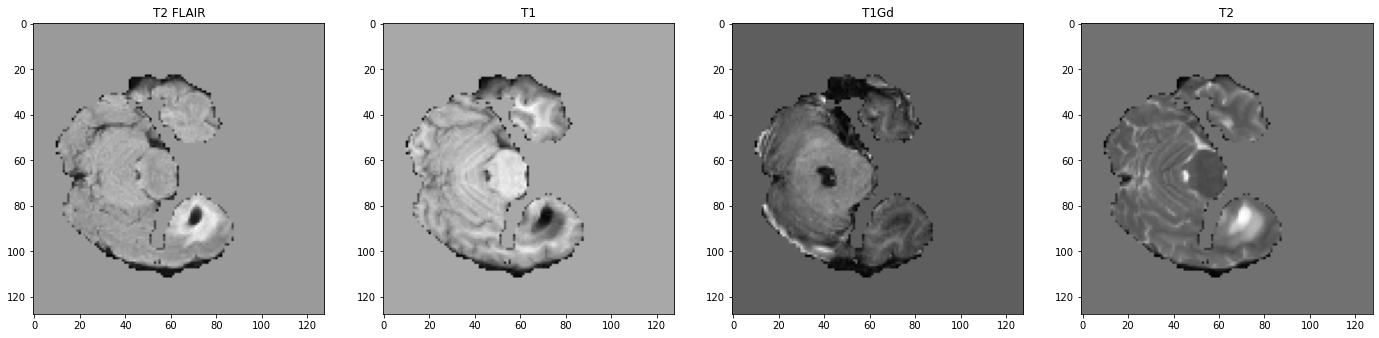

Ground truth masks


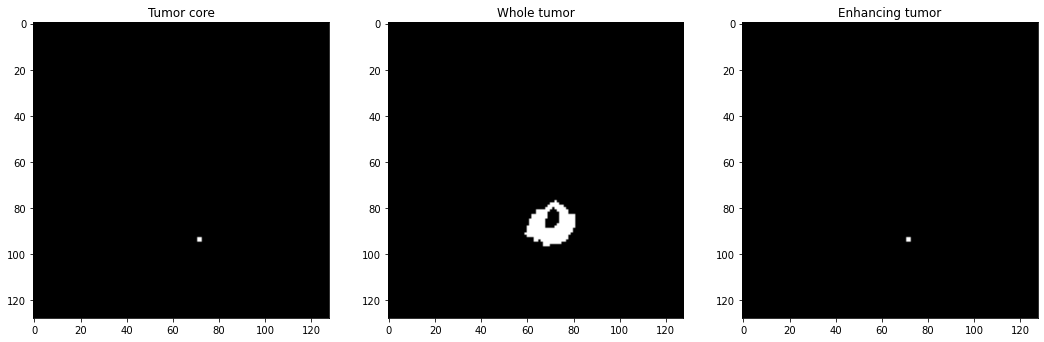

Predicted masks


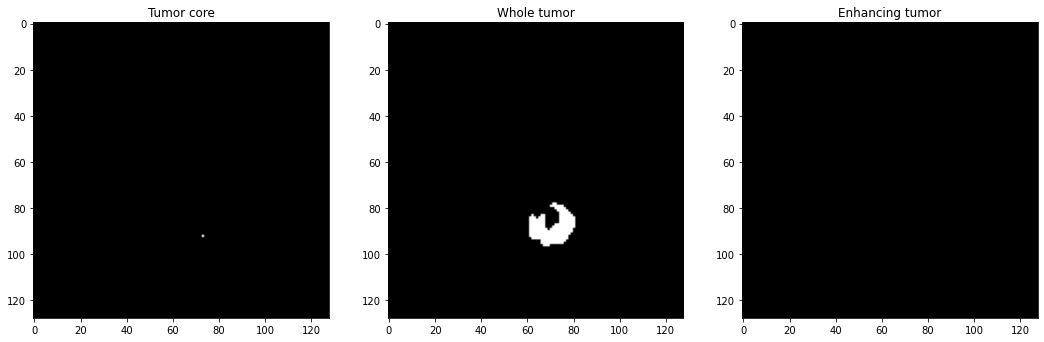

In [31]:
model_path = os.path.join("best_metric_model.pth")
visualise_results(val_ds,model_path,3,20)